### Project 2 

### Overview
- Background 
- EDA
- Regression

### Background

**Problem Statement**

Our project 2 premise is that we are a property agency that has newly arrived in Singapore. We are trying to better understand one of our potential biggest sources of income: transacting resale flats. 

**Context**

We have been tasked with creating a regression model based on Singapore Housing Dataset. This model will predict the price of a house at sale.

This Dataset is an exceptionally detailed one with over 70 columns of different features relating to houses.

**Land**

According to an article by seedly, approximately 102 of Singapore's 728.6 square kilometre land area is used for housing.

The two housing markets can be roughly divided into _**Public**_ and _**Private**_ housing.

**Factors to consider**

A quick search on the most important factors when considering housing include:

transport, food and ammenities as well as distance from schools. 




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

In [2]:
#reading the test dataset
train_data = pd.read_csv("./datasets/train.csv")
train_data2 = train_data.copy()
train_data3 = train_data.copy()
print(train_data.shape)
test_data = pd.read_csv("./datasets/test.csv")
test_data2 = test_data.copy()
test_data3 = test_data.copy()
#assessing the missing values




C:\Users\siaza\AppData\Local\Temp\ipykernel_17000\1344436226.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("./datasets/train.csv")


(150634, 77)


C:\Users\siaza\AppData\Local\Temp\ipykernel_17000\1344436226.py:6: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv("./datasets/test.csv")


### Basic EDA

#### EDA Histogram of basic observations

First we take a look at resale_price and look at the distribution.

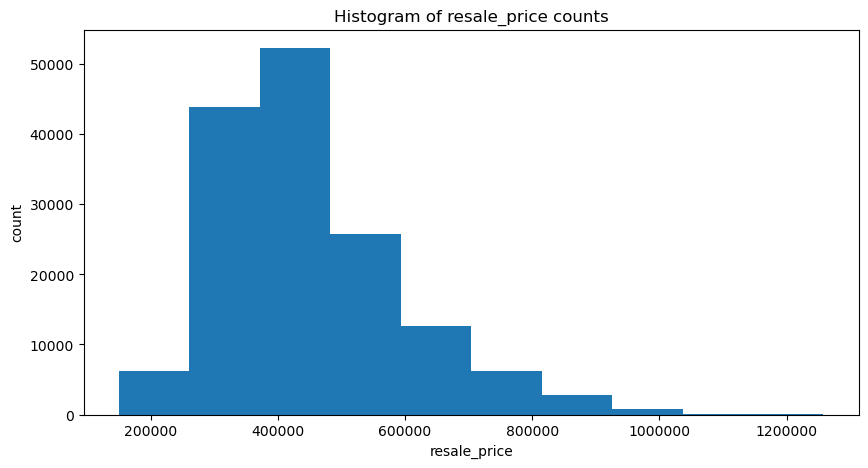

In [124]:
plt.figure(figsize = (10,5))

plt.hist(train_data['resale_price'],histtype='bar')
plt.ylabel('count')
plt.xlabel('resale_price')
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('Histogram of resale_price counts')
plt.show()

In [68]:
#general statistics for resale_price 
train_data['resale_price'].describe().apply(lambda x: format(x, 'f'))

count     150634.000000
mean      449161.501213
std       143307.573143
min       150000.000000
25%       347000.000000
50%       420000.000000
75%       520000.000000
max      1258000.000000
Name: resale_price, dtype: object

### Looking at na_vals

We will now be looking at 'Hawker_Within_1km', 'Mall_Within_500m', 'Hawker_Within_2km'

In [3]:
na_vals = train_data.isna().sum().sort_values(ascending = False).to_frame('vals')
na_vals.head(7)
#All hawker related features are dealt by other features such as “hawker_nearest_distance” and “hawker_market_stalls”.
#For mall checked values of entry 691 nad 150388 and saw that there was no relationship between the two locations in google maps one was 1 km away and the other was 2.5 km away

vals
Hawker_Within_500m     97390
Mall_Within_500m       92789
Hawker_Within_1km      60868
Hawker_Within_2km      29202
Mall_Within_1km        25426
Mall_Within_2km         1940
Mall_Nearest_Distance    829

Text(0, 0.5, 'resale price')

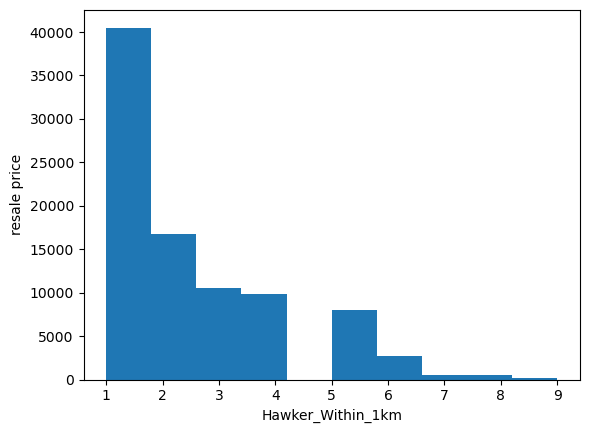

In [125]:
plt.hist(train_data['Hawker_Within_1km'])
plt.xlabel('Hawker_Within_1km')
plt.ylabel('resale price')

Text(0, 0.5, 'resale price')

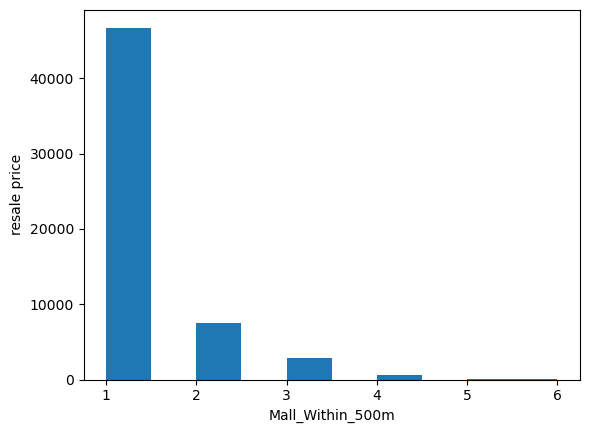

In [126]:
plt.hist(train_data['Mall_Within_500m'])
plt.xlabel('Mall_Within_500m')
plt.ylabel('resale price')

(array([30620., 25625., 10319.,  6416.,  6925.,  2185.,  5713.,  9600.,
         6529.,     0.,  4451.,  5490.,  2448.,  1815.,  1042.,   622.,
          810.,   258.,   398.,   166.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ,
        10.9, 11.8, 12.7, 13.6, 14.5, 15.4, 16.3, 17.2, 18.1, 19. ]),
 <BarContainer object of 20 artists>)

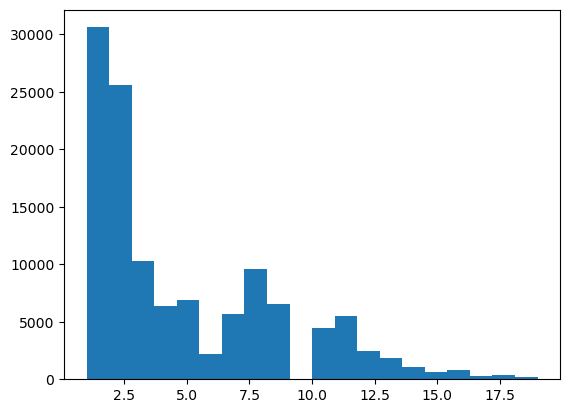

In [127]:
plt.hist(train_data['Hawker_Within_2km'],bins=20)

#### Dropping irrelevant data/ data with NAs for baseline model

After taking a look at 'Hawker_Within_500m', 'Mall_Within_500m', 'Hawker_Within_1km', 'Hawker_Within_2km','Mall_Within_1km', 'Mall_Nearest_Distance', 'Mall_Within_2km' we see there are alot of na values.

Tranc_YearMonth is already dealt with by 'Tranc_Year' as well as 'Tranc_Month'.
For ease of baseline, address,planning area were dropped as columns such as town, street_name etc exist which already cover similar information.
'postal' and 'Mall_Nearest_Distance' will be dealt with later in feature engineering. 
Something to note is that when trying to run baseline model, features such as 'postal' when passed through one hot encoding made the dataset too large and was unable to be used.

In [4]:
train_data.drop(columns=['id','Hawker_Within_500m', 'Mall_Within_500m', 'Hawker_Within_1km', 'Hawker_Within_2km','Mall_Within_1km', 'Mall_Nearest_Distance', 'Mall_Within_2km','Tranc_YearMonth', 'block','address','planning_area','postal'],
                         inplace=True)
test_data.drop(columns=['id','Hawker_Within_500m', 'Mall_Within_500m', 'Hawker_Within_1km', 'Hawker_Within_2km','Mall_Within_1km', 'Mall_Nearest_Distance', 'Mall_Within_2km','Tranc_YearMonth', 'block','address','planning_area','postal'],
                         inplace=True)

In [5]:
#showing that na has been removed
[print(k,v) for k,v in train_data.isna().sum().items() if v> 0]


[]

In [6]:
#seperating objects from numeric
objects = [k for k,v in train_data.dtypes.items() if v == object]
objects2 = [k for k,v in train_data.dtypes.items() if v == object]
# #isolate objects_df
objects_df = train_data.loc[:, objects].copy()
#no null values in the objects only df
objects_df.isna().sum()
#dealing with date
numeric_df = train_data.loc [:, ~train_data.columns.isin(objects)].copy()


#### General Observations for factors relating to resale_price

Decided to take a look at some features such as lease_commence_date, storey_value, mrt and bus distance based on personal opinion that these are strong factors when taking a look at modelling pricing.

Hoping to see a strong linear relationship to justify the feature being in the model.

There seems to be great varience between relationship of all factors and resale_price.

Text(0.5, 1.0, 'lease_commence_date against resale_price')

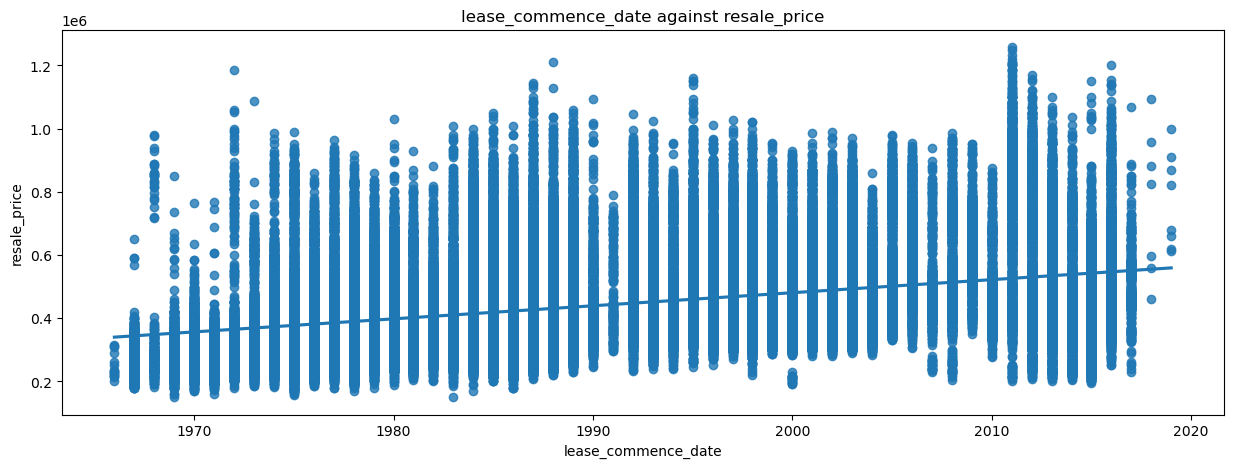

In [132]:
#linear relationship between lease_commence_date and lease year
plt.figure(figsize=(15,5))
sns.regplot(data=train_data, x='lease_commence_date', y='resale_price', ci=95);
plt.title('lease_commence_date against resale_price')


Text(0.5, 1.0, 'hdb_age against resale_price')

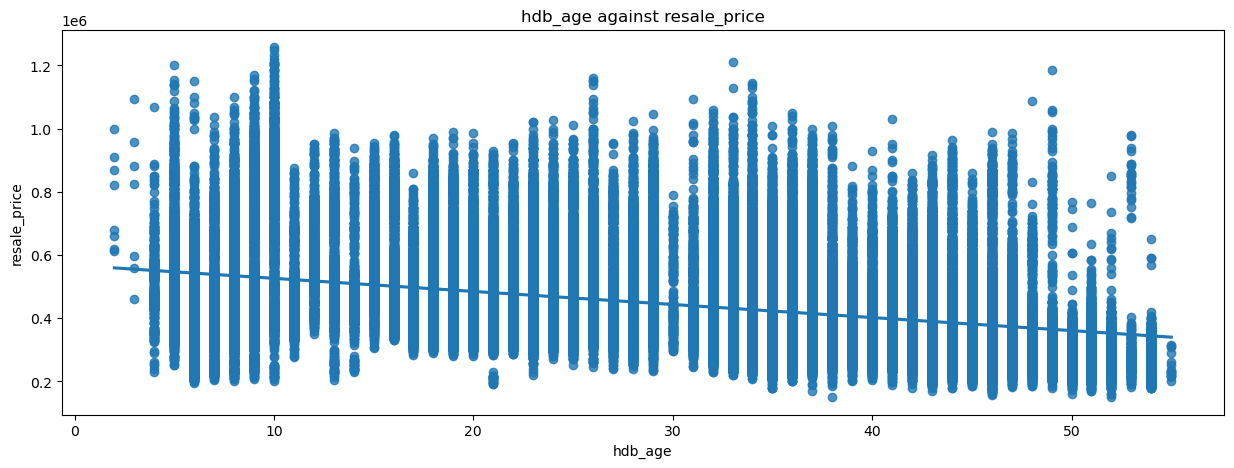

In [133]:
#explore further with 
plt.figure(figsize=(15,5))
sns.regplot(data=train_data, x='hdb_age', y='resale_price', ci=95);
plt.title('hdb_age against resale_price')

Text(0.5, 1.0, 'middle value of flat storey range against resale_price')

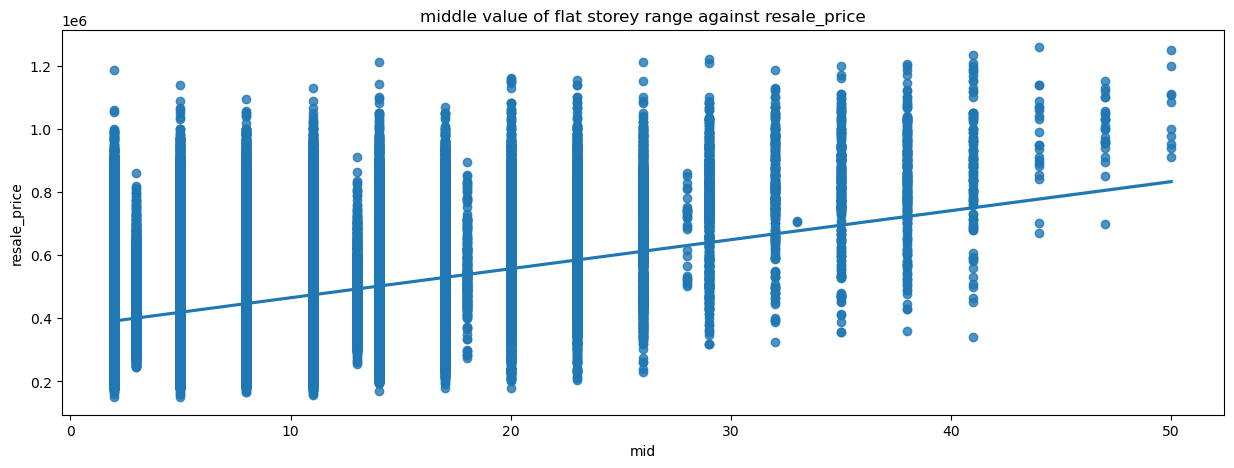

In [134]:
#linear relationship between lease_commence_date and lease year
plt.figure(figsize=(15,5))
sns.regplot(data=train_data, x='mid', y='resale_price', ci=95);
plt.title('middle value of flat storey range against resale_price')

Text(0.5, 1.0, 'mrt_nearest distance against resale_price')

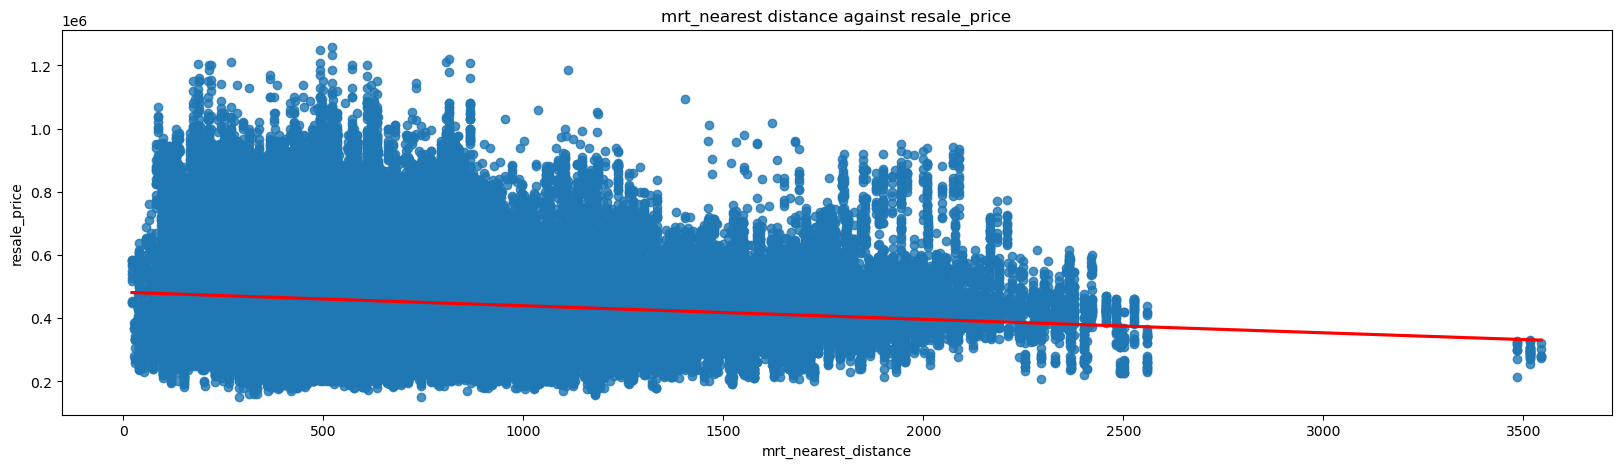

In [135]:
plt.figure(figsize=(20,5))
sns.regplot(data=train_data, x='mrt_nearest_distance', y='resale_price', ci=95,line_kws={"color": "red"});
plt.title('mrt_nearest distance against resale_price')

Text(0.5, 1.0, 'bus_stop_nearest_distance distance against resale_price')

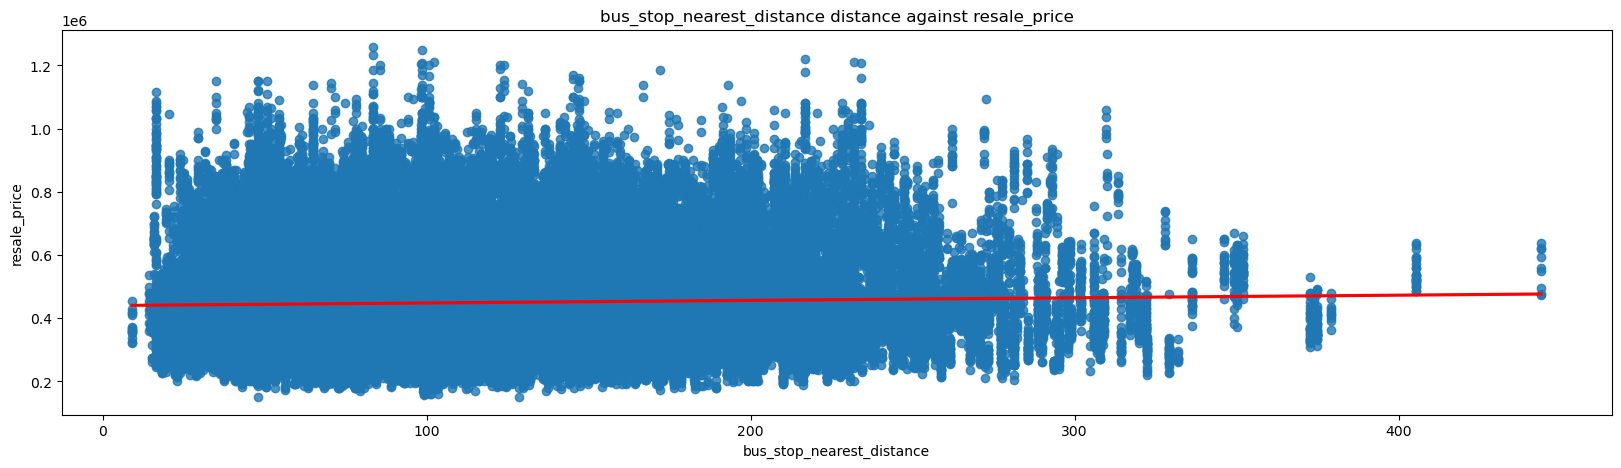

In [136]:
plt.figure(figsize=(20,5))
sns.regplot(data=train_data, x='bus_stop_nearest_distance', y='resale_price', ci=95,line_kws={"color": "red"});
plt.title('bus_stop_nearest_distance distance against resale_price')

### Baseline Model

We now model a baseline linear regression model with all factors except the ones dropped above.

In [8]:
#setting y as resale price and X as everything else.
y = train_data['resale_price']
X = train_data.drop(columns='resale_price')


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337)

In [10]:
ss = StandardScaler()

In [11]:
#only X_train with object/categorical values
X_train_cat = X_train.loc[:, objects].copy().astype(str)
#only X_test with object/categorical values
X_test_cat = X_test.loc[:, objects].copy().astype(str)

Used one hot encoder to transform the categorical/object features into features usable in machine learning "dummifying" the values in X_train.

In [12]:
ohe = OneHotEncoder(handle_unknown='ignore',drop='first')
#ohe the values for X_train
X_train_cat = pd.DataFrame((ohe.fit_transform(X_train_cat).toarray()), columns = ohe.get_feature_names_out())
#ohe the values for X_test
X_test_cat = pd.DataFrame(ohe.transform(X_test_cat).toarray(), columns = ohe.get_feature_names_out())

C:\Users\siaza\.conda\envs\dsi-sg\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


transforming test_data.csv data for comparision as well as 
fit_transform the standardscaler 

In [13]:
#isolate the X_Train data that is NOT related to objects
X_num_train = X_train.loc [:, ~X_train.columns.isin(objects)]
X_train_num2 = pd.DataFrame(ss.fit_transform(X_num_train), columns = ss.get_feature_names_out())
X_train_num2.isna().sum()

floor_area_sqm               0
lease_commence_date          0
Tranc_Year                   0
Tranc_Month                  0
mid_storey                   0
lower                        0
upper                        0
mid                          0
floor_area_sqft              0
hdb_age                      0
max_floor_lvl                0
year_completed               0
total_dwelling_units         0
1room_sold                   0
2room_sold                   0
3room_sold                   0
4room_sold                   0
5room_sold                   0
exec_sold                    0
multigen_sold                0
studio_apartment_sold        0
1room_rental                 0
2room_rental                 0
3room_rental                 0
other_room_rental            0
Latitude                     0
Longitude                    0
Hawker_Nearest_Distance      0
hawker_food_stalls           0
hawker_market_stalls         0
mrt_nearest_distance         0
bus_interchange              0
mrt_inte

Now using only non-objects features scale them with standard scaler

In [14]:
#X_num_test data that is not object
X_num_test = X_test.loc [:, ~X_test.columns.isin(objects)]
#convert using standard scaler
X_test_num = pd.DataFrame(ss.transform(X_num_test), columns = ss.get_feature_names_out())


Combine the non-boject and object data into a single dataframe for both the train and hold out dataset.

In [15]:
#Combine X_train_cat to X_train_num2
X_train_final = X_train_cat.join(X_train_num2)
#Combine X_test_cat to X_test_num
X_test_final = X_test_cat.join(X_test_num)

We want to take a look at how it holds up to the train.csv dataset we must thus apply standardscaler and one hot encoding simiarly.

In [16]:

#filter the test_data that is NUMERIC using objects list
test_data_obj = test_data.loc[:, objects2].copy().astype(str)
#turn it into a dataframe using ONE HOT ENCODING
test_dataset_cat = pd.DataFrame((ohe.transform(test_data_obj).toarray()), columns= ohe.get_feature_names_out())
#filter the test_data that is NOT NUMERIC using objects list
train_dataset_num = test_data.loc [:, ~test_data.columns.isin(objects2)]
#turn it into a dataframe using STANDARD SCALAR
train_dataset_num2 = pd.DataFrame(ss.transform(train_dataset_num), columns = ss.get_feature_names_out())
train_dataset_final = test_dataset_cat.join(train_dataset_num2)

Ensuring there are no empty values before linear regression (gives us a look at the 2777 features being used in this dataset).

In [17]:
X_train_final.isna().sum()

town_BEDOK              0
town_BISHAN             0
town_BUKIT BATOK        0
town_BUKIT MERAH        0
town_BUKIT PANJANG      0
                       ..
sec_sch_nearest_dist    0
cutoff_point            0
affiliation             0
sec_sch_latitude        0
sec_sch_longitude       0
Length: 2777, dtype: int64

Instatiate the LinearRegression, fit transform and print out the scores and root of mean square error (rmse).

In [18]:
lr = LinearRegression()

In [19]:
lr.fit(X_train_final,y_train)

LinearRegression()

In [28]:
lr.score(X_train_final,y_train)

0.936498267702631

In [21]:
cross_val_score(lr, X_train_final,y_train, cv=5).mean()

-5.898870075734533e+17

In [22]:
lr.score(X_test_final,y_test)

-531356238013872.8

In [23]:
y_pred = lr.predict(X_test_final)

In [24]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

3303384616829.148

In [29]:
X_train_final

town_BEDOK  town_BISHAN  town_BUKIT BATOK  town_BUKIT MERAH  \
0              0.0          0.0               0.0               0.0   
1              0.0          0.0               0.0               0.0   
2              0.0          0.0               0.0               0.0   
3              0.0          0.0               0.0               0.0   
4              0.0          0.0               0.0               0.0   
...            ...          ...               ...               ...   
112970         1.0          0.0               0.0               0.0   
112971         0.0          0.0               0.0               0.0   
112972         0.0          0.0               0.0               0.0   
112973         0.0          0.0               0.0               0.0   
112974         0.0          0.0               0.0               0.0   

        town_BUKIT PANJANG  town_BUKIT TIMAH  town_CENTRAL AREA  \
0                      0.0               0.0                0.0   
1                      0.0               0.0                0.0   
2                      1.0               0.0                0.0   
3                      0.0               0.0                0.0   
4                      0.0               0.0                0.0   
...                    ...               ...                ...   
112970                 0.0               0.0                0.0   
112971                 0.0               0.0                0.0   
112972                 0.0               0.0                0.0   
112973                 0.0               0.0                0.0   
112974                 0.0               0.0                0.0   

        town_CHOA CHU KANG  town_CLEMENTI  town_GEYLANG  ...  \
0                      0.0            0.0           0.0  ...   
1                      0.0            0.0           0.0  ...   
2                      0.0            0.0           0.0  ...   
3                      0.0            0.0           0.0  ...   
4                      0.0            0.0           0.0  ...   
...                    ...            ...           ...  ...   
112970                 0.0            0.0           0.0  ...   
112971                 1.0            0.0           0.0  ...   
112972                 0.0            0.0           0.0  ...   
112973                 0.0            0.0           0.0  ...   
112974                 0.0            0.0           0.0  ...   

        pri_sch_nearest_distance   vacancy  pri_sch_affiliation  \
0                      -0.407934  0.928951            -0.357269   
1                      -1.307269  0.034279            -0.357269   
2                      -1.110738 -0.245306            -0.357269   
3                      -0.523864 -0.189389            -0.357269   
4                      -0.105326  2.047291            -0.357269   
...                          ...       ...                  ...   
112970                 -0.490479  0.593449            -0.357269   
112971                 -0.461521  0.705283            -0.357269   
112972                  0.175366 -1.866898            -0.357269   
112973                 -0.449998 -0.916309            -0.357269   
112974                 -1.305076 -0.524891            -0.357269   

        pri_sch_latitude  pri_sch_longitude  sec_sch_nearest_dist  \
0               1.509639          -0.838352             -0.375503   
1              -1.032199           0.361303              0.376353   
2               0.317912          -0.962265              0.433332   
3               0.270276           1.384282              2.673475   
4               1.580936          -0.084934             -0.837545   
...                  ...                ...                   ...   
112970         -0.828137           0.994292              2.049851   
112971          0.269644          -1.338090             -0.486973   
112972         -0.454684          -1.652545              0.960447   
112973          1.652789          -0.651247             -0.414477   
112974          1

Baseline model is grossly overfit and requires feature engineering. 

### Regressions

We now try ridge and lasso with default values to see if predictions are any better.

#### Ridge

In [25]:
#Ridge
ridge_model = Ridge()
ridge_model.fit(X_train_final,y_train)


Ridge()

In [37]:
ridge_model.score(X_train_final,y_train)

0.9362975025749736

In [38]:
cross_val_score(ridge_model, X_train_final,y_train, cv=5).mean()

0.9328418459824075

In [39]:
ridge_model.score(X_test_final,y_test)

0.9343861104913228

In [58]:
ridge_pred = ridge_model.predict(X_test_final)

Top 20 and bottom 20 coeffs aka highest impact features in the default ridge() model

street_name, full_flat_type and distance from secondary and primary school definetly have noticable impacts on resale price. 

Its worth noting at this point that bus_stop_name seems to have a noticable impact on the model with placements both in top 20 coeffs and bottom 20 coeffs.
We will however be removing this feature with the assumption that street_name covers this feature in a similar way.

In [ ]:
coeffs = ridge_model.coef_
coeffs_df = pd.DataFrame( {'columns': list(X_train_final.columns), 'coeffs' : coeffs})
coeffs_df.sort_values('coeffs', ascending=False).head(20)


columns         coeffs
623                      flat_model_Terrace  224392.050044
307                street_name_KIM CHENG ST  188230.805236
346                street_name_MOH GUAN TER  185692.088623
310                 street_name_KIM PONG RD  170549.485256
318                 street_name_LIM LIAK ST  170303.697047
497              street_name_TIONG BAHRU RD  155020.775550
639           full_flat_type_3 ROOM Terrace  129283.285243
410                 street_name_SENG POH RD  126752.224534
43             street_name_ANG MO KIO AVE 2  126557.122177
765   bus_stop_name_AFT Ang mo kio avenue 2  126557.122177
484                street_name_TAO CHING RD  116194.972219
317               street_name_LENGKONG TIGA  113202.605969
285           street_name_JURONG WEST ST 52  110807.666464
2470     pri_sch_name_Fuchun Primary School  104302.683238
88                  street_name_BOON LAY PL  103026.202488
2214       bus_stop_name_Opp Parkland Green   99602.631505
2502  pri_sch_name_Marsiling Primary School   97838.968553
2368             bus_stop_name_Teban Gdn PO   97441.231846
852                 bus_stop_name_BISHAN PK   96207.277808
650           full_flat_type_4 ROOM Terrace   95108.764800

In [49]:
coeffs_df_ridge_model.sort_values('coeffs', ascending=False).tail(20)

columns         coeffs
295             street_name_JURONG WEST ST 81  -65681.926488
601                     storey_range_36 TO 40  -66392.536157
78                       street_name_BEO CRES  -66501.635351
581                 street_name_YUNG SHENG RD  -67498.402401
263                 street_name_JLN TECK WHYE  -67840.200353
1120                    bus_stop_name_Blk 212  -68110.356450
1178                    bus_stop_name_Blk 263  -68933.696980
293             street_name_JURONG WEST ST 74  -70768.453388
110           street_name_BT BATOK WEST AVE 7  -71790.344248
257                    street_name_JLN KLINIK  -72116.277170
1545                     bus_stop_name_Blk 67  -72961.410999
114                 street_name_BT MERAH VIEW  -77297.822738
1988            bus_stop_name_Opp Blk 263A CP  -82089.919654
441                   street_name_SIN MING RD  -82863.696545
799            bus_stop_name_Aft Hasanah Mque  -84455.848652
244                      street_name_INDUS RD  -90139.379048
726                        mrt_name_Marsiling  -90392.819709
186                      street_name_DEPOT RD  -91780.441712
451                 street_name_TAMAN HO SWEE  -97220.498677
2228  bus_stop_name_Opp River Valley High Sch -102023.282951

In [48]:
np.sqrt(metrics.mean_squared_error(y_test, ridge_pred))

36708.28896446506

Turning into a csv for kaggle submission

In [ ]:
s1 = test_data2['id']
s2 = pd.Series(ridge_model.predict(train_dataset_final))
sub1 = pd.concat([s1, s2], axis=1)
sub1.rename(columns={0:'Predicted'},inplace=True)

if not os.path.exists('../data/output'):
    os.makedirs('../data/output')
sub1.to_csv('ridge_model.csv',index=False)

#### Lasso

Similarly to ridge, instantiate Lasso regression, fit and print out the score against X_train, X_test as well as rmse.

In [50]:
lasso_model = Lasso()


In [51]:
lasso_model.fit(X_train_final,y_train)

C:\Users\siaza\.conda\envs\dsi-sg\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.317e+13, tolerance: 2.320e+11
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [52]:
cross_val_score(lasso_model, X_train_final,y_train, cv=5).mean()

C:\Users\siaza\.conda\envs\dsi-sg\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.950e+13, tolerance: 1.854e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\siaza\.conda\envs\dsi-sg\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.900e+13, tolerance: 1.861e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\siaza\.conda\envs\dsi-sg\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

0.9325061689853278

In [59]:
lasso_model.score(X_train_final,y_train)

0.9355590385519732

In [54]:
lasso_model.score(X_test_final,y_test)

0.9339754061175116

In [318]:
s1 = test_data3['id']
s2 = pd.Series(lasso_model.predict(train_dataset_final))
sub2 = pd.concat([s1, s2], axis=1)
sub2.rename(columns={0:'Predicted'},inplace=True)

if not os.path.exists('../data/output'):
    os.makedirs('../data/output')
sub2.to_csv('lasso_model.csv',index=False)

In [55]:
lasso_pred = lasso_model.predict(X_test_final)


In [60]:
np.sqrt(metrics.mean_squared_error(y_test, lasso_pred))

36822.9958990134

### Feature engineering/ Feature selection

Our baseline is extremely strong with quite a solid r square value as well as a reasonable rmse score.

We will however, attempt to improve it further with feature selection and hyper parameter tuning.

It is worth noting that the dataset as is, with scaling and one hot encoding is too large for any cross validation. It is thus necessary to also cut down on some of the features. However, we will also attempt to make features that hopefully represent ratios and relationship with simple divison multiplaction etc.

#### Looking at correlation 

We take a look at correlation of features to the table just to get a general sense of what might impact resale price. We picked 0.3 as the usual greater than 0.5 correlation is a filter that leaves very few features to examine.

We can see here that max_floor_lvl and the 5room_sold features are strongly correlated to the resale price. We will deal with this abit later in feature engineering. We can also see the most negatively correlated to resale_price is 3room_sold. Our feature abit later on tries to incorporate this information as well.

In [176]:
#higher end of correlation
train_data.corr()[train_data.corr()['resale_price'] > 0.3][['resale_price']].sort_values(by=['resale_price'],ascending=False)
# train_data['floor_area_sqm','year_completed','max_floor_lvl','','']

C:\Users\siaza\AppData\Local\Temp\ipykernel_2880\2630929224.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data.corr()[train_data.corr()['resale_price'] > 0.3][['resale_price']].sort_values(by=['resale_price'],ascending=False)


resale_price
resale_price             1.000000
floor_area_sqm           0.654120
floor_area_sqft          0.654120
max_floor_lvl            0.495650
5room_sold               0.359434
year_completed           0.353698
upper                    0.353552
mid_storey               0.353213
mid                      0.353213
lower                    0.352466
lease_commence_date      0.350337
exec_sold                0.337500

In [178]:
#lower end of correlation
train_data.corr()[train_data.corr()['resale_price'] < 0][['resale_price']].sort_values(by=['resale_price'])
#no action take atm

C:\Users\siaza\AppData\Local\Temp\ipykernel_2880\478771194.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data.corr()[train_data.corr()['resale_price'] < 0][['resale_price']].sort_values(by=['resale_price'])


resale_price
3room_sold                   -0.410368
hdb_age                      -0.350337
sec_sch_latitude             -0.216303
Latitude                     -0.216153
bus_stop_latitude            -0.215760
mrt_latitude                 -0.214939
pri_sch_latitude             -0.214707
2room_sold                   -0.145287
total_dwelling_units         -0.140725
mrt_nearest_distance         -0.128222
3room_rental                 -0.079965
2room_rental                 -0.077548
1room_sold                   -0.039434
1room_rental                 -0.037993
hawker_food_stalls           -0.033581
Tranc_Year                   -0.019146
vacancy                      -0.016140
Hawker_Nearest_Distance      -0.014537
pri_sch_nearest_distance     -0.011004
hawker_market_stalls         -0.009378
Tranc_Month                  -0.006823
affiliation                  -0.000466

#### Using OLS to check for different feature impact on model

we determined that the features: 
* 'multigen_sold'
* 'Latitude'
* 'bus_stop_latitude'
* 'bus_stop_longitude'
* 'pri_sch_longitude'
* 'sec_sch_latitude'

have a low impact on the model due to low 'P>|t|' values and will thus be removed.


In [ ]:
X_train_final_sm = X_train_final.copy()
X_train_final_sm2 = sm.add_constant(X_train_final_sm)


In [ ]:
y_train_list = y_train.to_list()
statsmodels_lr = sm.OLS(y_train_list, X_train_final_sm2).fit()

In [ ]:
statsmodels_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     632.3
Date:                Thu, 05 Jan 2023   Prob (F-statistic):               0.00
Time:                        19:50:44   Log-Likelihood:            -1.3459e+06
No. Observations:              112975   AIC:                         2.697e+06
Df Residuals:                  110398   BIC:                         2.722e+06
Df Model:                        2576                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
const                                                    4.117e+05   1.23e+04     33.557      0.000    3.88e+05    4.36e+05
town_BEDOK                                               3759.8554   1.01e+04      0.372      0.710    -1.6e+04    2.36e+04
town_BISHAN                                              8.237e+04   9644.877      8.540      0.000    6.35e+04    1.01e+05
town_BUKIT BATOK                                        -5.305e+04   1.28e+04     -4.136      0.000   -7.82e+04   -2.79e+04
town_BUKIT MERAH                                         4.171e+04   1.24e+04      3.375      0.001    1.75e+04    6.59e+04
town_BUKIT PANJANG                                       -1.22e+04   6811.548     -1.791      0.073   -2.55e+04    1154.063
town_BUKIT TIMAH                                          5.57e+04   4123.081     13.510      0.000    4.76e+04    6.38e+04
town_CENTRAL AREA                                         3.75e+04   1.02e+04      3.686      0.000    1.76e+04    5.74e+04
town_CHOA CHU KANG                                      -1.691e+04   1.25e+04     -1.348      0.178   -4.15e+04    7676.858
town_CLEMENTI                                            2.269e+04   1.33e+04      1.701      0.089   -3459.372    4.88e+04
town_GEYLANG                                            -2.071e+04   2.04e+04     -1.013      0.311   -6.08e+04    1.94e+04
town_HOUGANG                                            -2.209e+04   1.52e+04     -1.449      0.147    -5.2e+04    7790.659
town_JURONG EAST                                        -1.073e+04   1.03e+04     -1.037      0.300    -3.1e+04    9543.623
town_JURONG WEST                                        -1.833e+04   9859.030     -1.859      0.063   -3.77e+04     993.090
town_KALLANG/WHAMPOA                                     3037.0954   1.01e+04      0.300      0.764   -1.68e+04    2.29e+04
town_MARINE PARADE                                       6.144e+04   8387.220      7.326      0.000     4.5e+04    7.79e+04
town_PASIR RIS                                          -2.068e+04   8986.534     -2.301      0.021   -3.83e+04   -3068.059
town_PUNGGOL                                            -2.858e+04   1.83e+04     -1.561      0.119   -6.45e+04    7302.500
town_QUEENSTOWN                                          1.705e+04   8707.177      1.958      0.050     -18.344    3.41e+04
town_SEMBAWANG                                            329.9983   3925.407      0.084      0.933   -7363.743    8023.740
town_SENGKANG                                           -4.882e+04   1.83e+04     -2.667      0.008   -8.47e+04   -1.29e+04
town_SERANGOON                                           4.872e+04    1.6e+04      3.047      0.002    1.74

In [ ]:
X_train_final_sm2

const  town_BEDOK  town_BISHAN  town_BUKIT BATOK  town_BUKIT MERAH  \
0         1.0         0.0          0.0               0.0               0.0   
1         1.0         0.0          0.0               0.0               0.0   
2         1.0         0.0          0.0               0.0               0.0   
3         1.0         0.0          0.0               0.0               0.0   
4         1.0         0.0          0.0               0.0               0.0   
...       ...         ...          ...               ...               ...   
112970    1.0         1.0          0.0               0.0               0.0   
112971    1.0         0.0          0.0               0.0               0.0   
112972    1.0         0.0          0.0               0.0               0.0   
112973    1.0         0.0          0.0               0.0               0.0   
112974    1.0         0.0          0.0               0.0               0.0   

        town_BUKIT PANJANG  town_BUKIT TIMAH  town_CENTRAL AREA  \
0                      0.0               0.0                0.0   
1                      0.0               0.0                0.0   
2                      1.0               0.0                0.0   
3                      0.0               0.0                0.0   
4                      0.0               0.0                0.0   
...                    ...               ...                ...   
112970                 0.0               0.0                0.0   
112971                 0.0               0.0                0.0   
112972                 0.0               0.0                0.0   
112973                 0.0               0.0                0.0   
112974                 0.0               0.0                0.0   

        town_CHOA CHU KANG  town_CLEMENTI  ...  pri_sch_nearest_distance  \
0                      0.0            0.0  ...                 -0.407934   
1                      0.0            0.0  ...                 -1.307269   
2                      0.0            0.0  ...                 -1.110738   
3                      0.0            0.0  ...                 -0.523864   
4                      0.0            0.0  ...                 -0.105326   
...                    ...            ...  ...                       ...   
112970                 0.0            0.0  ...                 -0.490479   
112971                 1.0            0.0  ...                 -0.461521   
112972                 0.0            0.0  ...                  0.175366   
112973                 0.0            0.0  ...                 -0.449998   
112974                 0.0            0.0  ...                 -1.305076   

         vacancy  pri_sch_affiliation  pri_sch_latitude  pri_sch_longitude  \
0       0.928951            -0.357269          1.509639          -0.838352   
1       0.034279            -0.357269         -1.032199           0.361303   
2      -0.245306            -0.357269          0.317912          -0.962265   
3      -0.189389            -0.357269          0.270276           1.384282   
4       2.047291            -0.357269          1.580936          -0.084934   
...          ...                  ...               ...                ...   
112970  0.593449            -0.357269         -0.828137           0.994292   
112971  0.705283            -0.357269          0.269644          -1.338090   
112972 -1.866898            -0.357269         -0.454684          -1.652545   
112973 -0.916309            -0.357269          1.652789          -0.651247   
112974 -0.524891            -0.357269          1.693014          -0.000352   

        sec_sch_nearest_dist  cutoff_point  affiliation  sec_sch_latitude  \
0                  -0.375503     -1.104542    -0.180902          1.522979   
1                   0.376353     -1.104542    -0.180902         -0.971249   
2                   0.433332     -1.104542    -0.180902          0.374524   
3                   2.673475     -0.106089    -0.180902          0.026608   
4                  -0.837545   

In [ ]:
X_num_train_sm = X_num_train.copy()
X_num_train_sm = sm.add_constant(X_num_train)
statsmodels_lr2 = sm.OLS(y_train_list, X_num_train_sm).fit()

In [ ]:
#remove using OLS model
p_val = statsmodels_lr2.summary2().tables[1]
X_train_final2 = X_train_final.copy()
p_val[p_val['P>|t|']>0.05].index.to_list()

#### Checking for colinearity

To improve our model further as well as reduce irrelevant features, we try to observe colinearity. We see the following features have this issue:
* 'floor_area_sft' 
* 'lease_commence_date' 
* 'mid'
* 'upper'
* 'lower'
We did not touch the features which were observed by our function such as 
'mrt_latitude', 'bus_stop_latitude', 'pri_sch_latitude', 'sec_sch_latitude' 'bus_stop_longtitude' 'pri_scho_longitude' etc as from our ridge model, it is clear transport is an important factor and we are unable to safety remove these features without negatively impacting the strength of our model. 

In [177]:
def colineraity_check(x):
    if x > 0.8:
        return True
    else:
        return False
y = train_data.corr().applymap(lambda x: colineraity_check(x))
dict_of_colinear = {}
for i in train_data.corr():
    dict_of_colinear[i] = y.loc[y[i]==True].index.tolist()
    
for k,v in dict_of_colinear.items():
    if len(v) >= 2:
        v.remove(k)
        print(f"Feature {k} is colinearly related to the list of following features :{v} \n")

# to remove floor_area_sft, lease_commence_date, mid,upper,lower  
#although mrt, bus_stop, secondary school and primary school colinearity exists, it is difficult to remove one without taking into account what are key aspects to various living conditions.

C:\Users\siaza\AppData\Local\Temp\ipykernel_2880\4194243757.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  y = train_data.corr().applymap(lambda x: colineraity_check(x))
C:\Users\siaza\AppData\Local\Temp\ipykernel_2880\4194243757.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  for i in train_data.corr():


Feature floor_area_sqm is colinearly related to the list of following features :['floor_area_sqft'] 

Feature lease_commence_date is colinearly related to the list of following features :['year_completed'] 

Feature mid_storey is colinearly related to the list of following features :['lower', 'upper', 'mid'] 

Feature lower is colinearly related to the list of following features :['mid_storey', 'upper', 'mid'] 

Feature upper is colinearly related to the list of following features :['mid_storey', 'lower', 'mid'] 

Feature mid is colinearly related to the list of following features :['mid_storey', 'lower', 'upper'] 

Feature floor_area_sqft is colinearly related to the list of following features :['floor_area_sqm'] 

Feature year_completed is colinearly related to the list of following features :['lease_commence_date'] 

Feature Latitude is colinearly related to the list of following features :['mrt_latitude', 'bus_stop_latitude', 'pri_sch_latitude', 'sec_sch_latitude'] 

Feature Longit

In [ ]:
#from OLS remove
['id',
 'multigen_sold',
 'Latitude',
 'bus_stop_latitude',
 'bus_stop_longitude',
 'pri_sch_longitude',
 'sec_sch_latitude',
 #from colinearity
 'floor_area_sft', 'lease_commence_date', 'mid','upper','lower']

Below is a groupby of the  number of na values **per town**

In [4]:
dummy_groupby = train_data2.groupby('town',dropna=False)[['town','Mall_Nearest_Distance']].count()
dummy_groupby['na_count'] = dummy_groupby['town'] - dummy_groupby['Mall_Nearest_Distance']
dummy_groupby.sort_values('na_count', ascending=False)

town  Mall_Nearest_Distance  na_count
town                                                   
PUNGGOL           7793                   7614       179
SENGKANG         11069                  10894       175
CHOA CHU KANG     6343                   6216       127
QUEENSTOWN        4121                   4062        59
TAMPINES         10506                  10463        43
JURONG EAST       3470                   3431        39
WOODLANDS        11334                  11299        35
GEYLANG           3986                   3951        35
BEDOK             9046                   9023        23
BUKIT PANJANG     5686                   5664        22
BUKIT MERAH       5854                   5834        20
HOUGANG           7555                   7537        18
PASIR RIS         4763                   4746        17
TOA PAYOH         4817                   4804        13
JURONG WEST      11451                  11445         6
KALLANG/WHAMPOA   4340                   4334         6
YISHUN           10042                  10037         5
CLEMENTI          3633                   3628         5
BISHAN            2871                   2870         1
ANG MO KIO        6908                   6907         1
MARINE PARADE      959                    959         0
SEMBAWANG         3723                   3723         0
CENTRAL AREA      1249                   1249         0
SERANGOON         3123                   3123         0
BUKIT TIMAH        369                    369         0
BUKIT BATOK       5623                   5623         0

#### Adding Mall_Nearest_Distance back with imputed values

Originally we ignored this feature for the sake of a simplified baseline. As we plan to remove quite a few features from the original model and seeing the impact of coefficents in our strongest model so far ridge, it is worth exploring the relationship between mall_nearest_distance and resale_price.

exploring further individual histograms of the 'Mall_Nearest_Distance' distributions to decide on imputation.

C:\Users\siaza\AppData\Local\Temp\ipykernel_2880\2281737458.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,5))


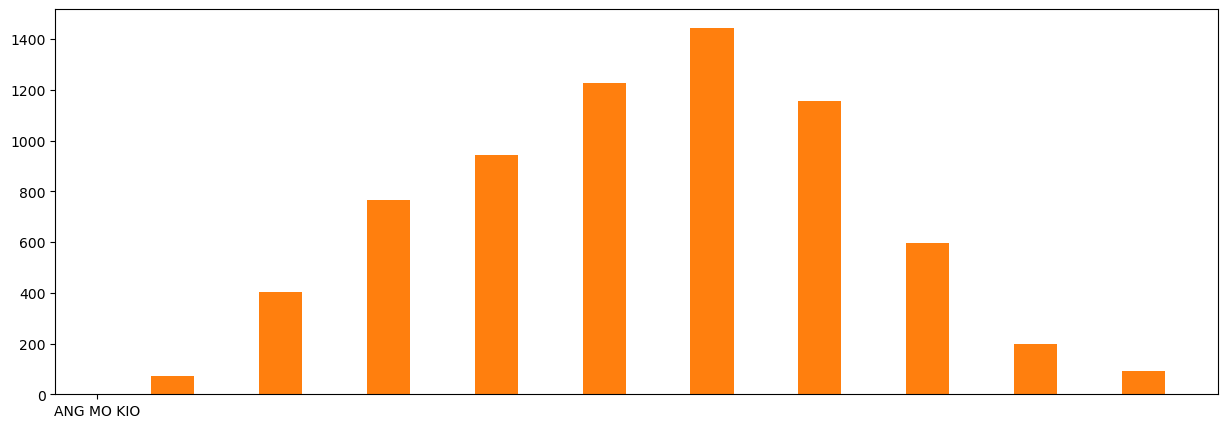

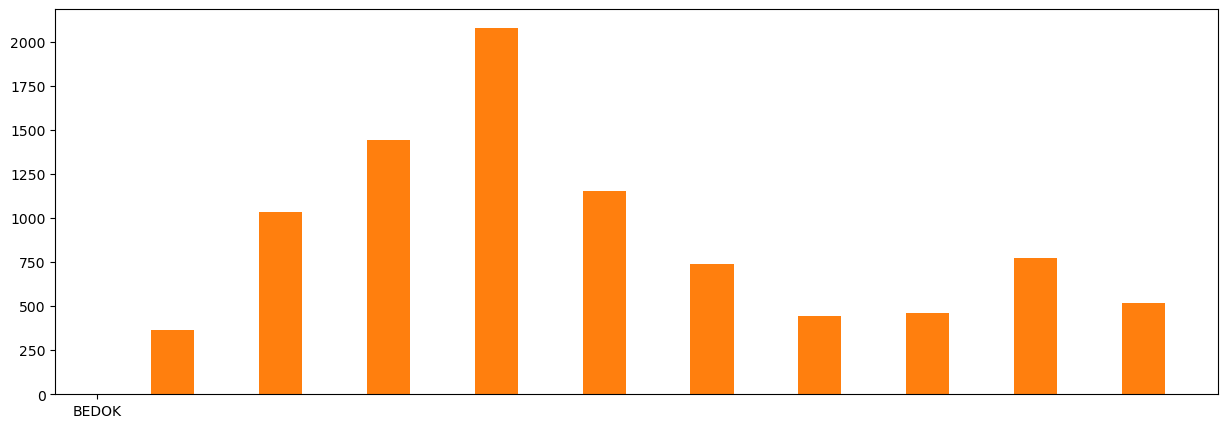

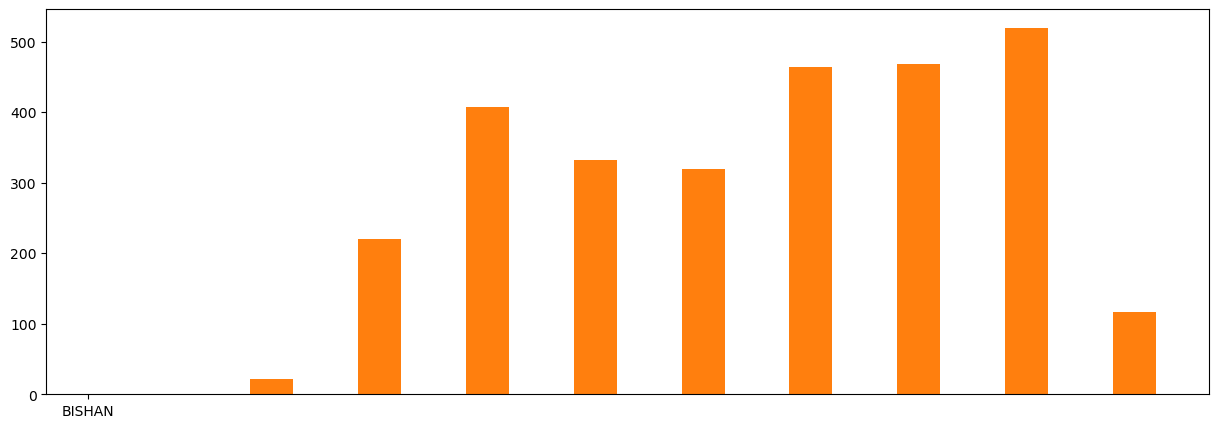

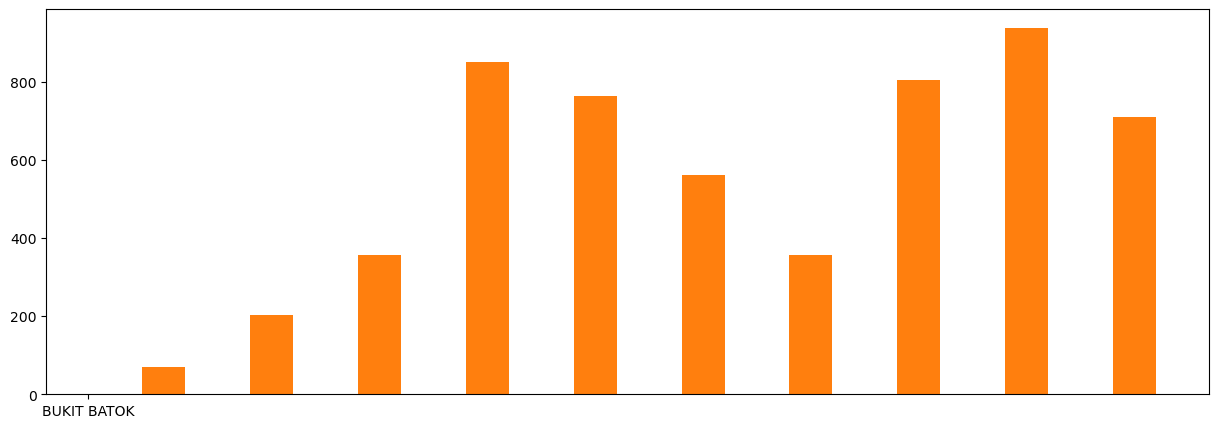

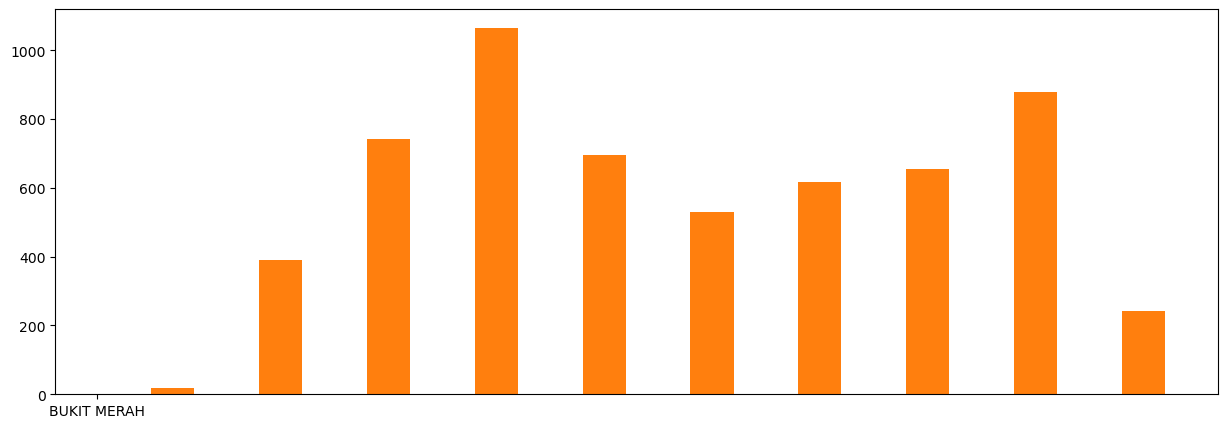

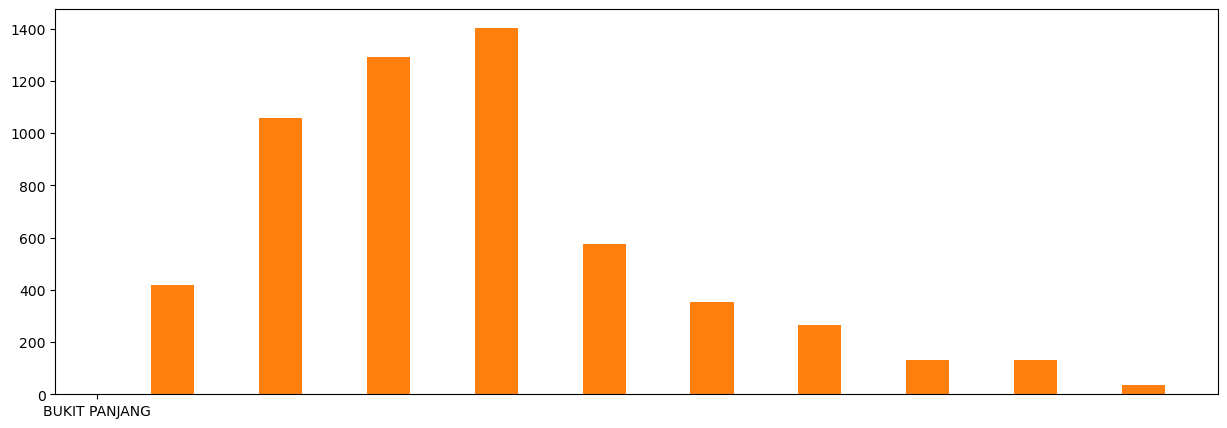

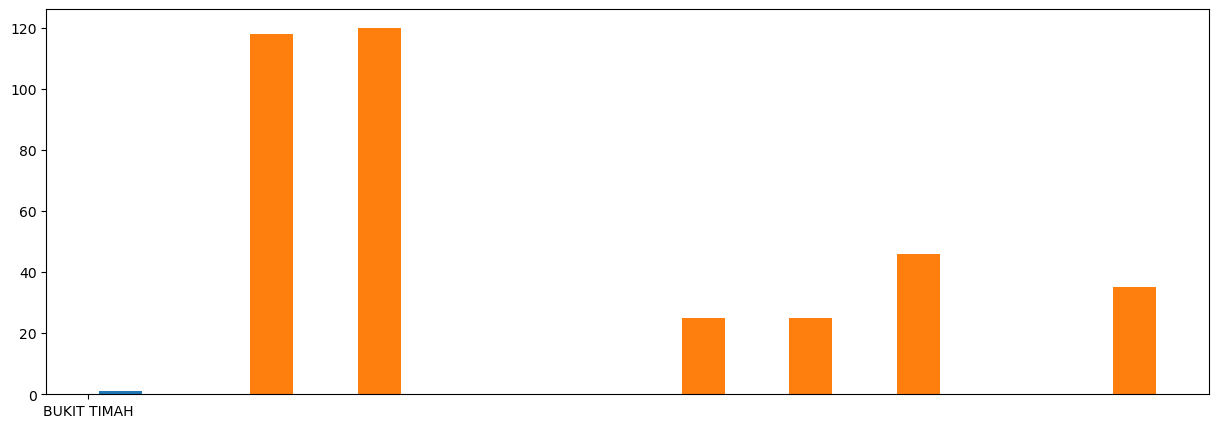

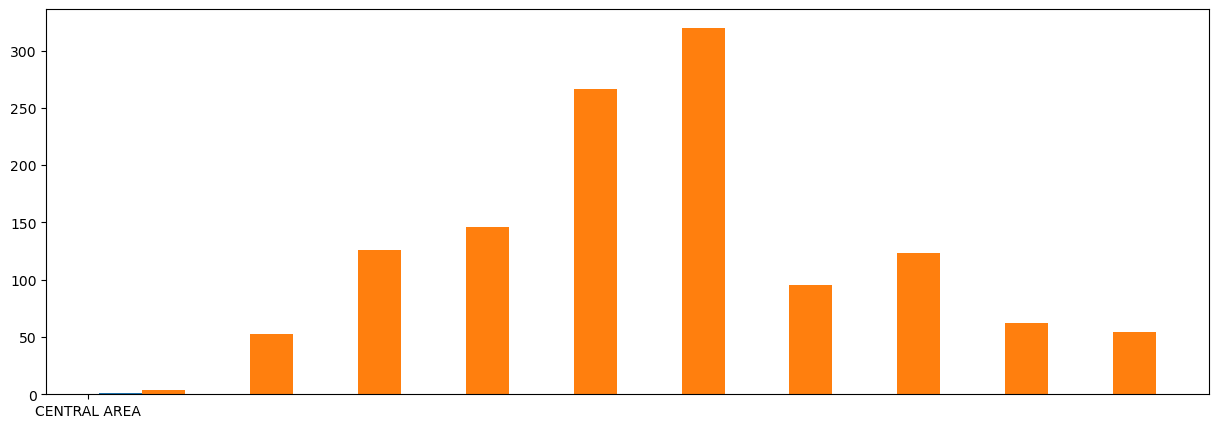

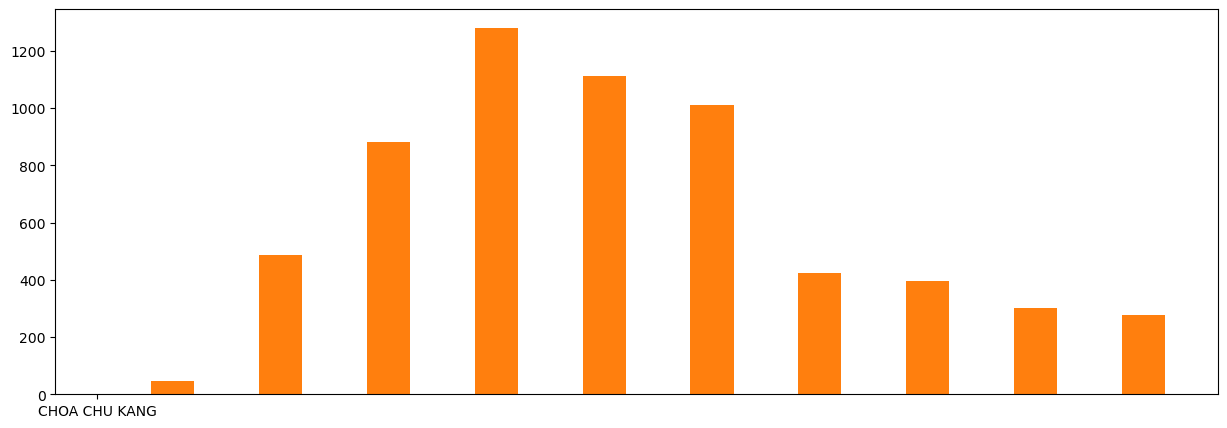

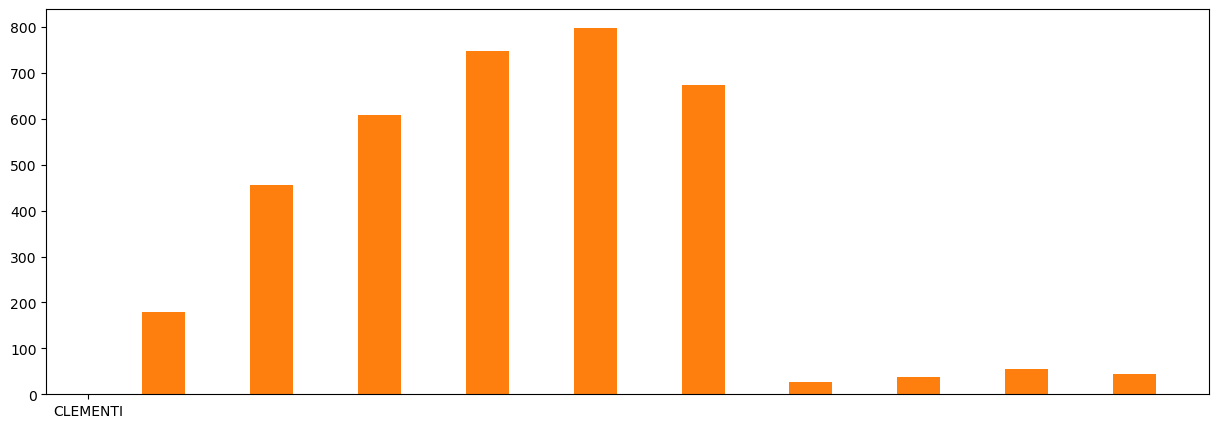

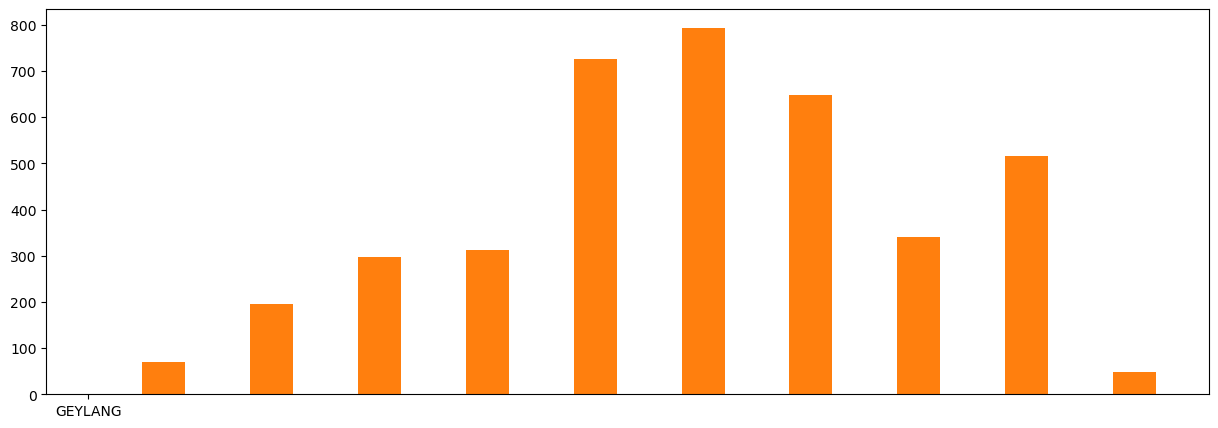

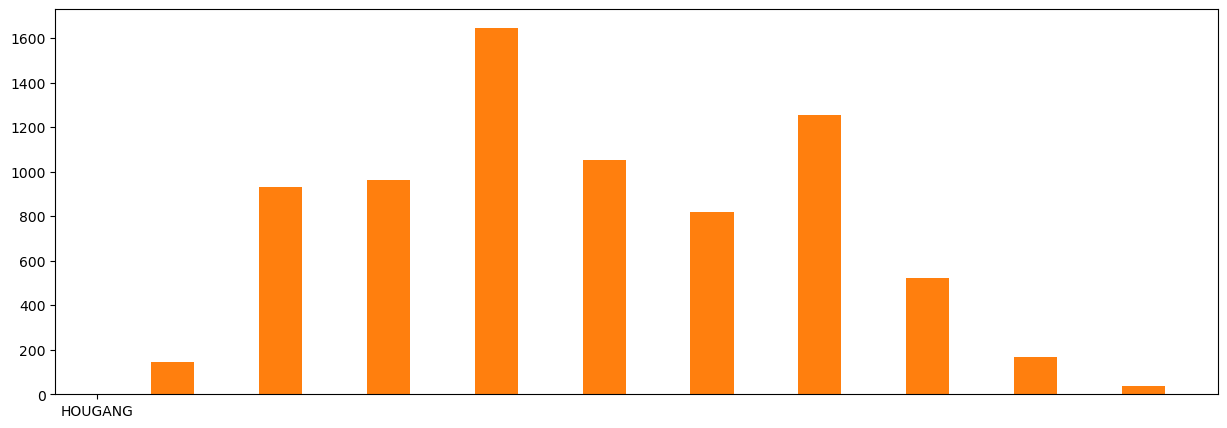

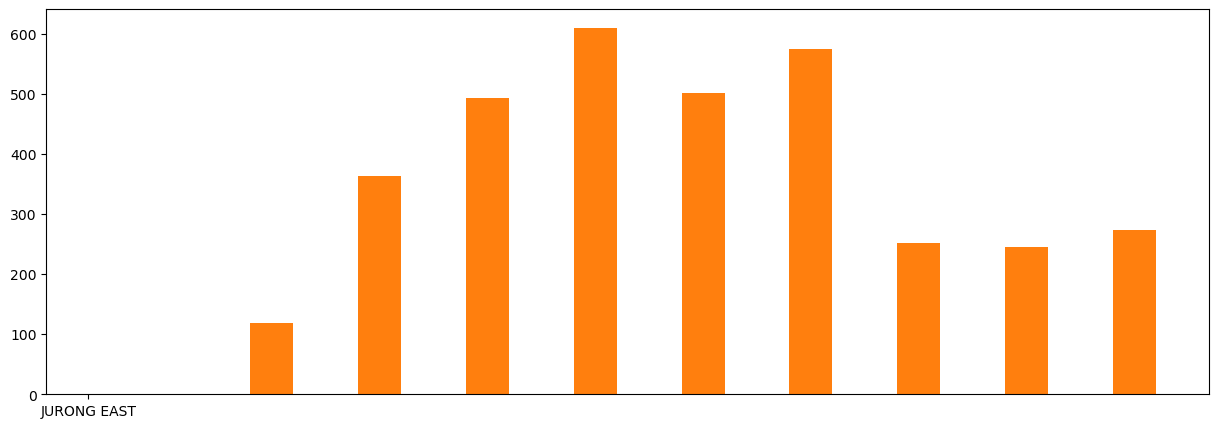

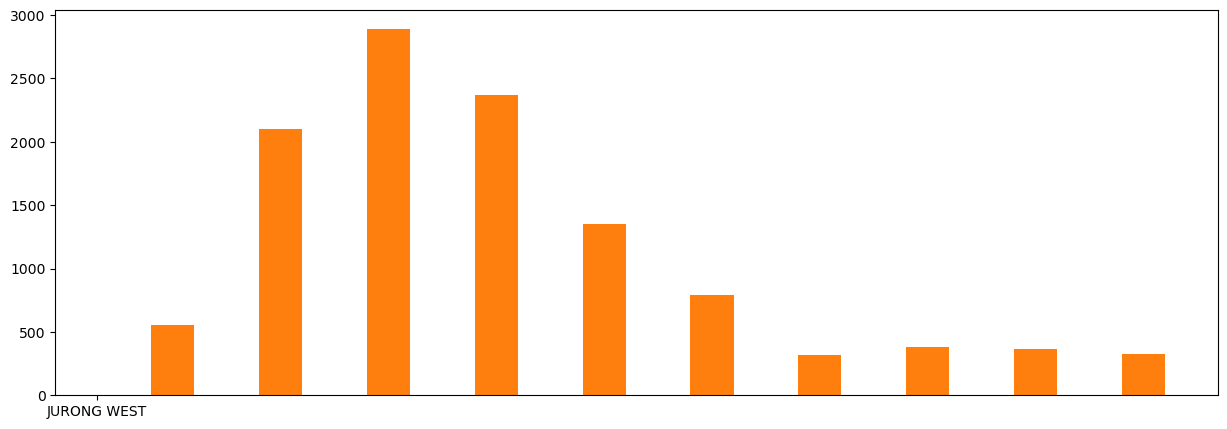

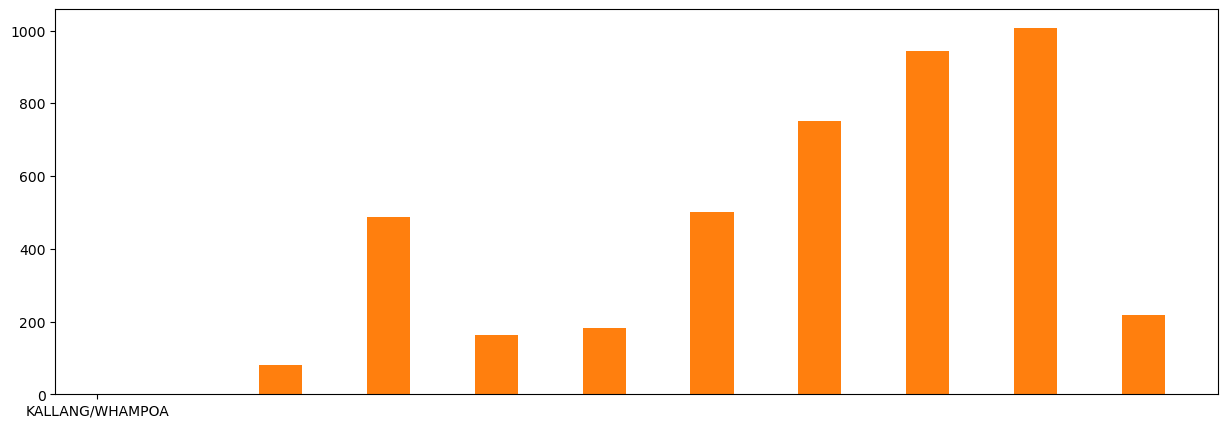

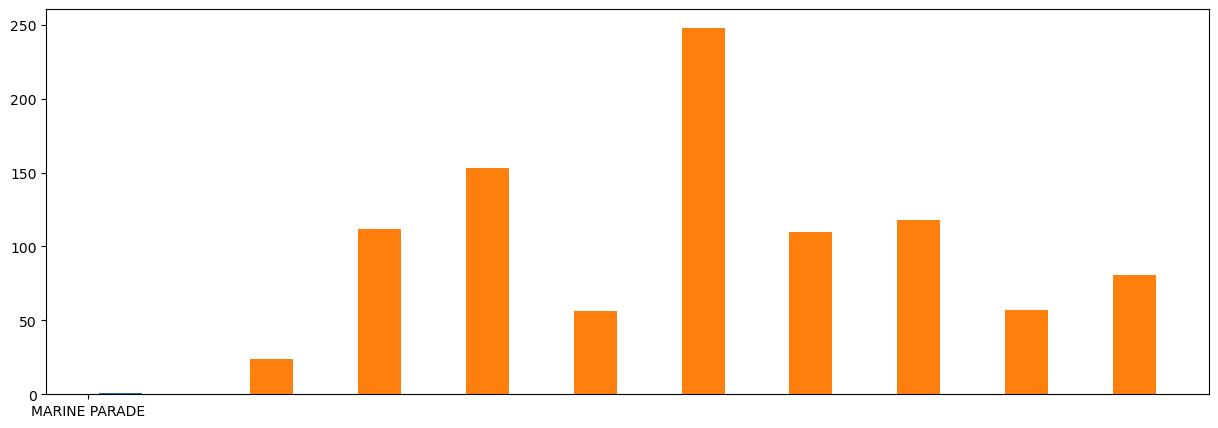

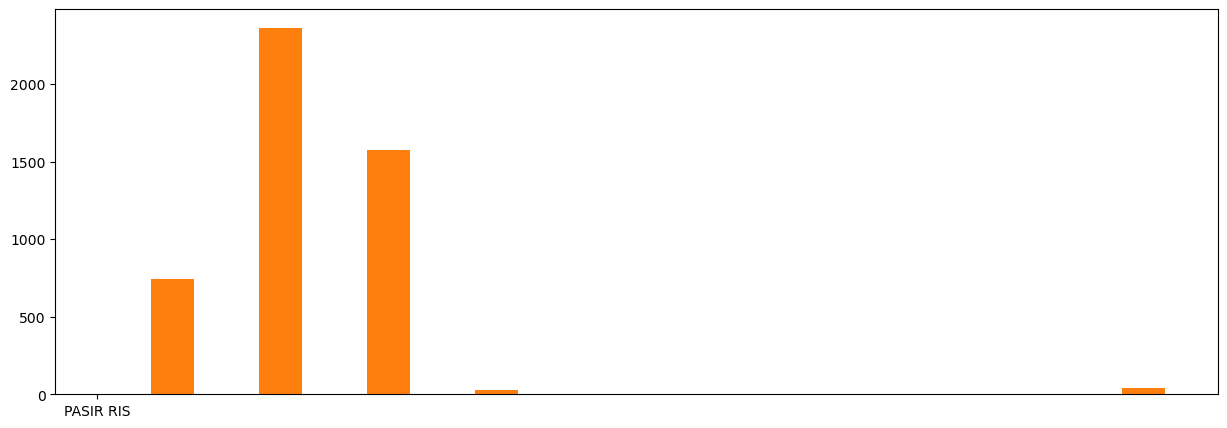

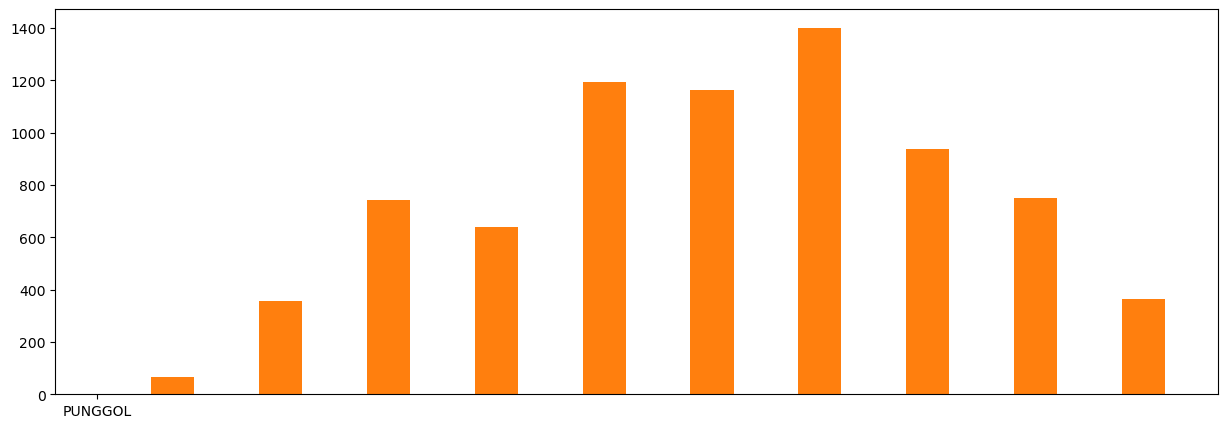

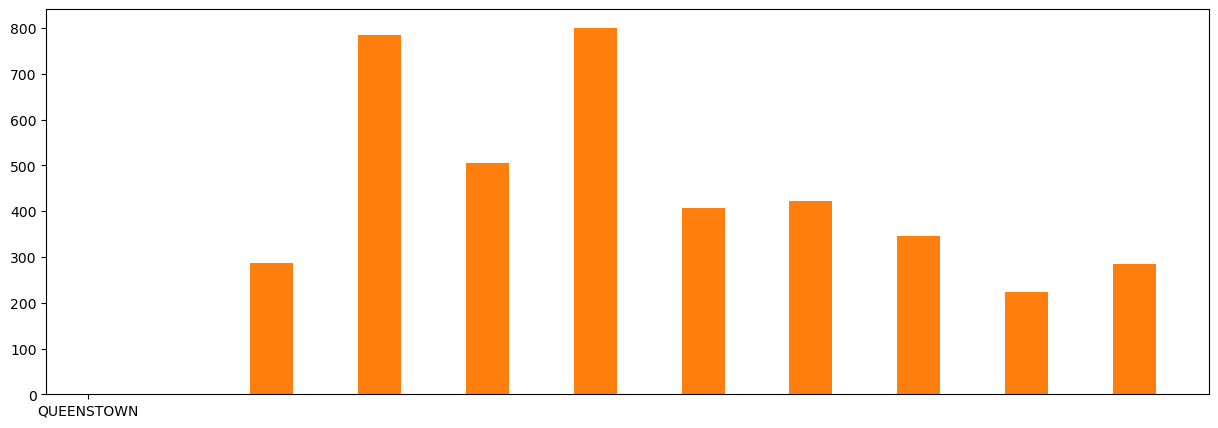

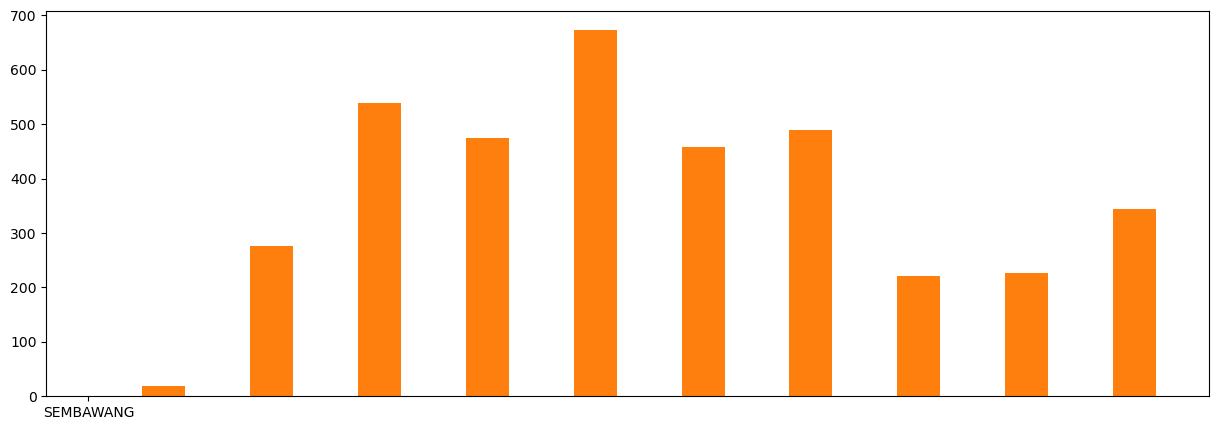

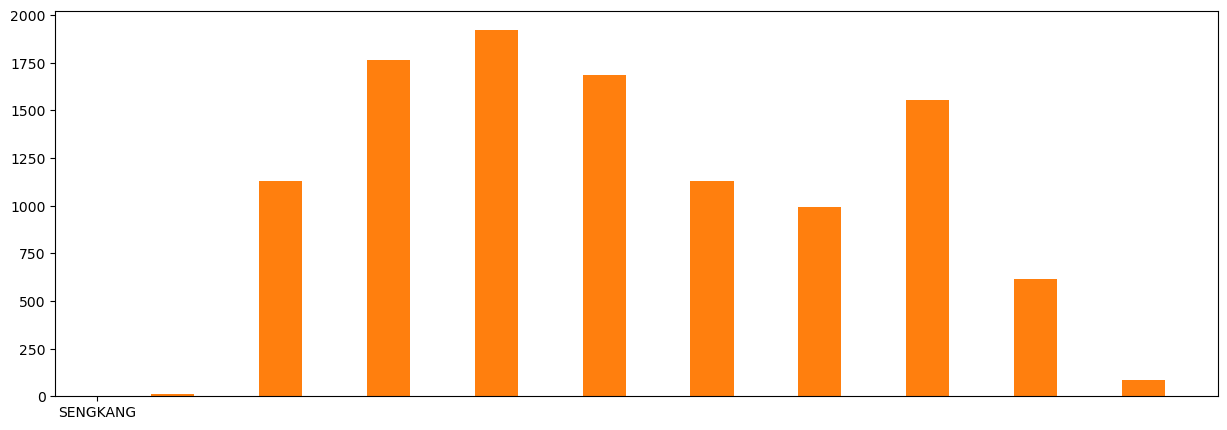

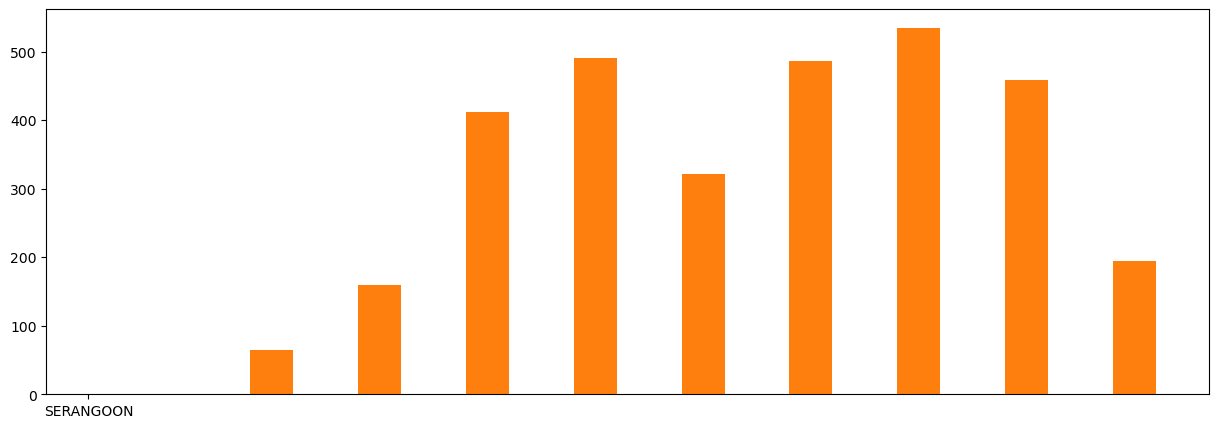

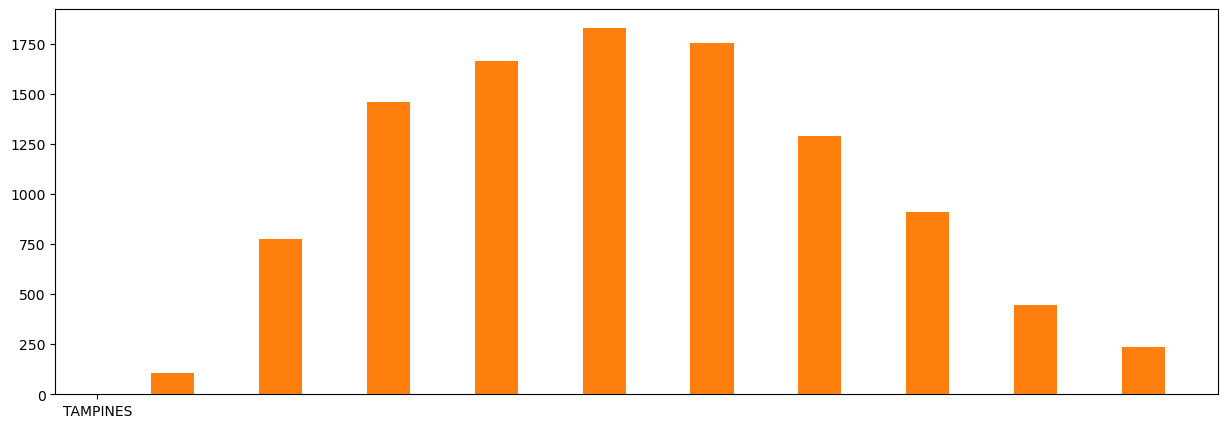

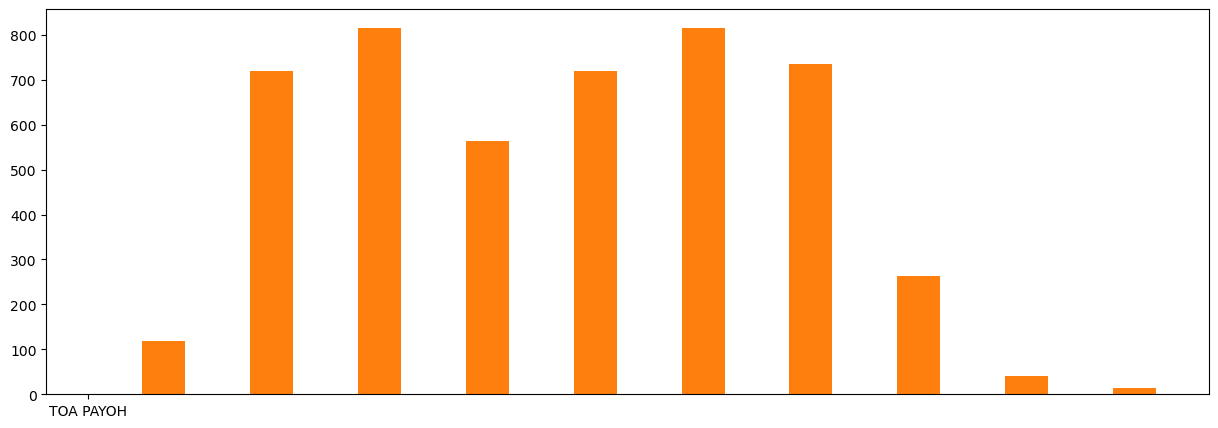

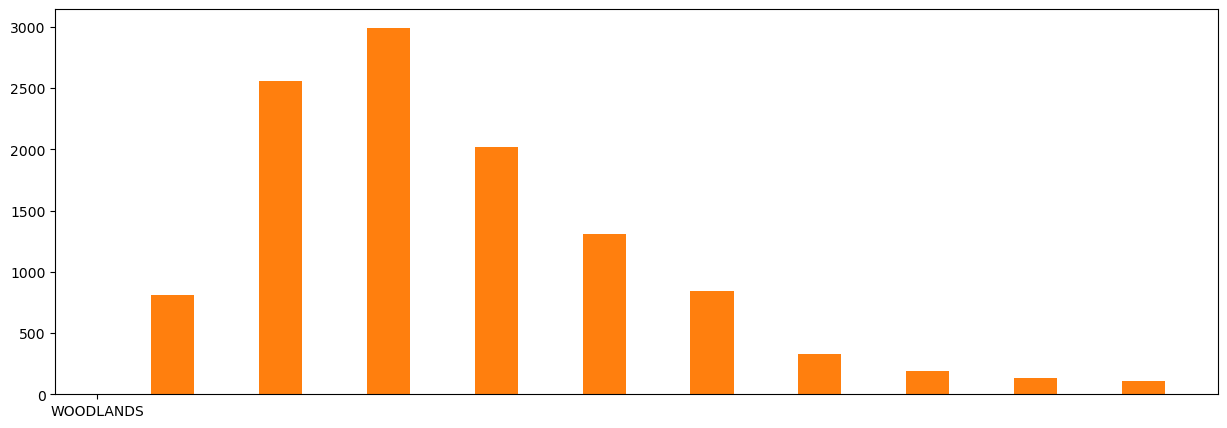

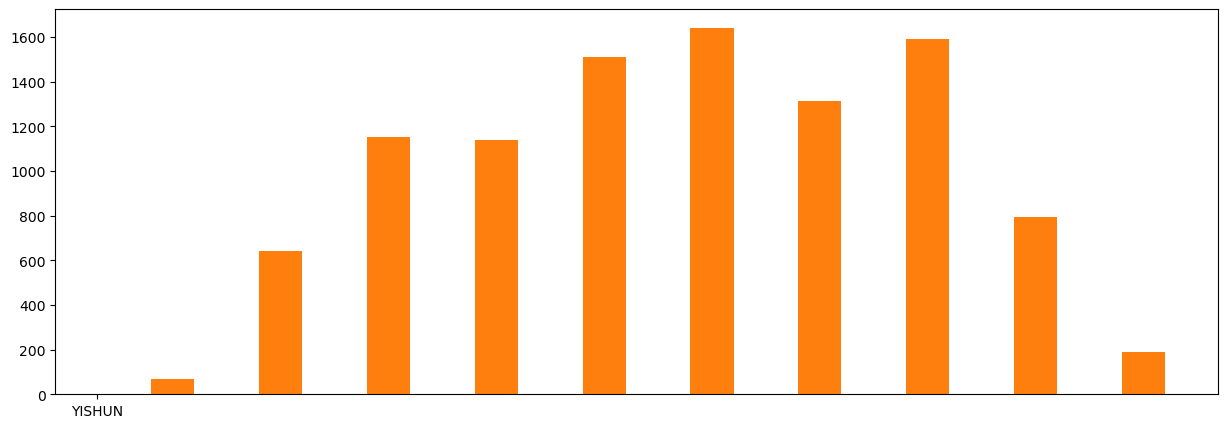

In [181]:
#imputing Mall_Nearest_Distance with median
for i in train_data2.groupby('town')['Mall_Nearest_Distance']:
    plt.figure(figsize=(15,5))
    plt.hist(i)

As distribution seems quite varied, decided to do a median to try and best deal with variance per town.

Decided on median as uncertain on a generalised impact of mean or mode on the overall distribution of each town.

In [28]:
medians = train_data2.groupby('town')['Mall_Nearest_Distance'].median()
median_dict = medians.to_dict()
median_dict

{'ANG MO KIO': 805.04377,
 'BEDOK': 877.0966148,
 'BISHAN': 808.9608457,
 'BUKIT BATOK': 914.9227667,
 'BUKIT MERAH': 703.8234813,
 'BUKIT PANJANG': 445.5837862,
 'BUKIT TIMAH': 546.0905946,
 'CENTRAL AREA': 296.6371084,
 'CHOA CHU KANG': 350.3474912,
 'CLEMENTI': 497.5302318,
 'GEYLANG': 934.433064,
 'HOUGANG': 481.5075301,
 'JURONG EAST': 1064.138494,
 'JURONG WEST': 532.5155387,
 'KALLANG/WHAMPOA': 977.073749,
 'MARINE PARADE': 834.2657118,
 'PASIR RIS': 612.4095684,
 'PUNGGOL': 478.8863446,
 'QUEENSTOWN': 632.7976621,
 'SEMBAWANG': 525.5887744,
 'SENGKANG': 443.5167195,
 'SERANGOON': 663.0534254,
 'TAMPINES': 724.7925346,
 'TOA PAYOH': 790.4915039,
 'WOODLANDS': 484.7332591,
 'YISHUN': 629.3786052}

Checking train_data2 for our second round of regressions later for any na values.

In [61]:
train_data2['Mall_Nearest_Distance'] = train_data2['Mall_Nearest_Distance'].fillna(train_data2.groupby('town')['Mall_Nearest_Distance'].transform('median'))
#could also do train_data2['Mall_Nearest_Distance'] = train_data2['Mall_Nearest_Distance'].fillna(train_data2['Mall_Nearest_Distance'].map(median_dict))
#showing here that there are no nas left
train_data2['Mall_Nearest_Distance'].isna().sum()

0

Checking test_data2 for our second round of regressions later for any na values.

In [62]:
test_data2['Mall_Nearest_Distance'] = test_data2['Mall_Nearest_Distance'].fillna(test_data2.groupby('town')['Mall_Nearest_Distance'].transform('median'))
#could also do test_data['Mall_Nearest_Distance'] = test_data['Mall_Nearest_Distance'].fillna(train_data2['Mall_Nearest_Distance'].map(median_dict))
#showing here that there are no nas left
test_data2['Mall_Nearest_Distance'].isna().sum()

0

#### Postal code

As street_name and bus_stop_name have a high impact on the coeffs observed in default ridge regression, decided to use postal code this time as a number related to towns. (https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm)

In [63]:
train_data2['postal_number'] = train_data2['postal'].astype(str).apply(lambda x : x[0:2])
#Have not dealt with NIL
train_data2['postal_number'].unique()

array(['38', '57', '65', '76', '53', '47', '54', '52', '55', '16', '67',
       '73', '79', '37', '64', '31', '61', '68', '75', '32', '33', '56',
       '10', '35', '40', '51', '21', '12', '82', '60', '46', '41', '20',
       '27', '39', '15', '59', '14', '90', '13', '58', '43', '26', '19',
       '80', '36', 'NI', '85', '44', '81', '50', '66', '18', '91', '42',
       '30'], dtype=object)

In [64]:
test_data2['postal_number'] = test_data2['postal'].astype(str).apply(lambda x : x[0:2])
#Have not dealt with NIL
test_data2['postal_number'].unique()

array(['76', '64', '56', '73', '65', '46', '82', '32', '68', '14', '10',
       '60', '52', '54', '37', '13', '51', '12', '44', '90', '53', '75',
       '39', '27', '15', '67', '31', '35', '61', '55', '16', '79', '47',
       '57', '81', '40', '21', '38', '19', '26', '41', '43', '33', '80',
       '85', '18', '30', '50', '36', '66', '91', '59', '20', '42', 'NI',
       '58'], dtype=object)

Found alot of NIL values which were unaccounted for used them to flag out the missing postal_numbers and the corresponding street_names, used the street_name to impute the postal code.

In [65]:
train_data2[train_data2['postal_number'] == "NI"].shape[0]

33

In [66]:
test_data2[test_data2['postal_number'] == "NI"].shape[0]

2

In [68]:
test_data2[test_data2['postal_number'] == "NI"].groupby('postal_number')['street_name'].value_counts()

postal_number  street_name     
NI             COMPASSVALE WALK    2
Name: street_name, dtype: int64

In [69]:
train_data2[train_data2['postal_number'] == "NI"].groupby('postal_number')['street_name'].value_counts()

postal_number  street_name       
NI             COMPASSVALE WALK      27
               CHOA CHU KANG CTRL     6
Name: street_name, dtype: int64

In [70]:
train_data2[train_data2['street_name'] == "COMPASSVALE WALK"].groupby('postal_number')['street_name'].value_counts()
#change all that are COMPASSVALE WALK to 54

postal_number  street_name     
54             COMPASSVALE WALK    360
NI             COMPASSVALE WALK     27
Name: street_name, dtype: int64

In [71]:
test_data2[test_data2['street_name'] == "COMPASSVALE WALK"].groupby('postal_number')['street_name'].value_counts()
#change all that are COMPASSVALE WALK to 54

postal_number  street_name     
54             COMPASSVALE WALK    39
NI             COMPASSVALE WALK     2
Name: street_name, dtype: int64

In [72]:
train_data2[train_data2['street_name'] == "CHOA CHU KANG CTRL"].groupby('postal_number')['street_name'].value_counts()
#change all that are CHOA CHU KANG CTRL to 68

postal_number  street_name       
68             CHOA CHU KANG CTRL    381
NI             CHOA CHU KANG CTRL      6
Name: street_name, dtype: int64

Repeating the change for both train_data2 and test_data2

In [73]:
# replace_dict = {68 : 'CHOA CHU KANG CTRL', 54: 'COMPASSVALE WALK'}
train_data2.loc[(train_data2['street_name'] == 'COMPASSVALE WALK') & (train_data2['postal_number'] == 'NI'), 'postal_number'] = 54
train_data2.loc[(train_data2['street_name'] == 'CHOA CHU KANG CTRL') & (train_data2['postal_number'] == 'NI'), 'postal_number'] = 68


In [74]:
test_data2.loc[(test_data2['street_name'] == 'COMPASSVALE WALK') & (test_data2['postal_number'] == 'NI'), 'postal_number'] = 54
test_data2.loc[(test_data2['street_name'] == 'CHOA CHU KANG CTRL') & (test_data2['postal_number'] == 'NI'), 'postal_number'] = 68

In [75]:
train_data2['postal_number'].unique()

array(['38', '57', '65', '76', '53', '47', '54', '52', '55', '16', '67',
       '73', '79', '37', '64', '31', '61', '68', '75', '32', '33', '56',
       '10', '35', '40', '51', '21', '12', '82', '60', '46', '41', '20',
       '27', '39', '15', '59', '14', '90', '13', '58', '43', '26', '19',
       '80', '36', 68, '85', '44', '81', '50', '66', '18', 54, '91', '42',
       '30'], dtype=object)

In [76]:
train_data2['postal_number'].astype('int64')

0         38
1         57
2         65
3         57
4         76
          ..
150629    73
150630    64
150631    41
150632    27
150633    76
Name: postal_number, Length: 150634, dtype: int64

In [77]:
test_data2['postal_number'].unique()

array(['76', '64', '56', '73', '65', '46', '82', '32', '68', '14', '10',
       '60', '52', '54', '37', '13', '51', '12', '44', '90', '53', '75',
       '39', '27', '15', '67', '31', '35', '61', '55', '16', '79', '47',
       '57', '81', '40', '21', '38', '19', '26', '41', '43', '33', '80',
       '85', '18', '30', '50', '36', '66', '91', '59', '20', '42', 54,
       '58'], dtype=object)

In [78]:
test_data2['postal_number'].astype('int64')

0        76
1        64
2        56
3        73
4        65
         ..
16732    56
16733    82
16734    68
16735    57
16736    61
Name: postal_number, Length: 16737, dtype: int64

#### Taking a look at boxplots for all non-numerical features.

Below are boxplots of all the non-numeric features. Most distributions are very varied, but we can say for sure that the bus_stop_names feature is a potential cause for concern regaridng computational limitations.

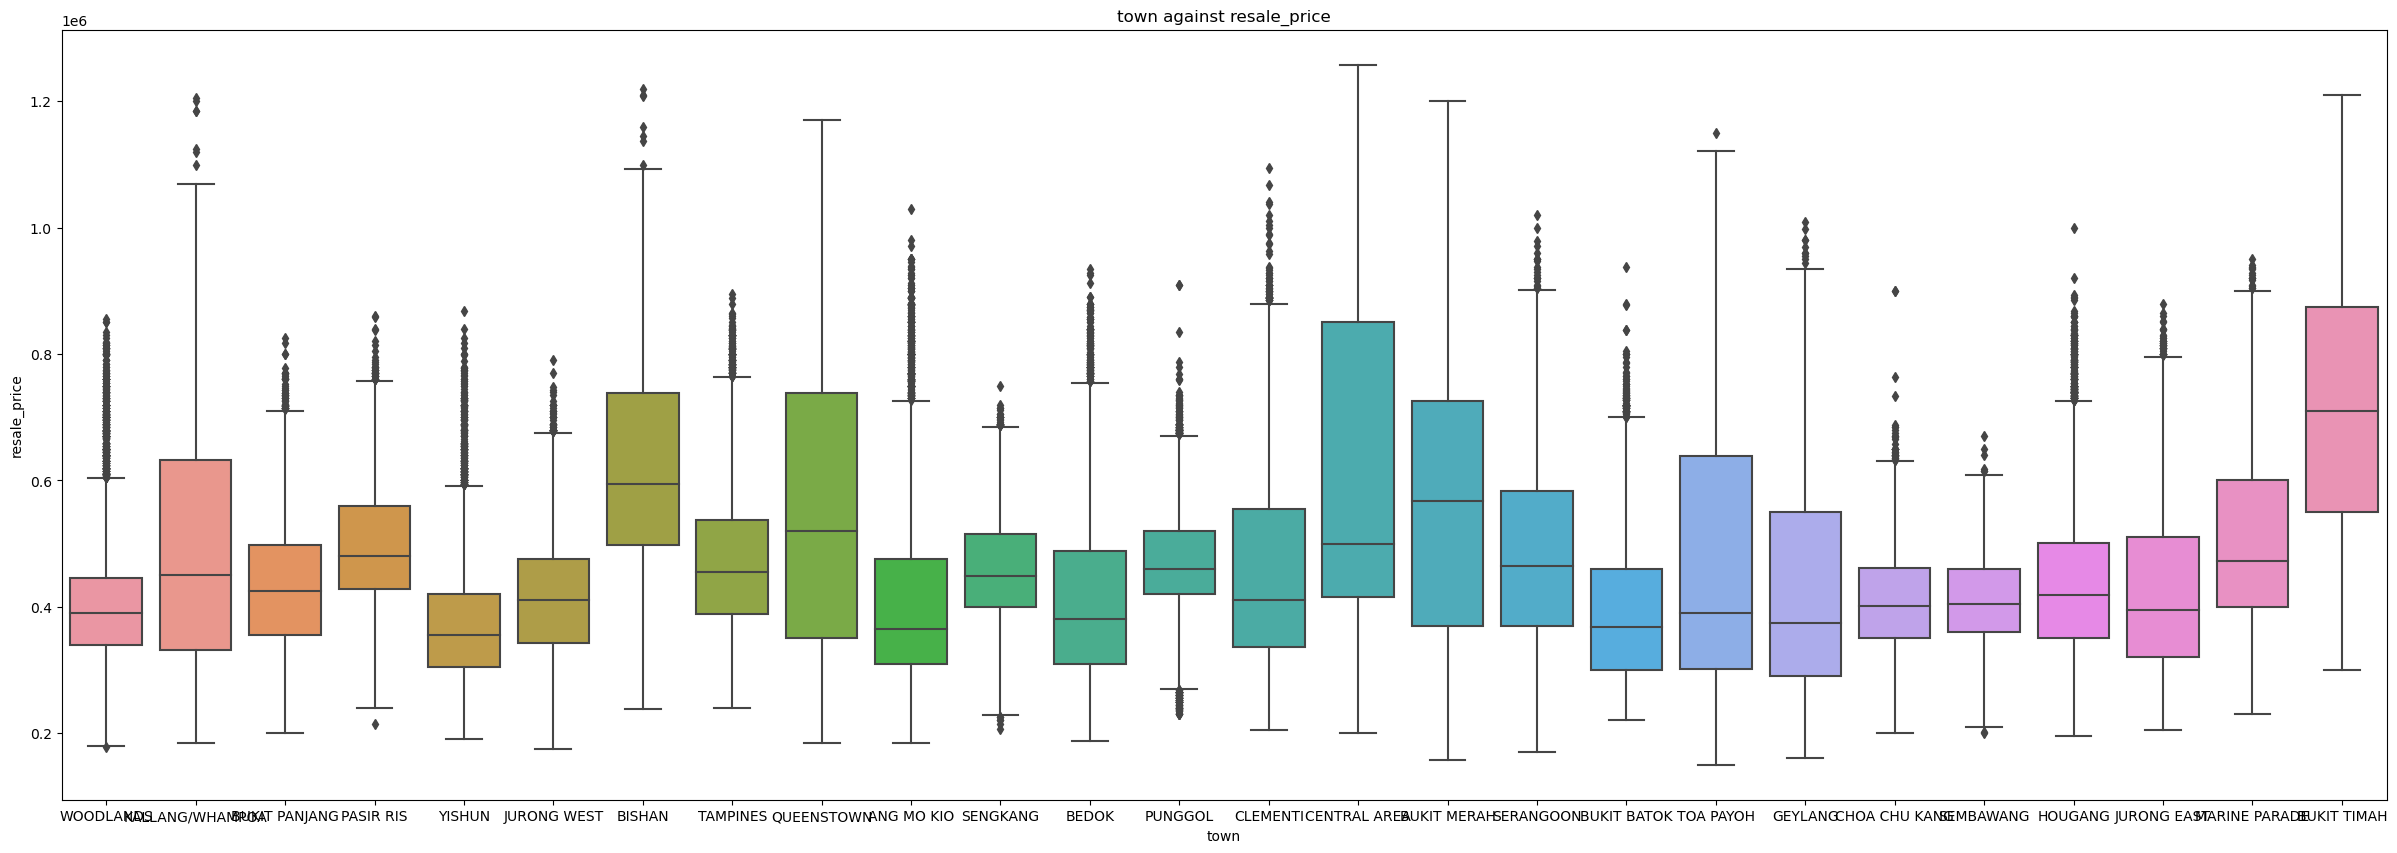

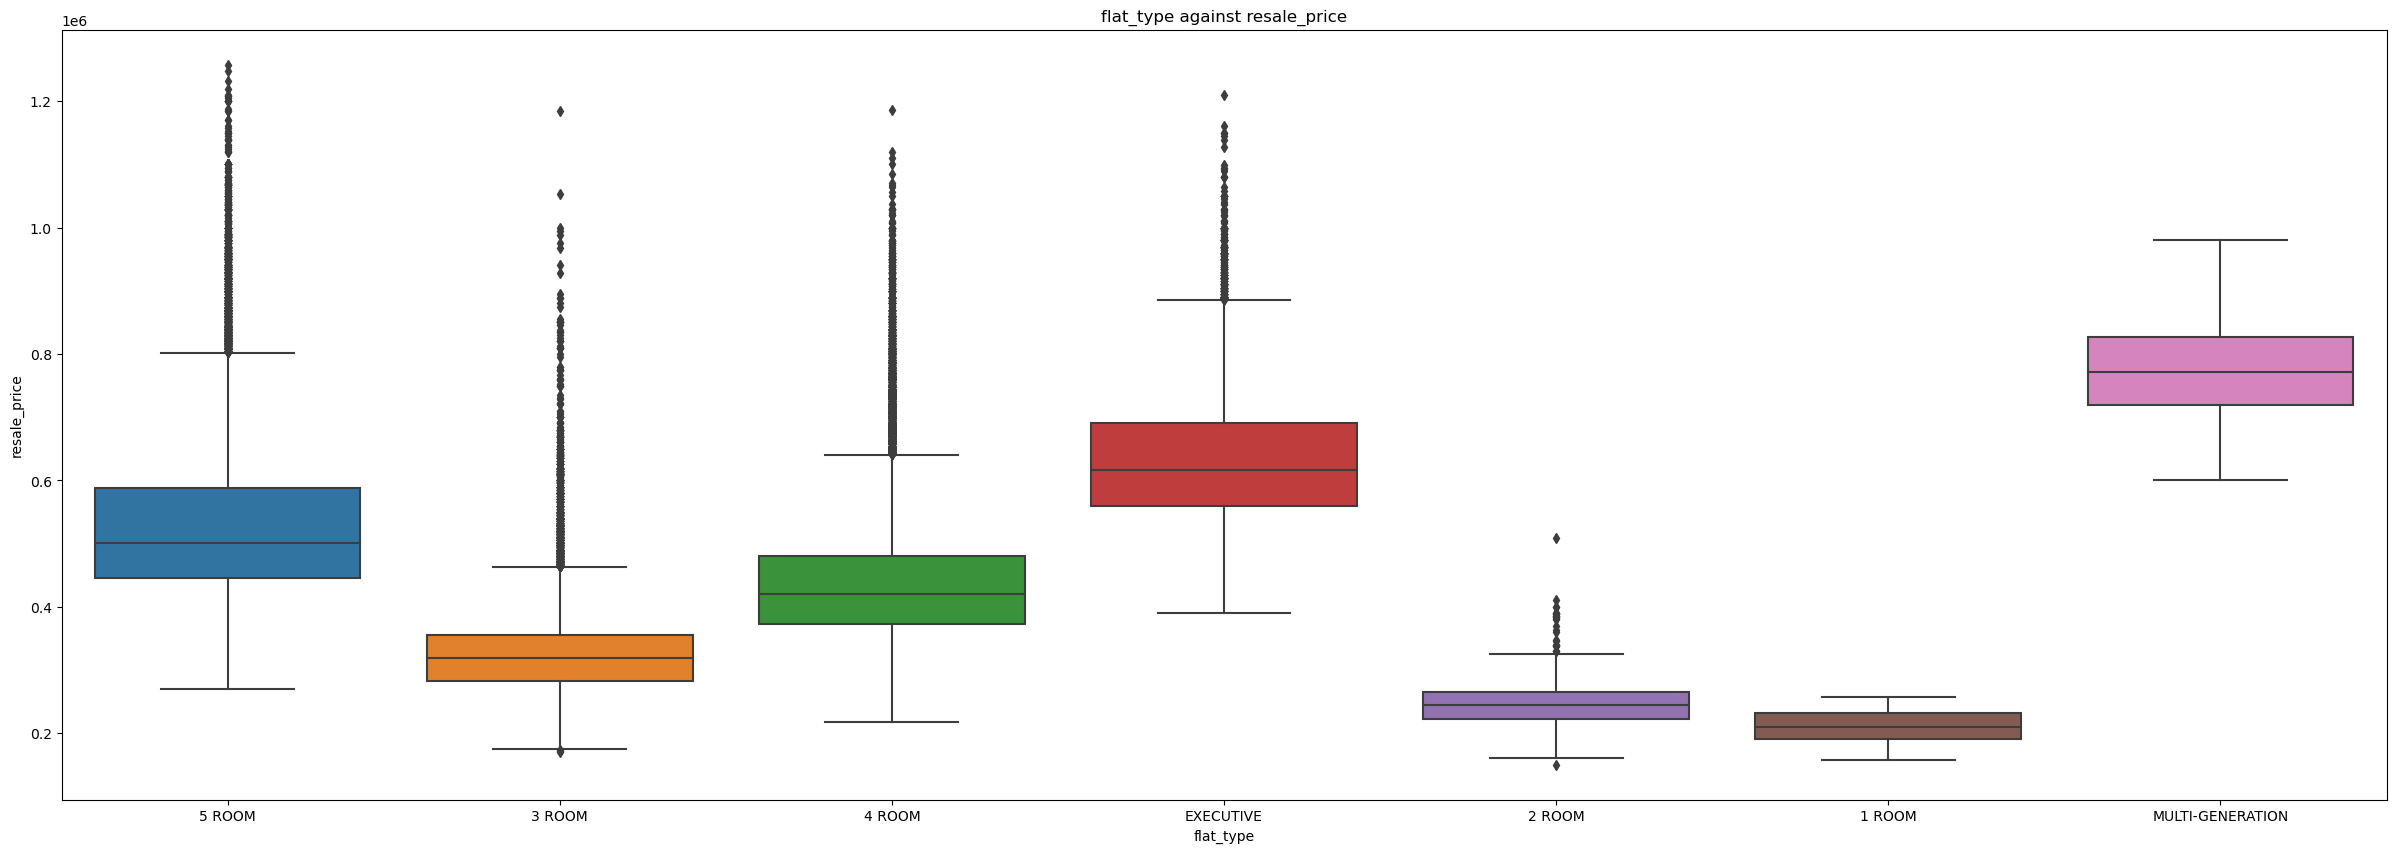

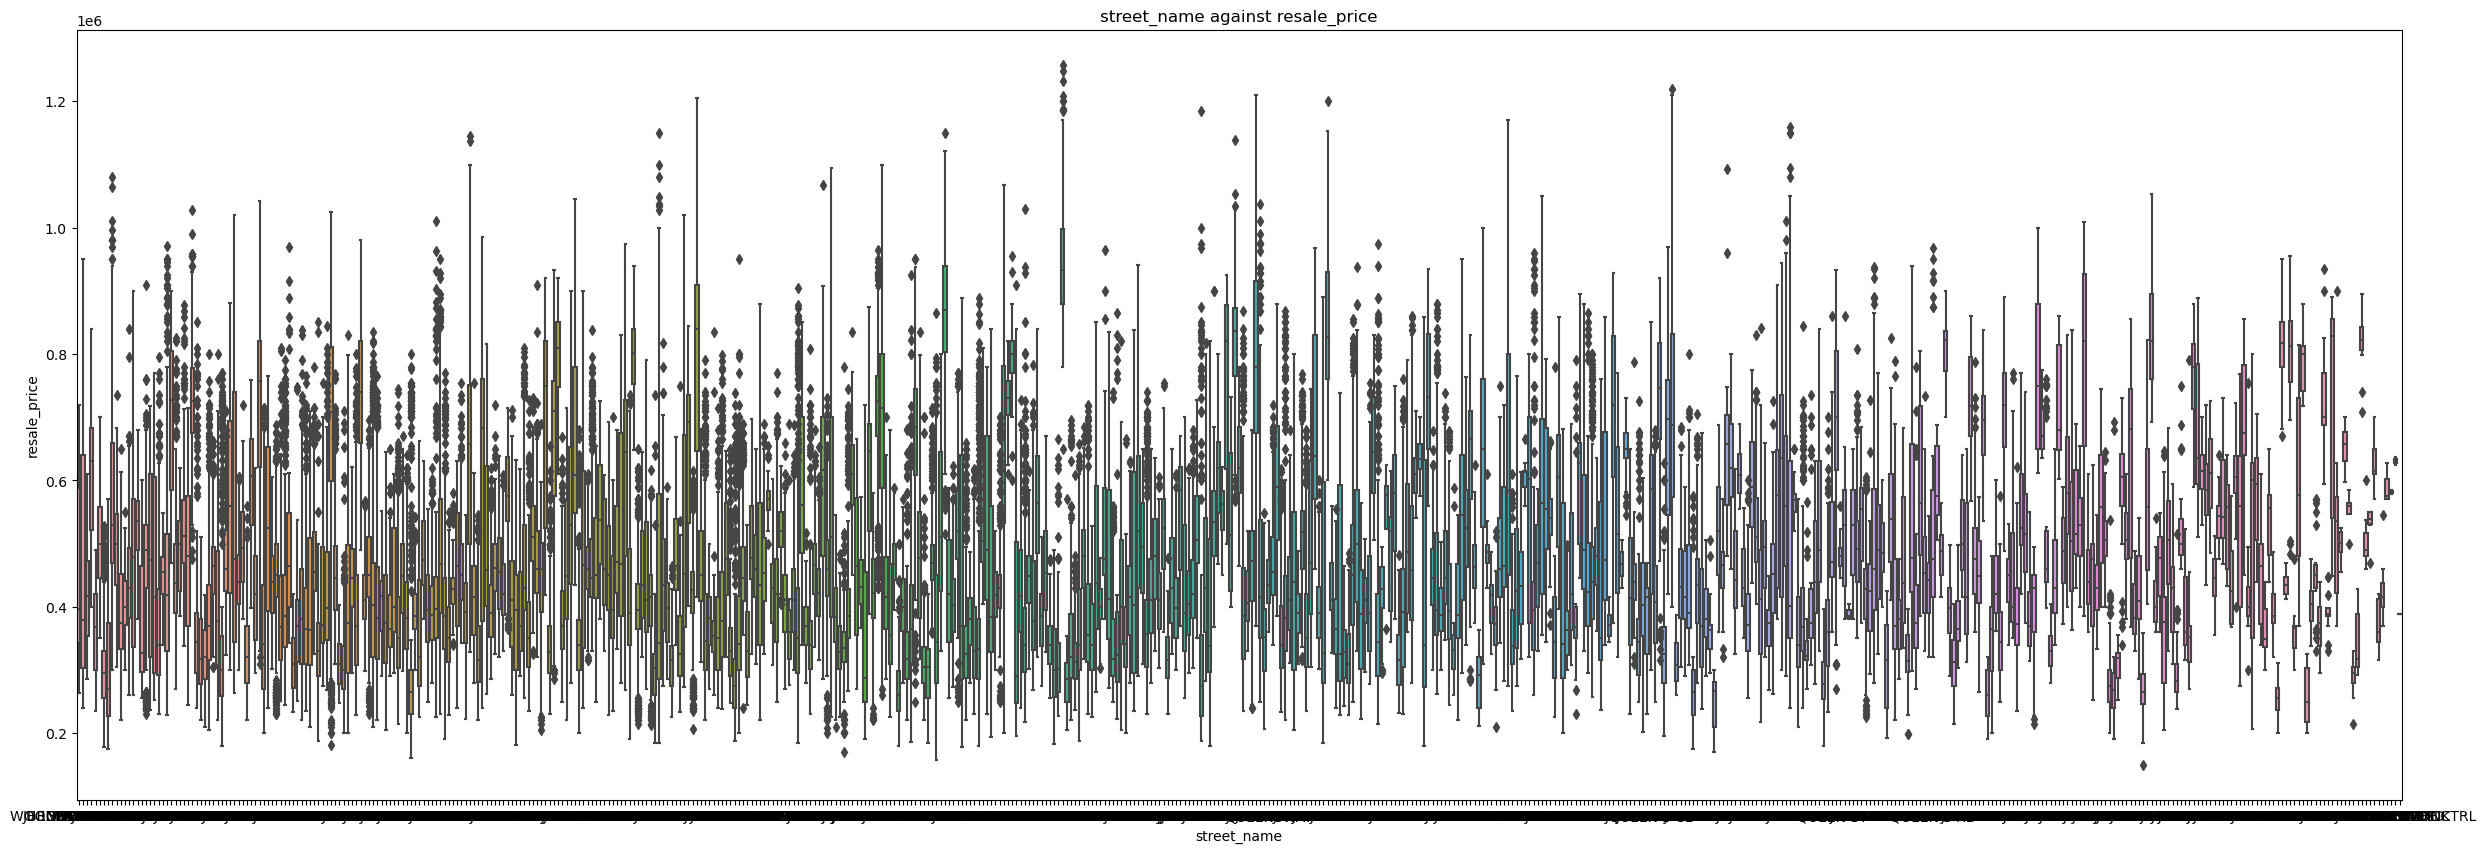

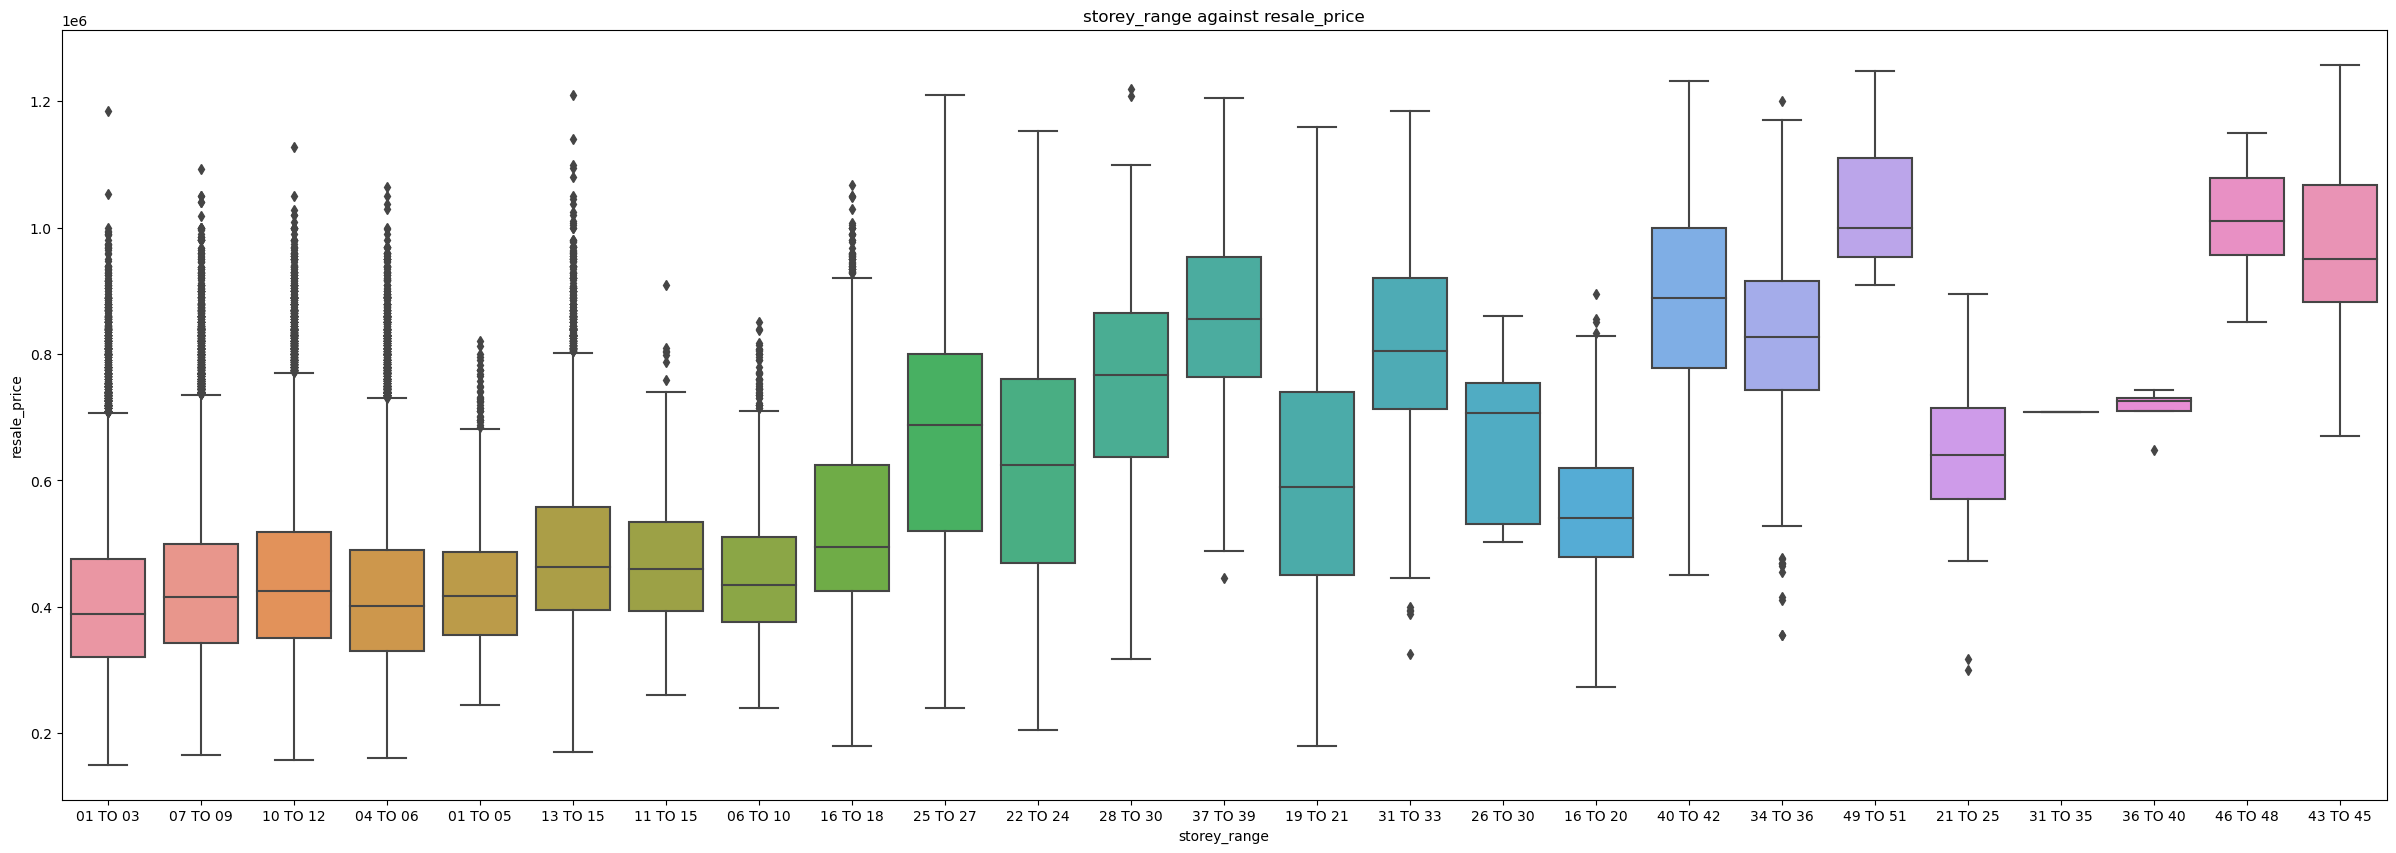

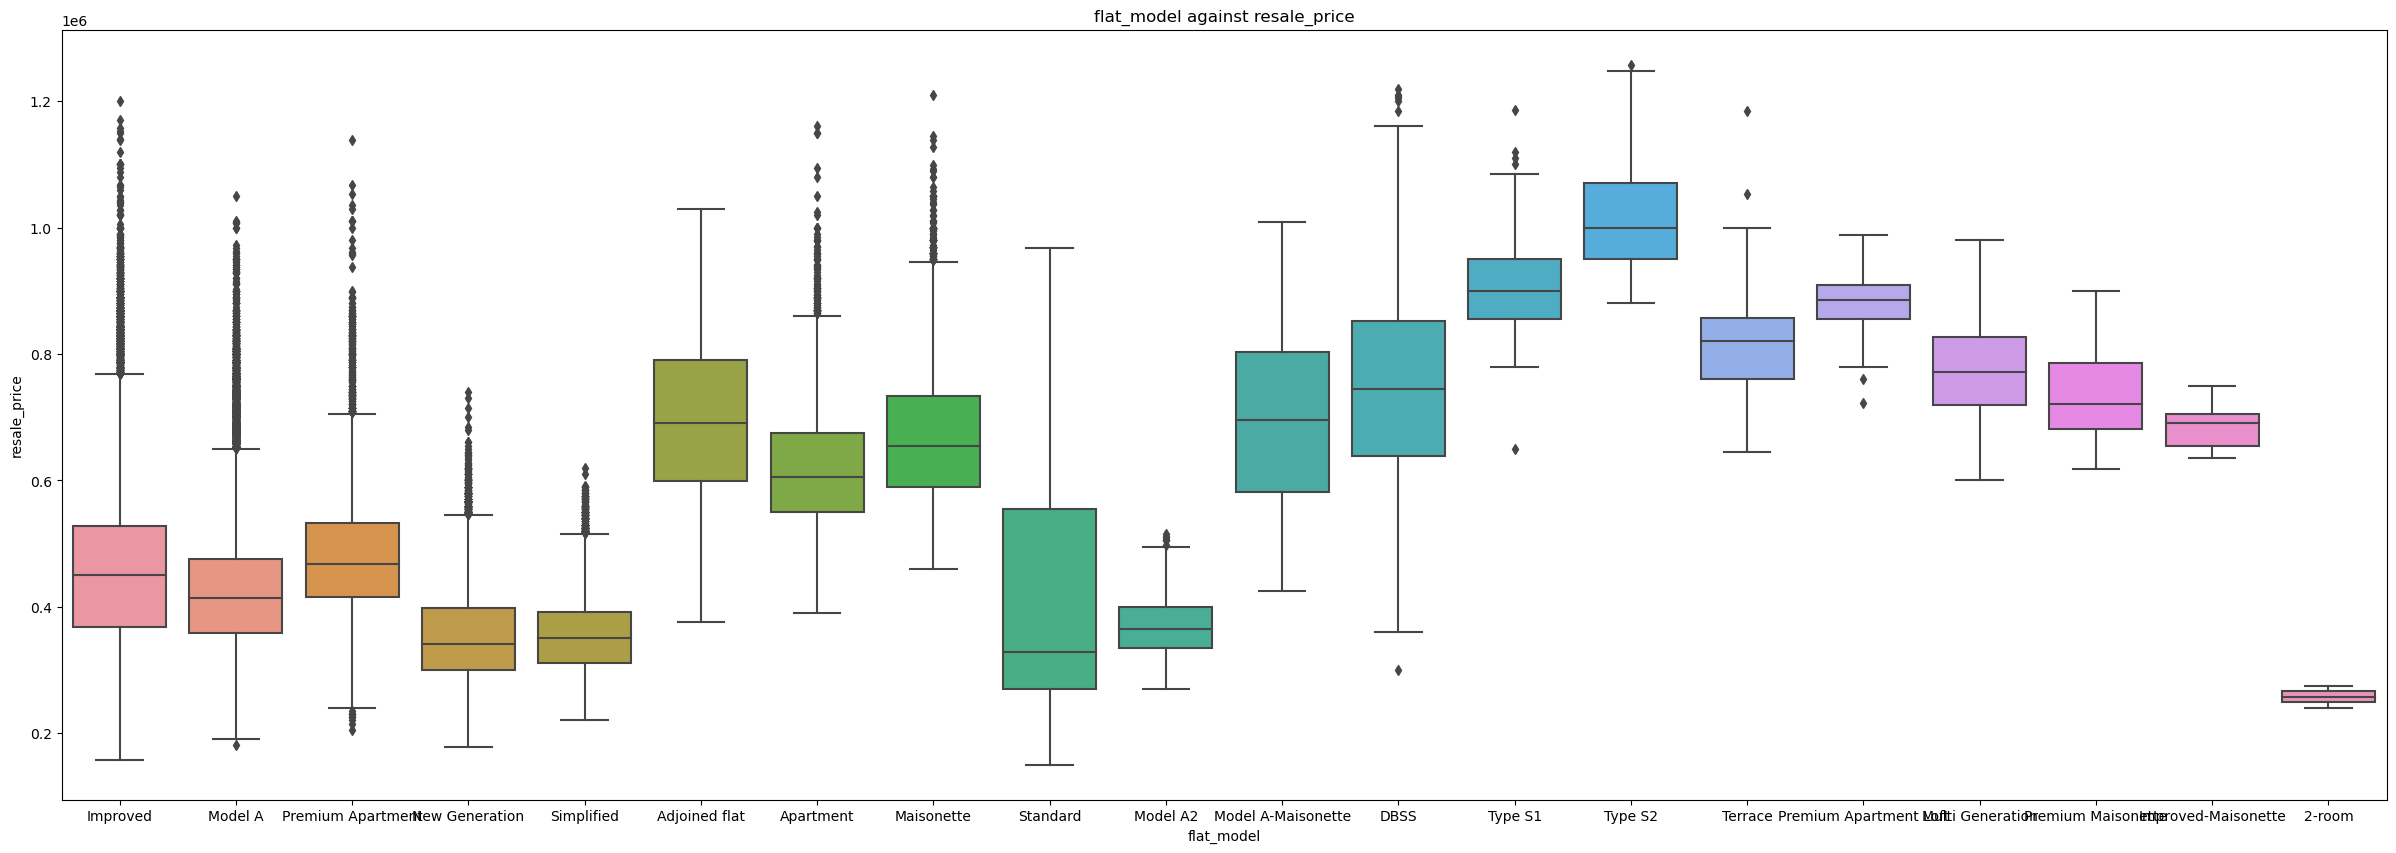

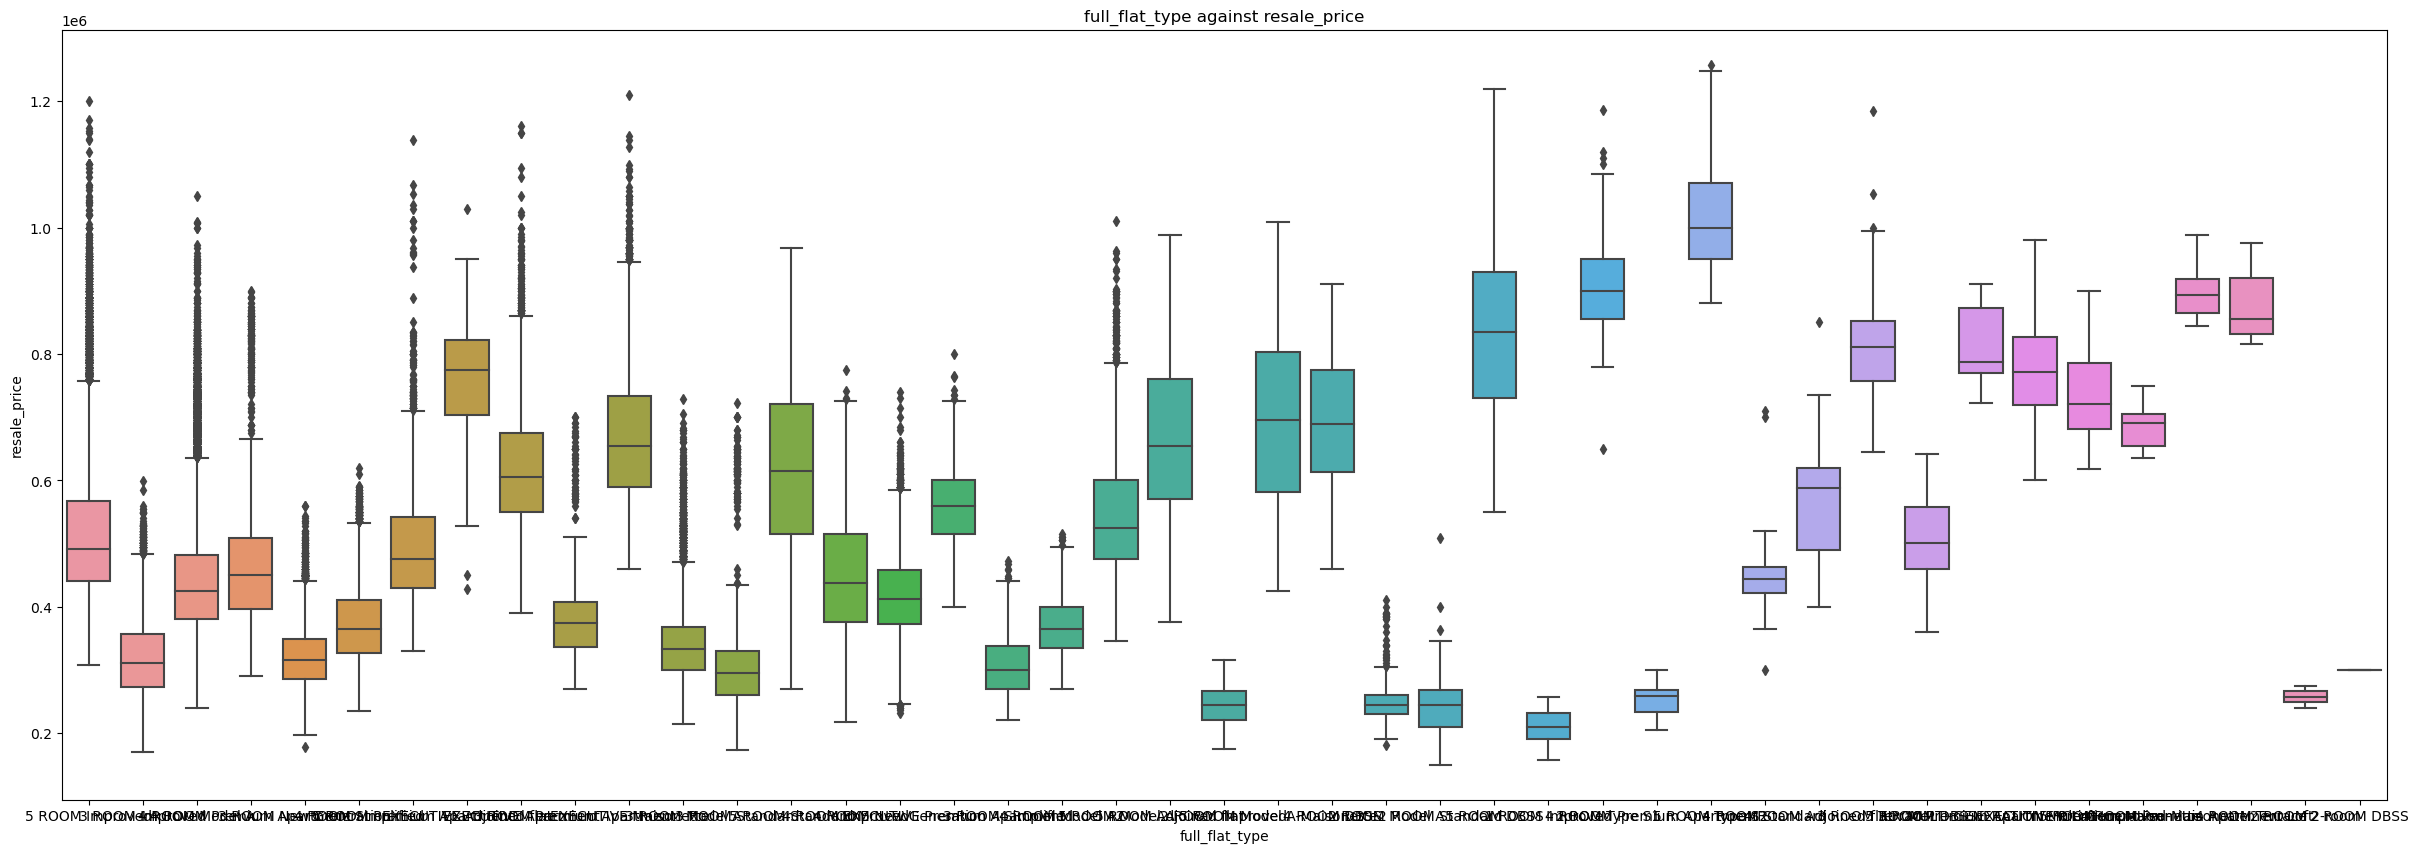

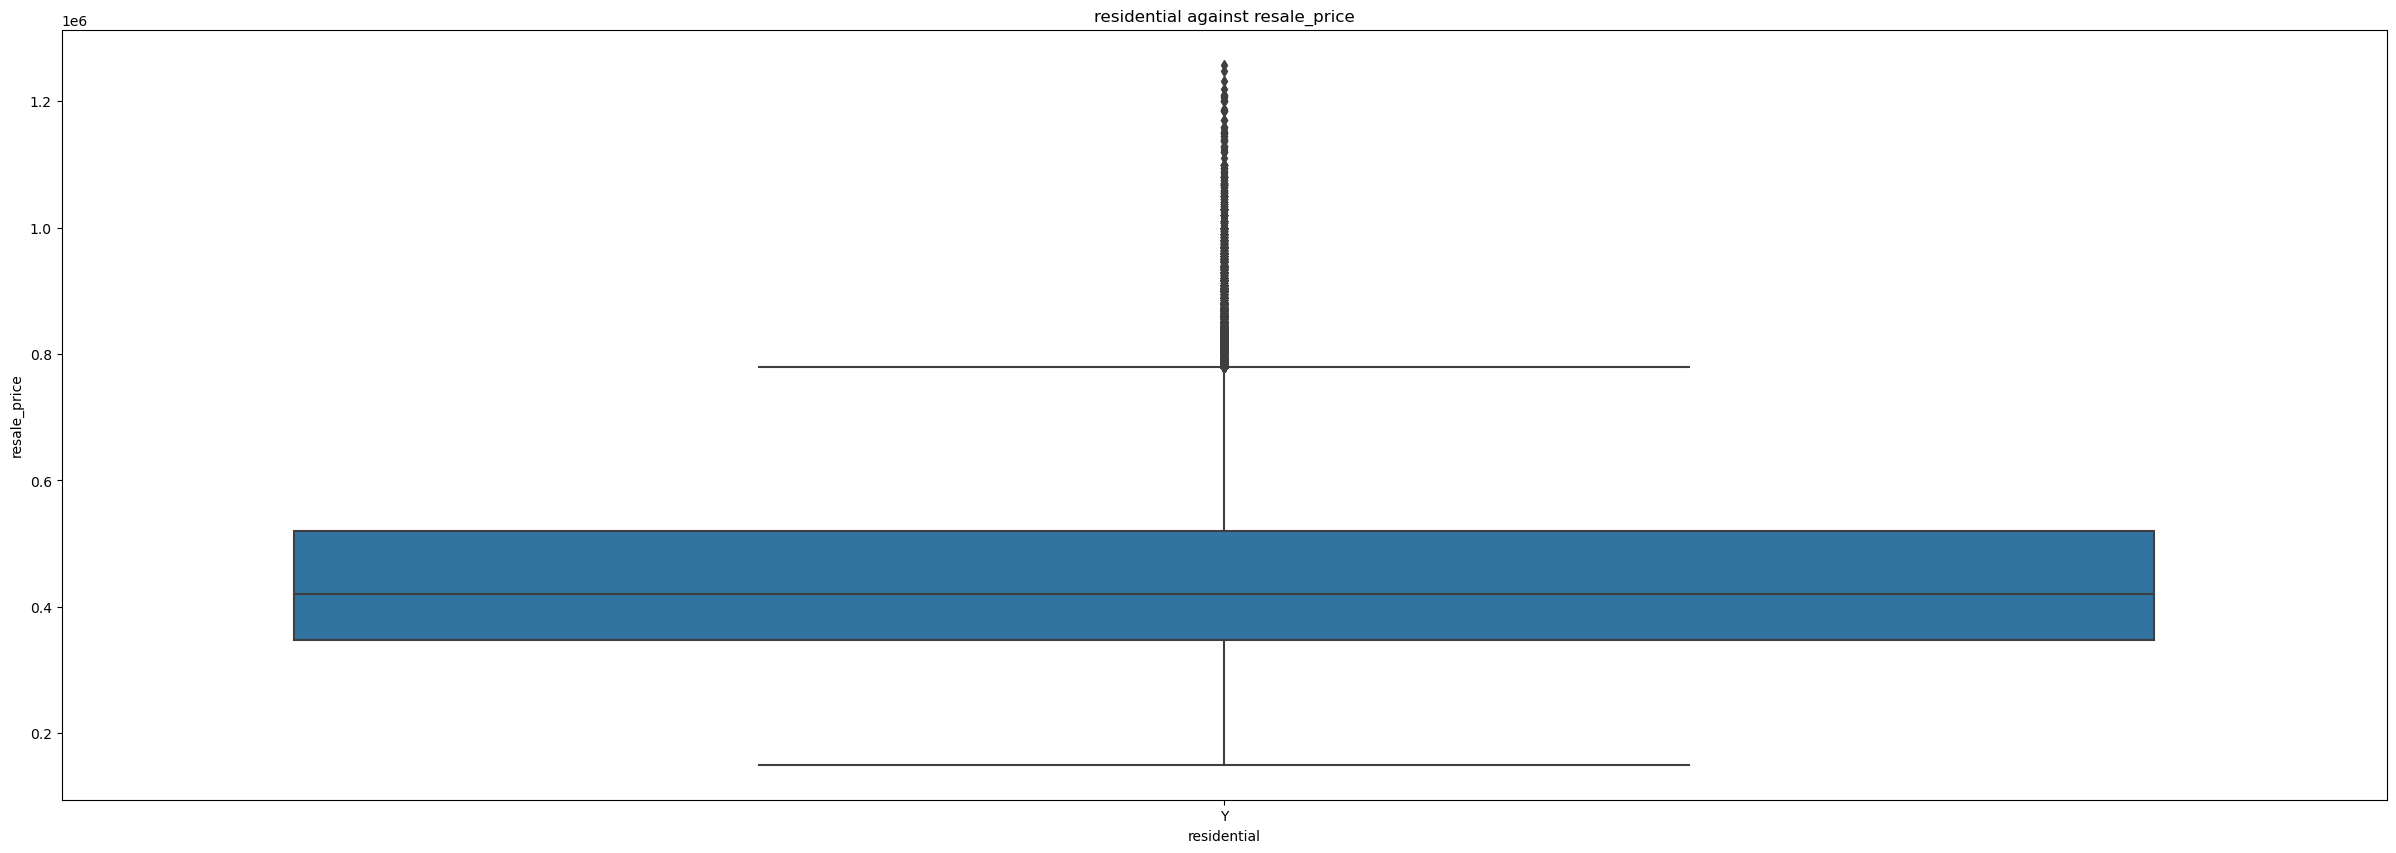

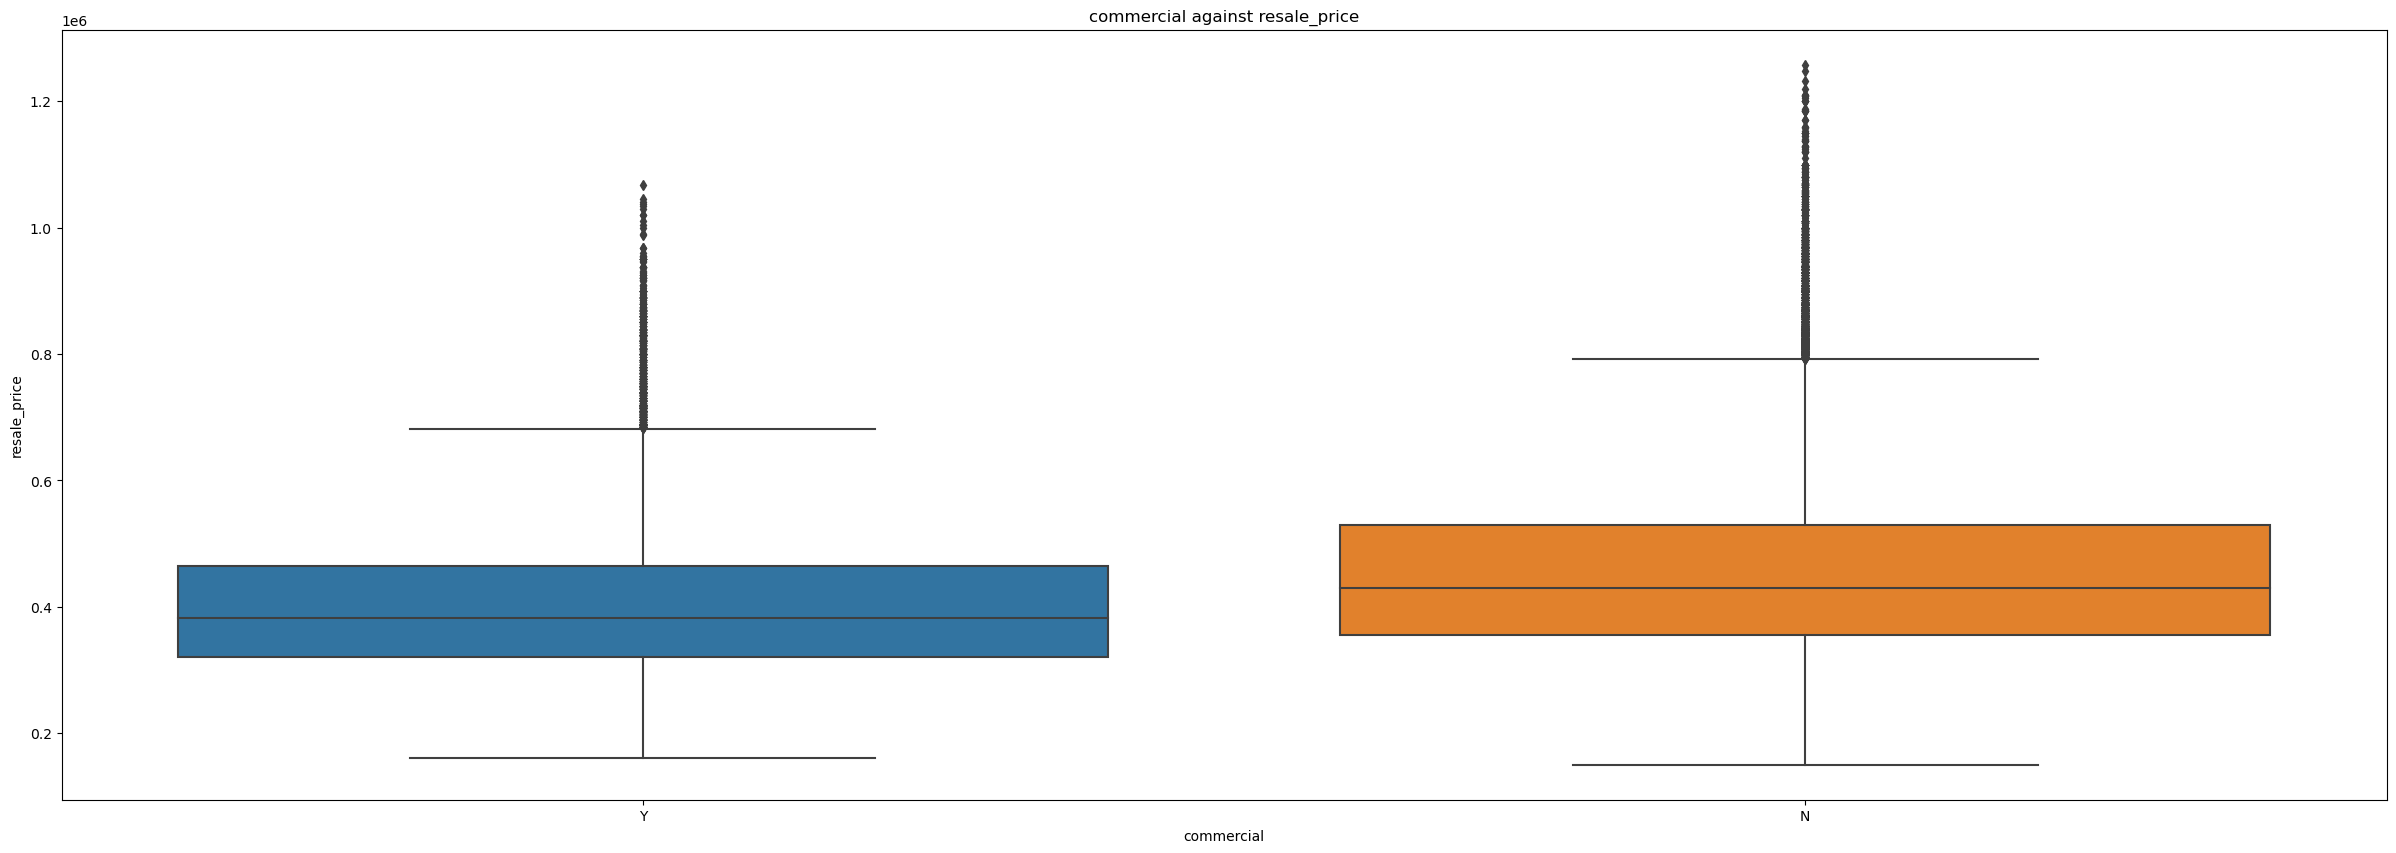

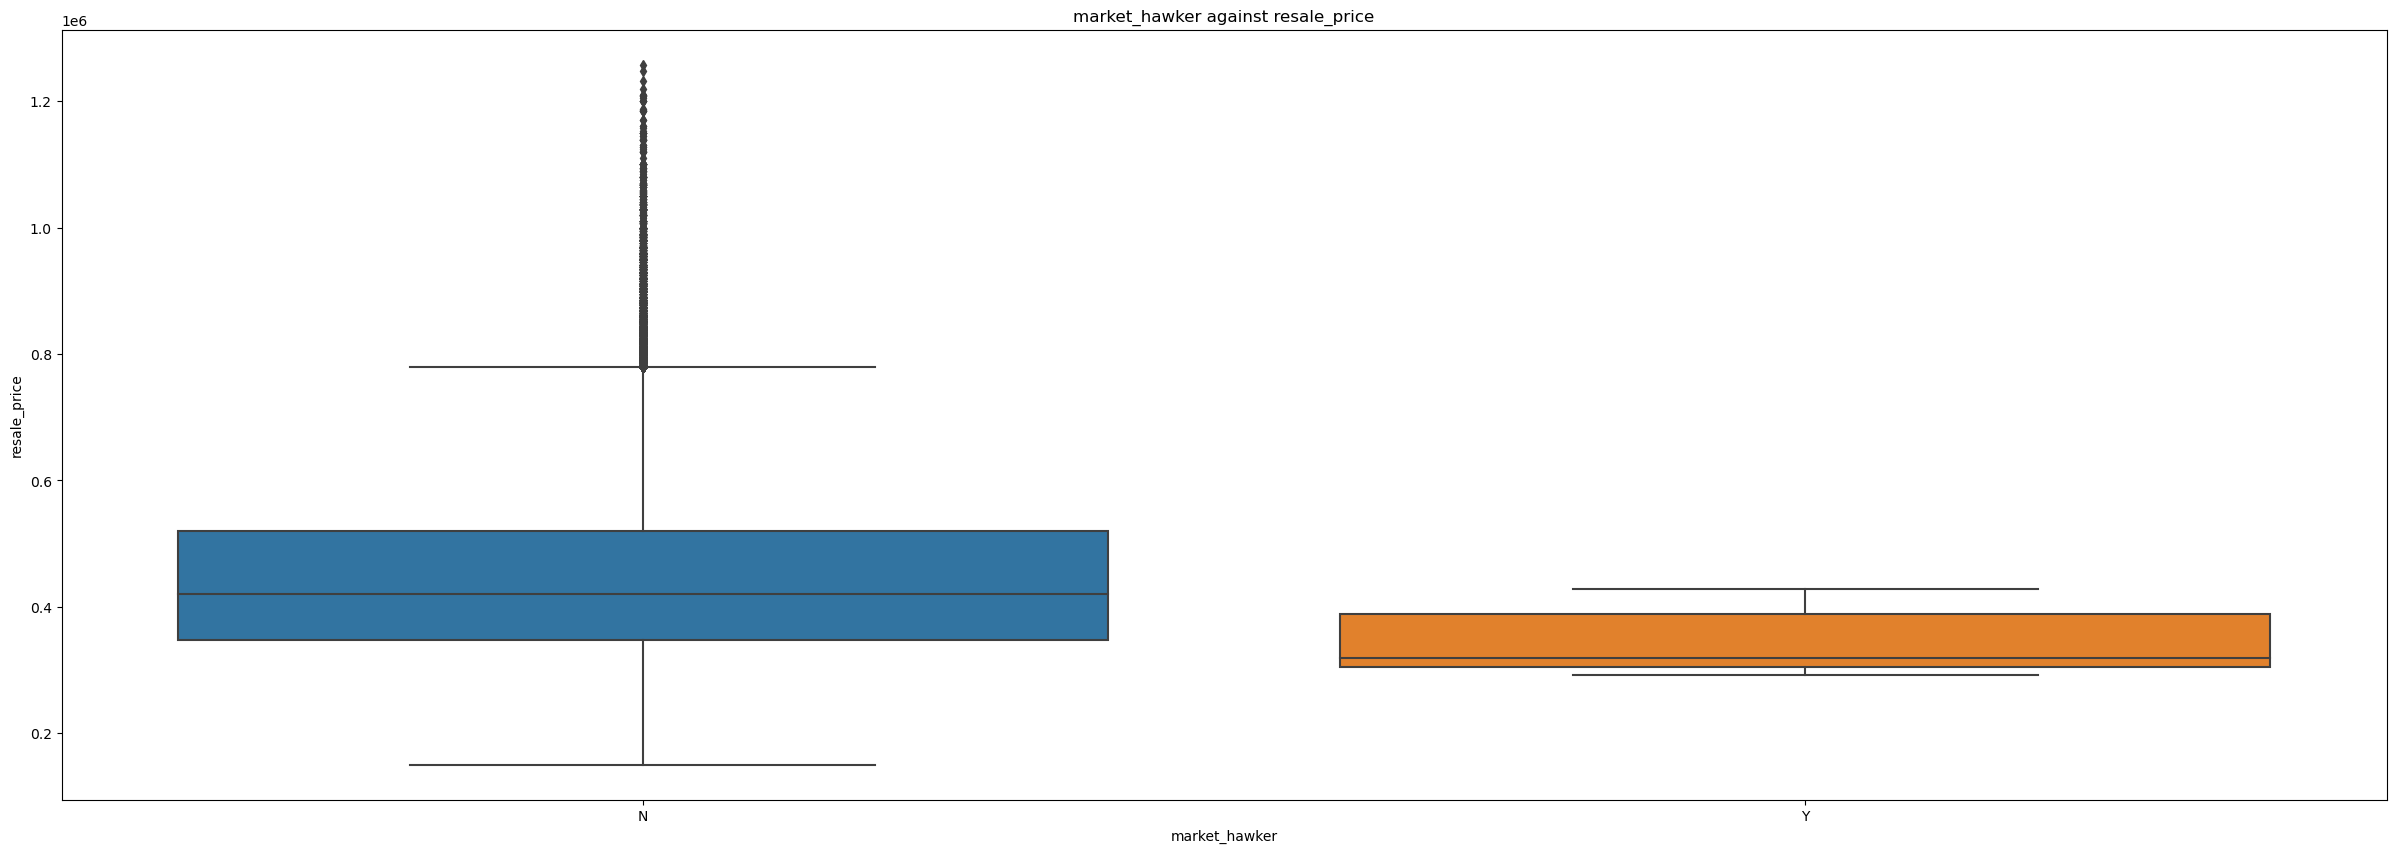

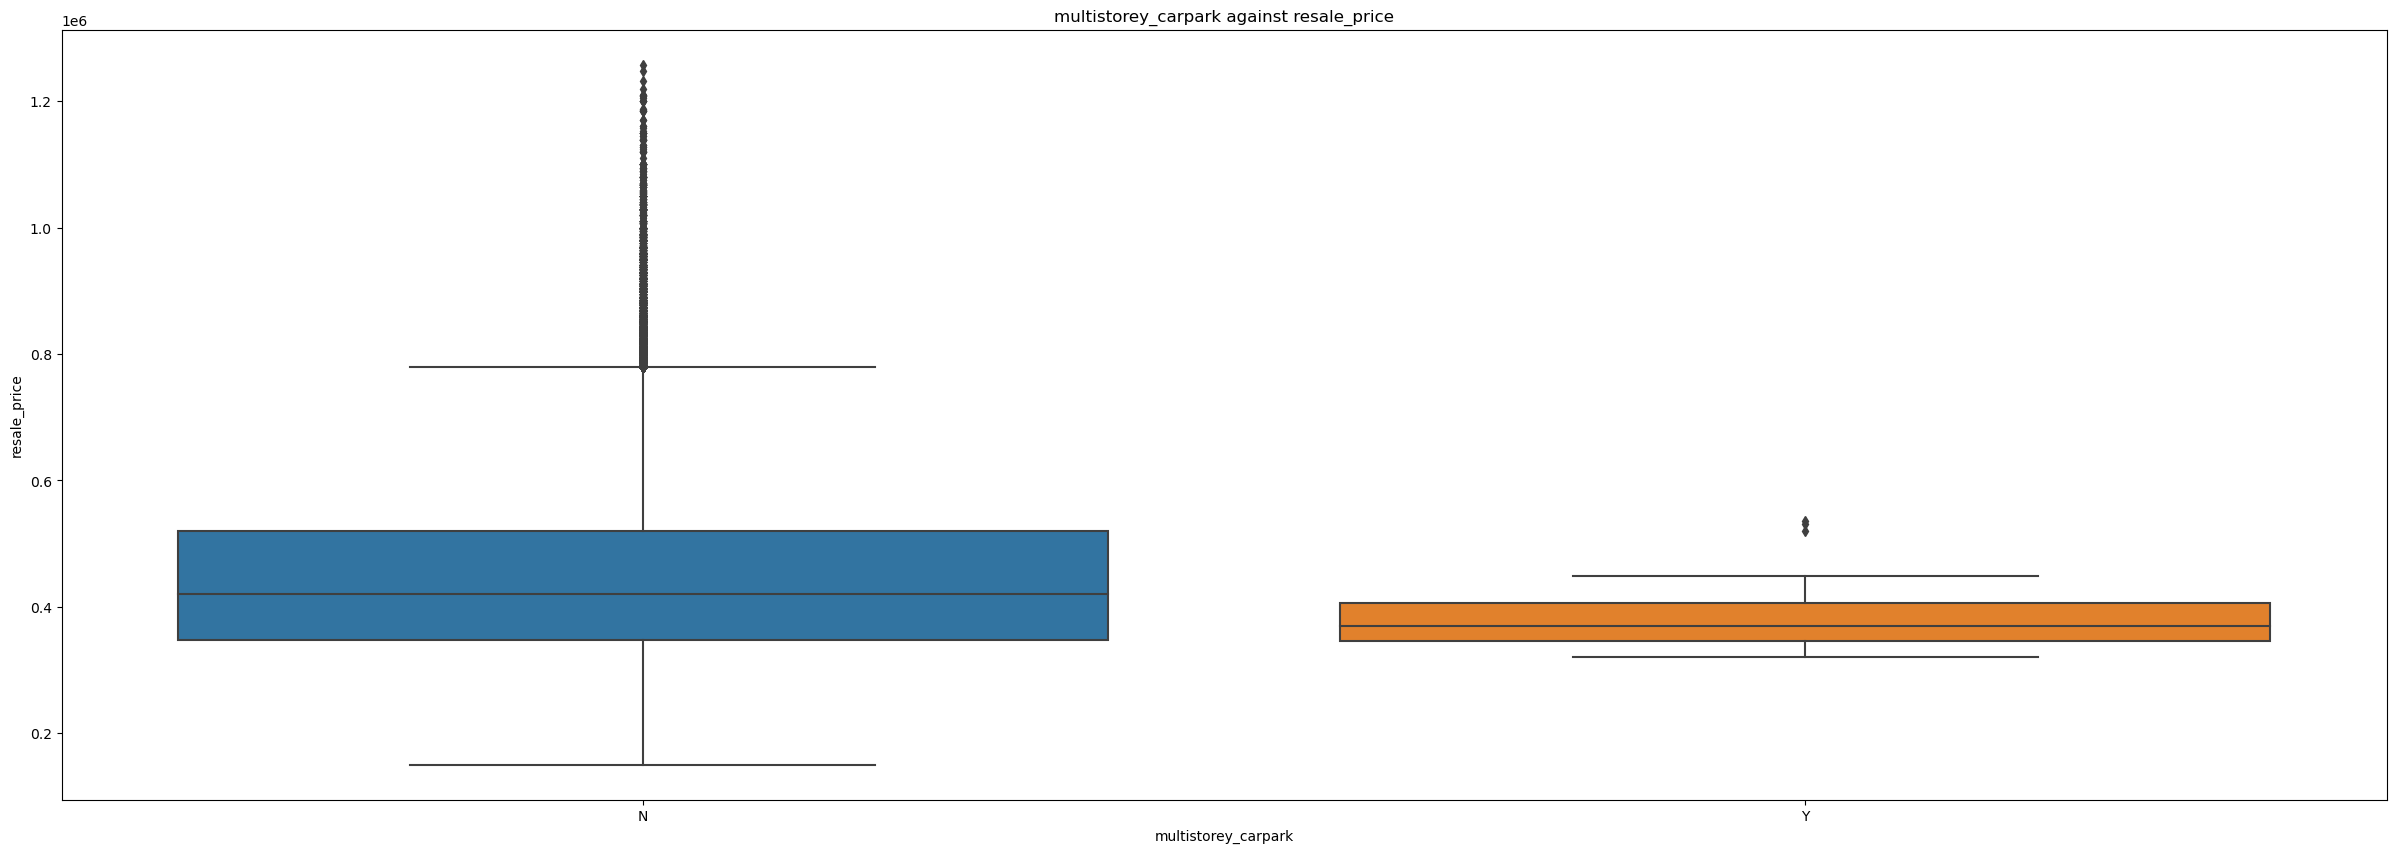

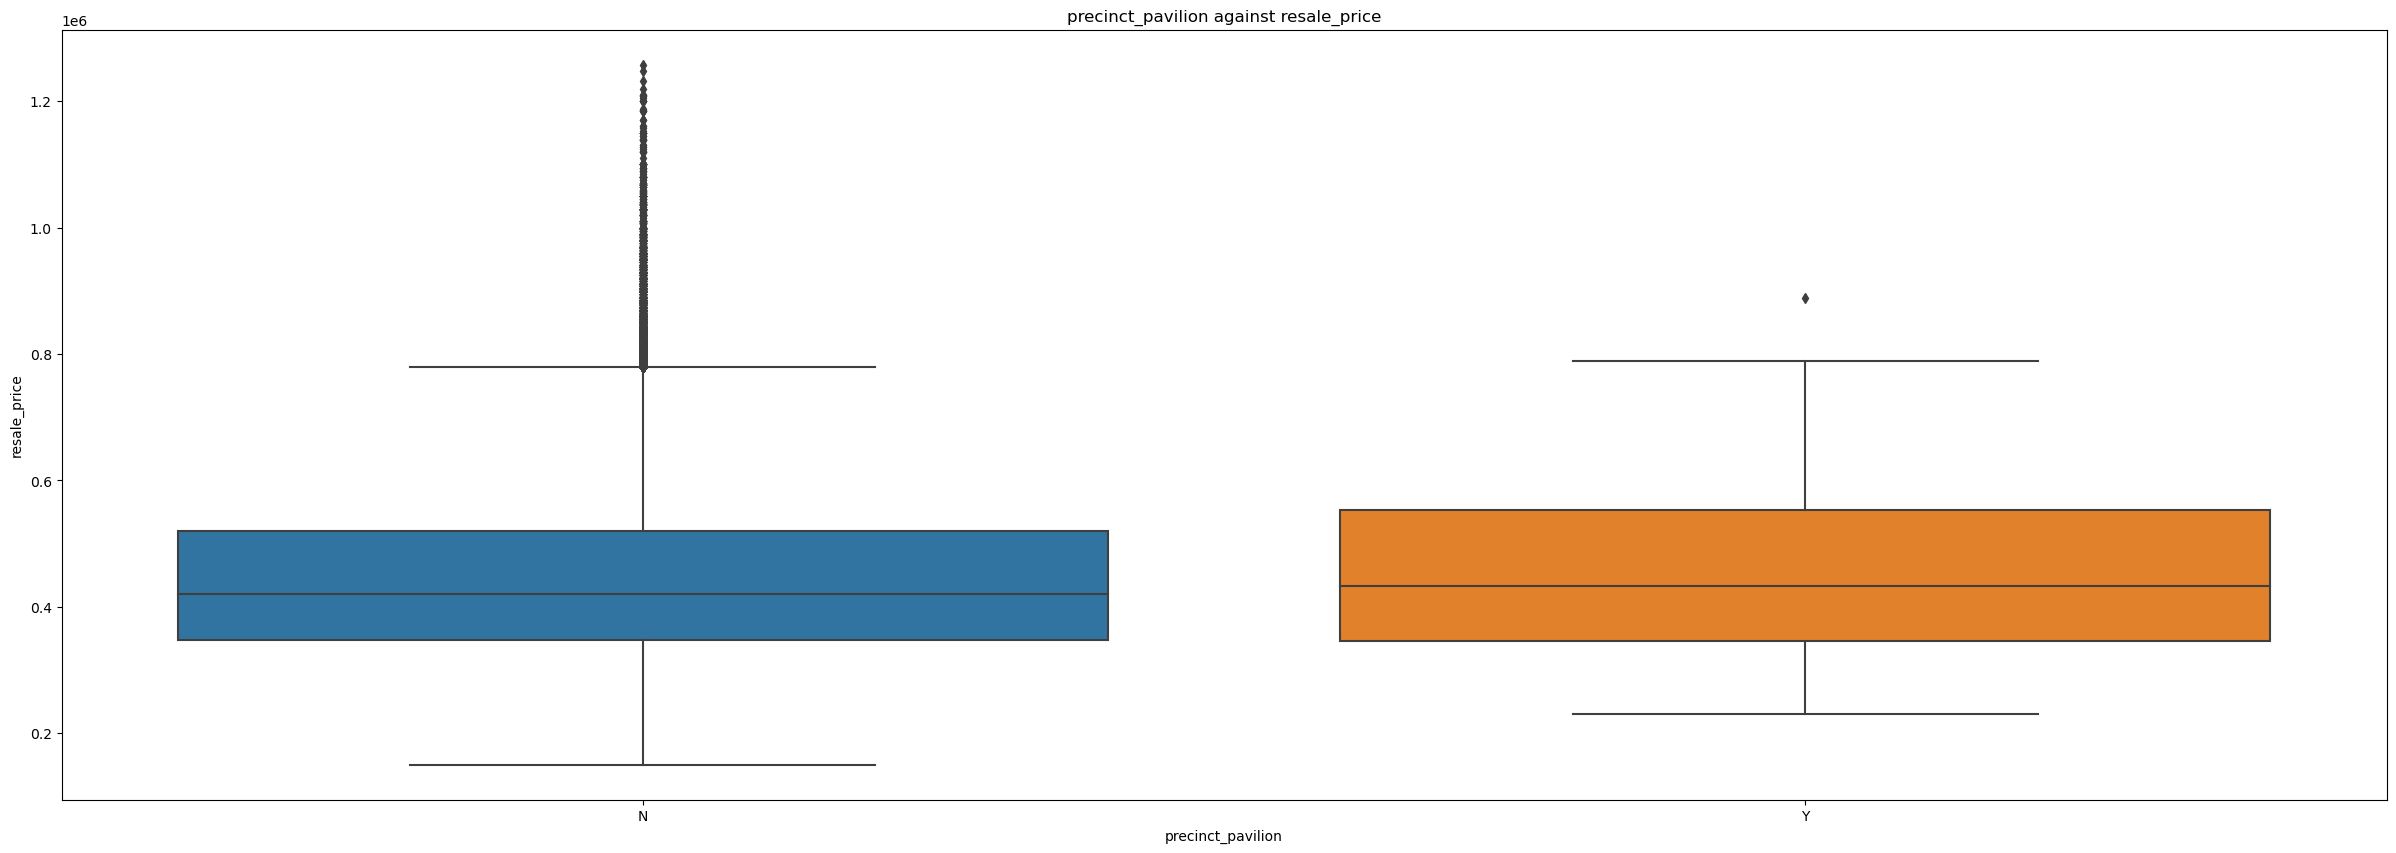

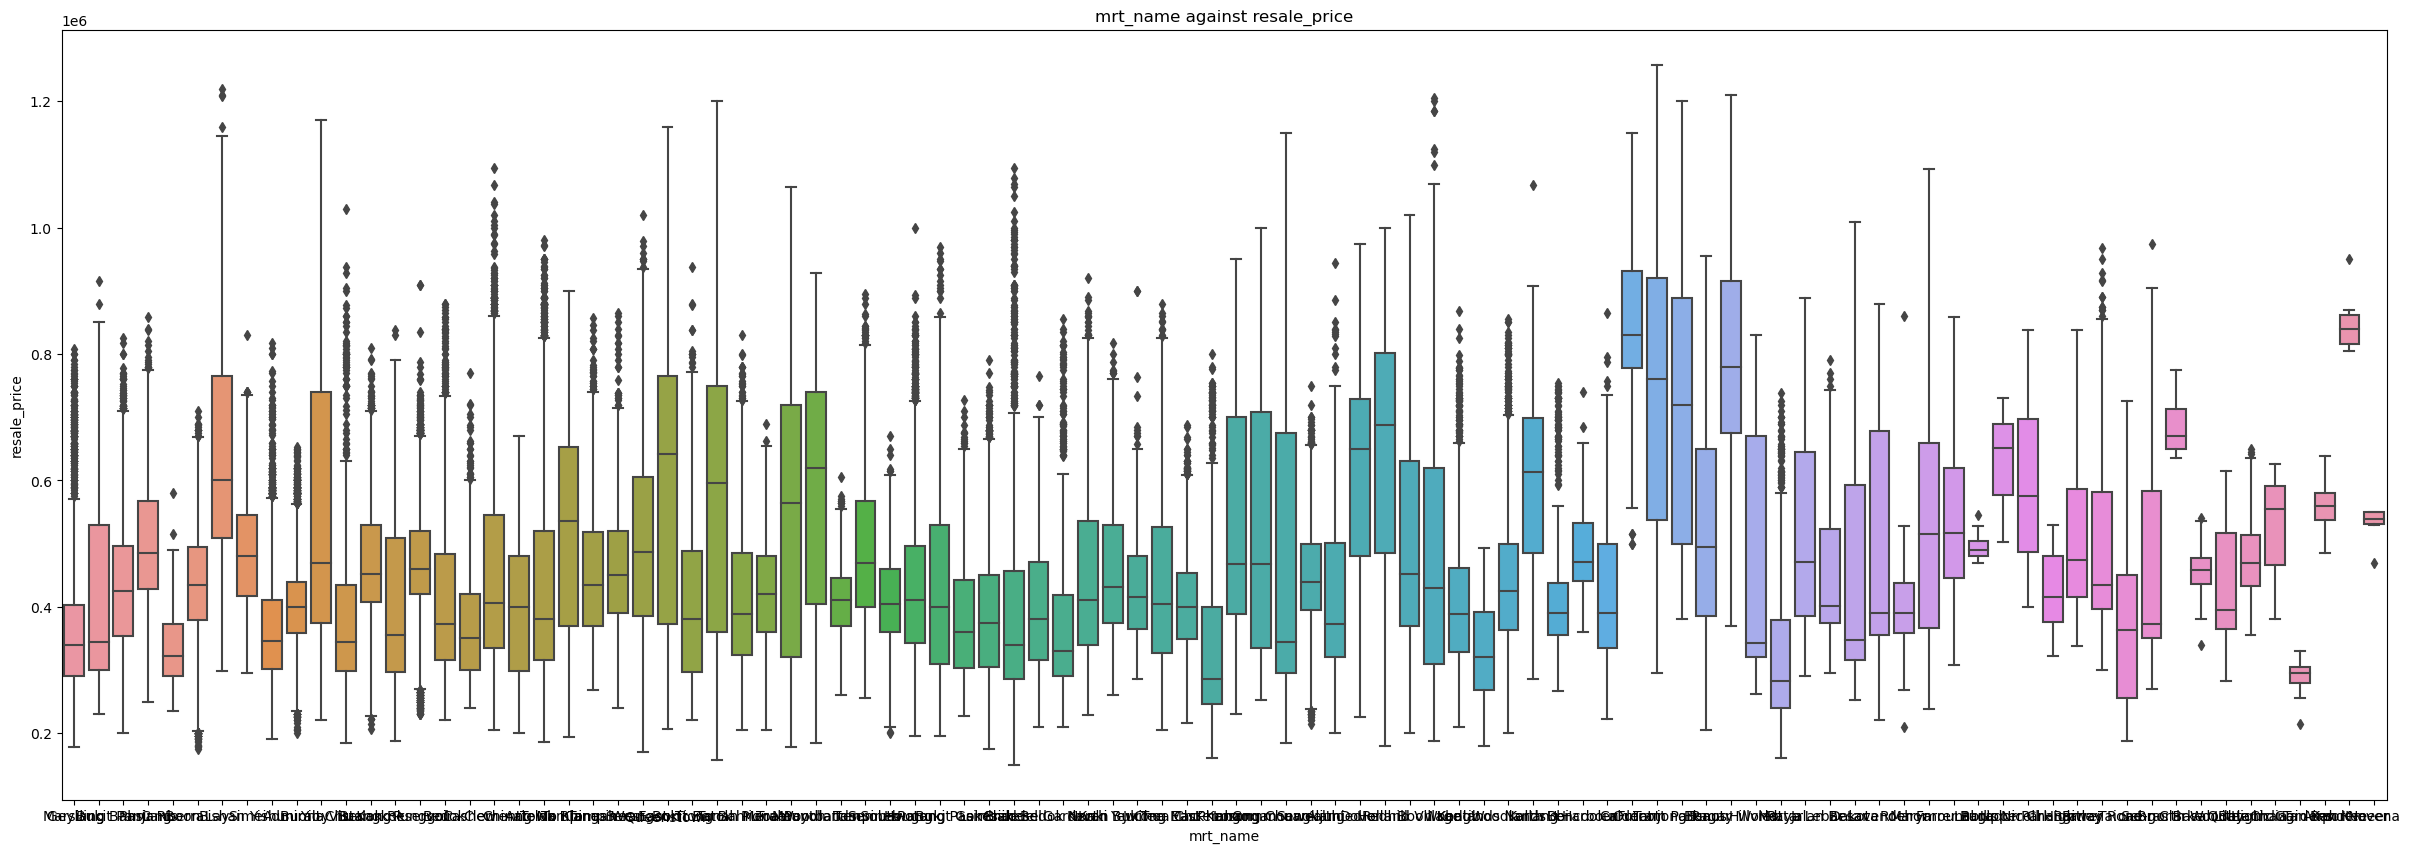

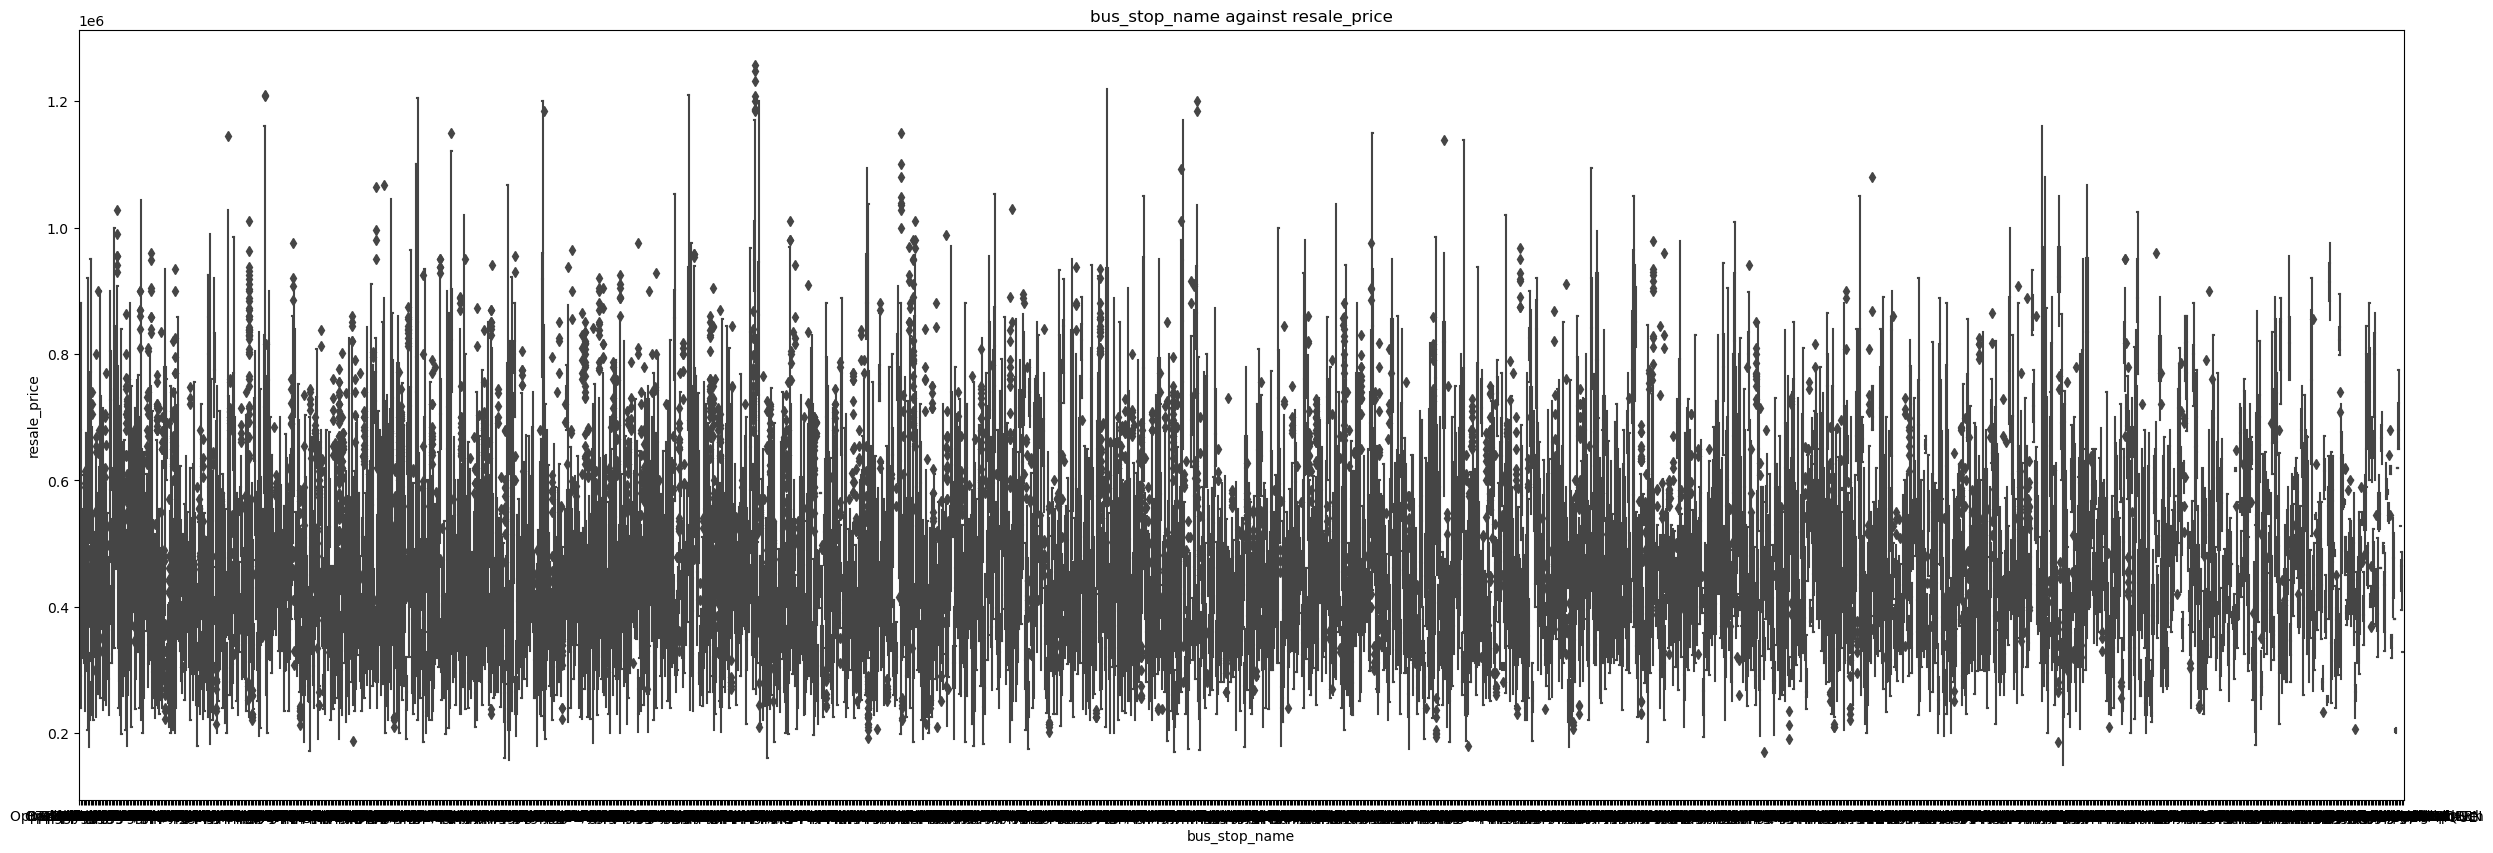

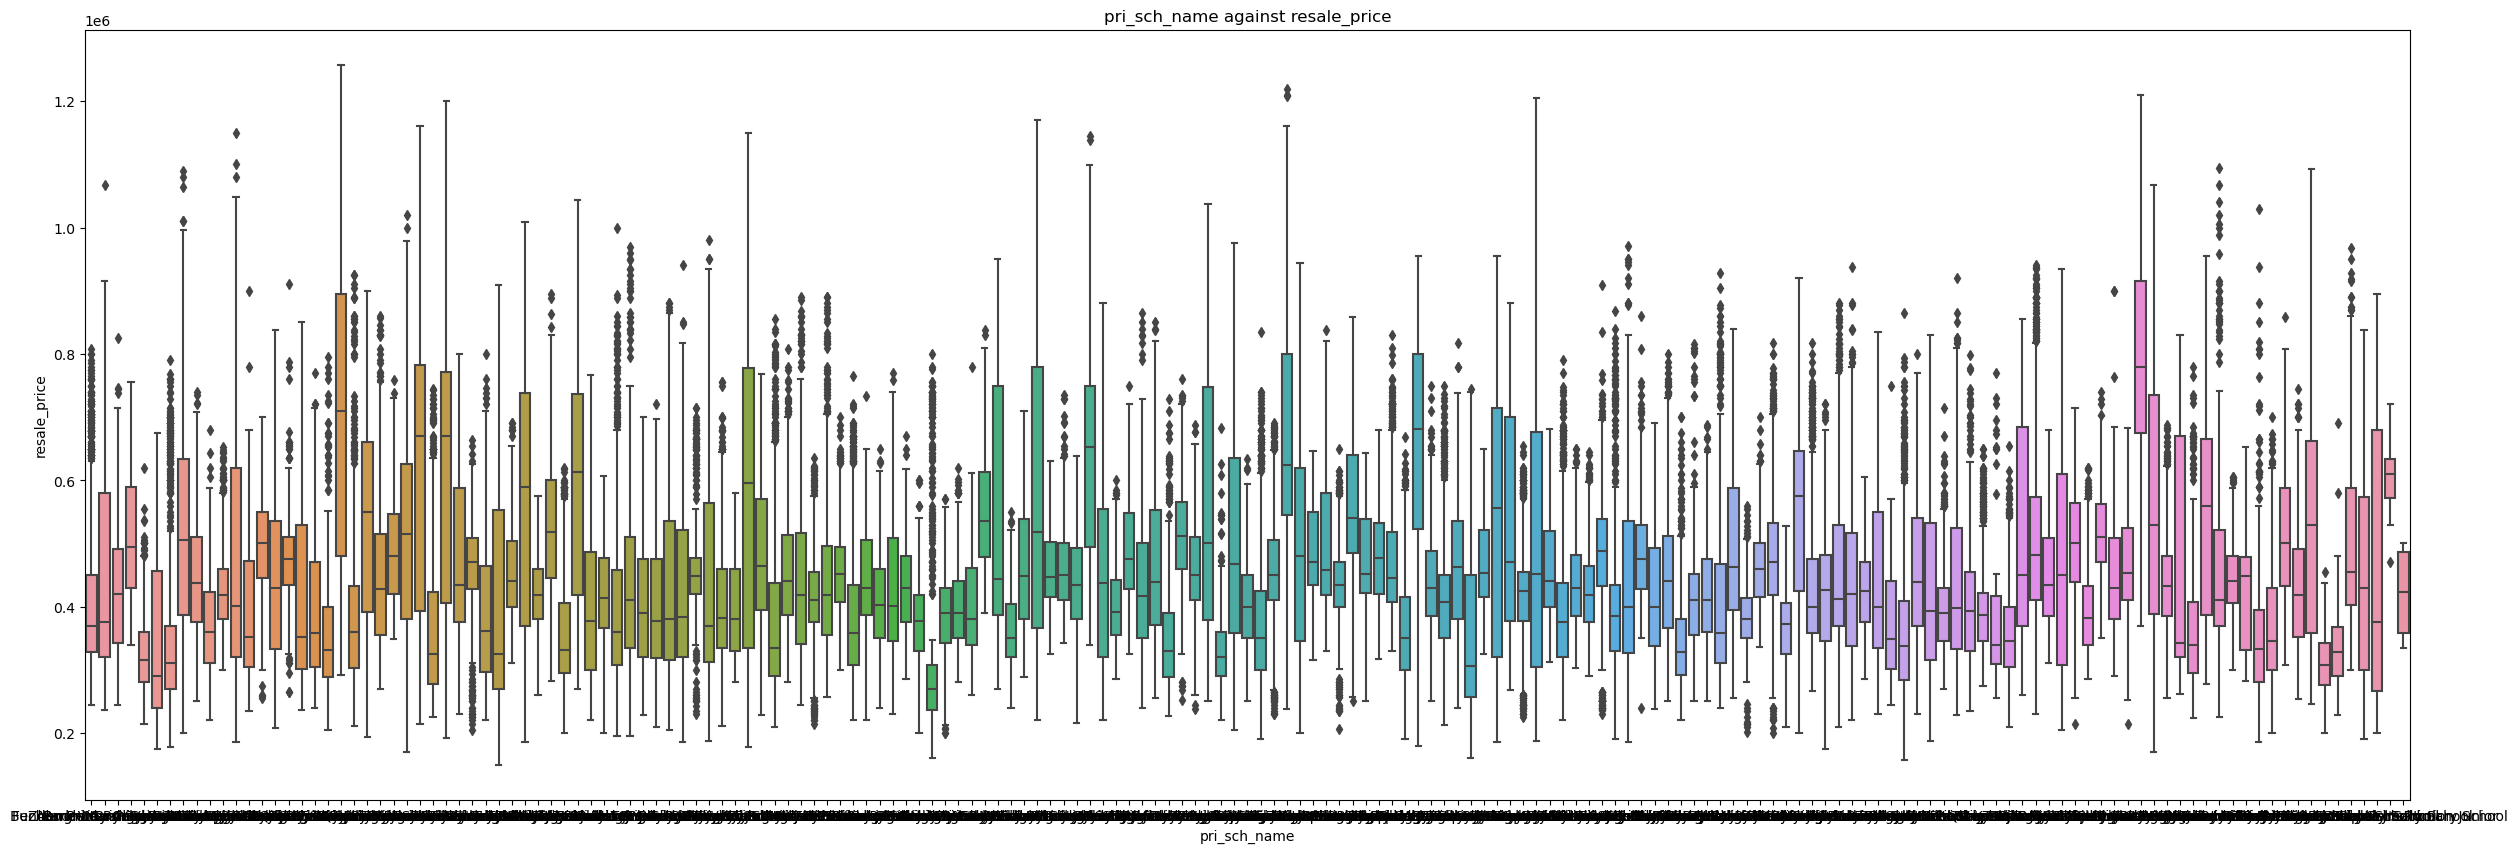

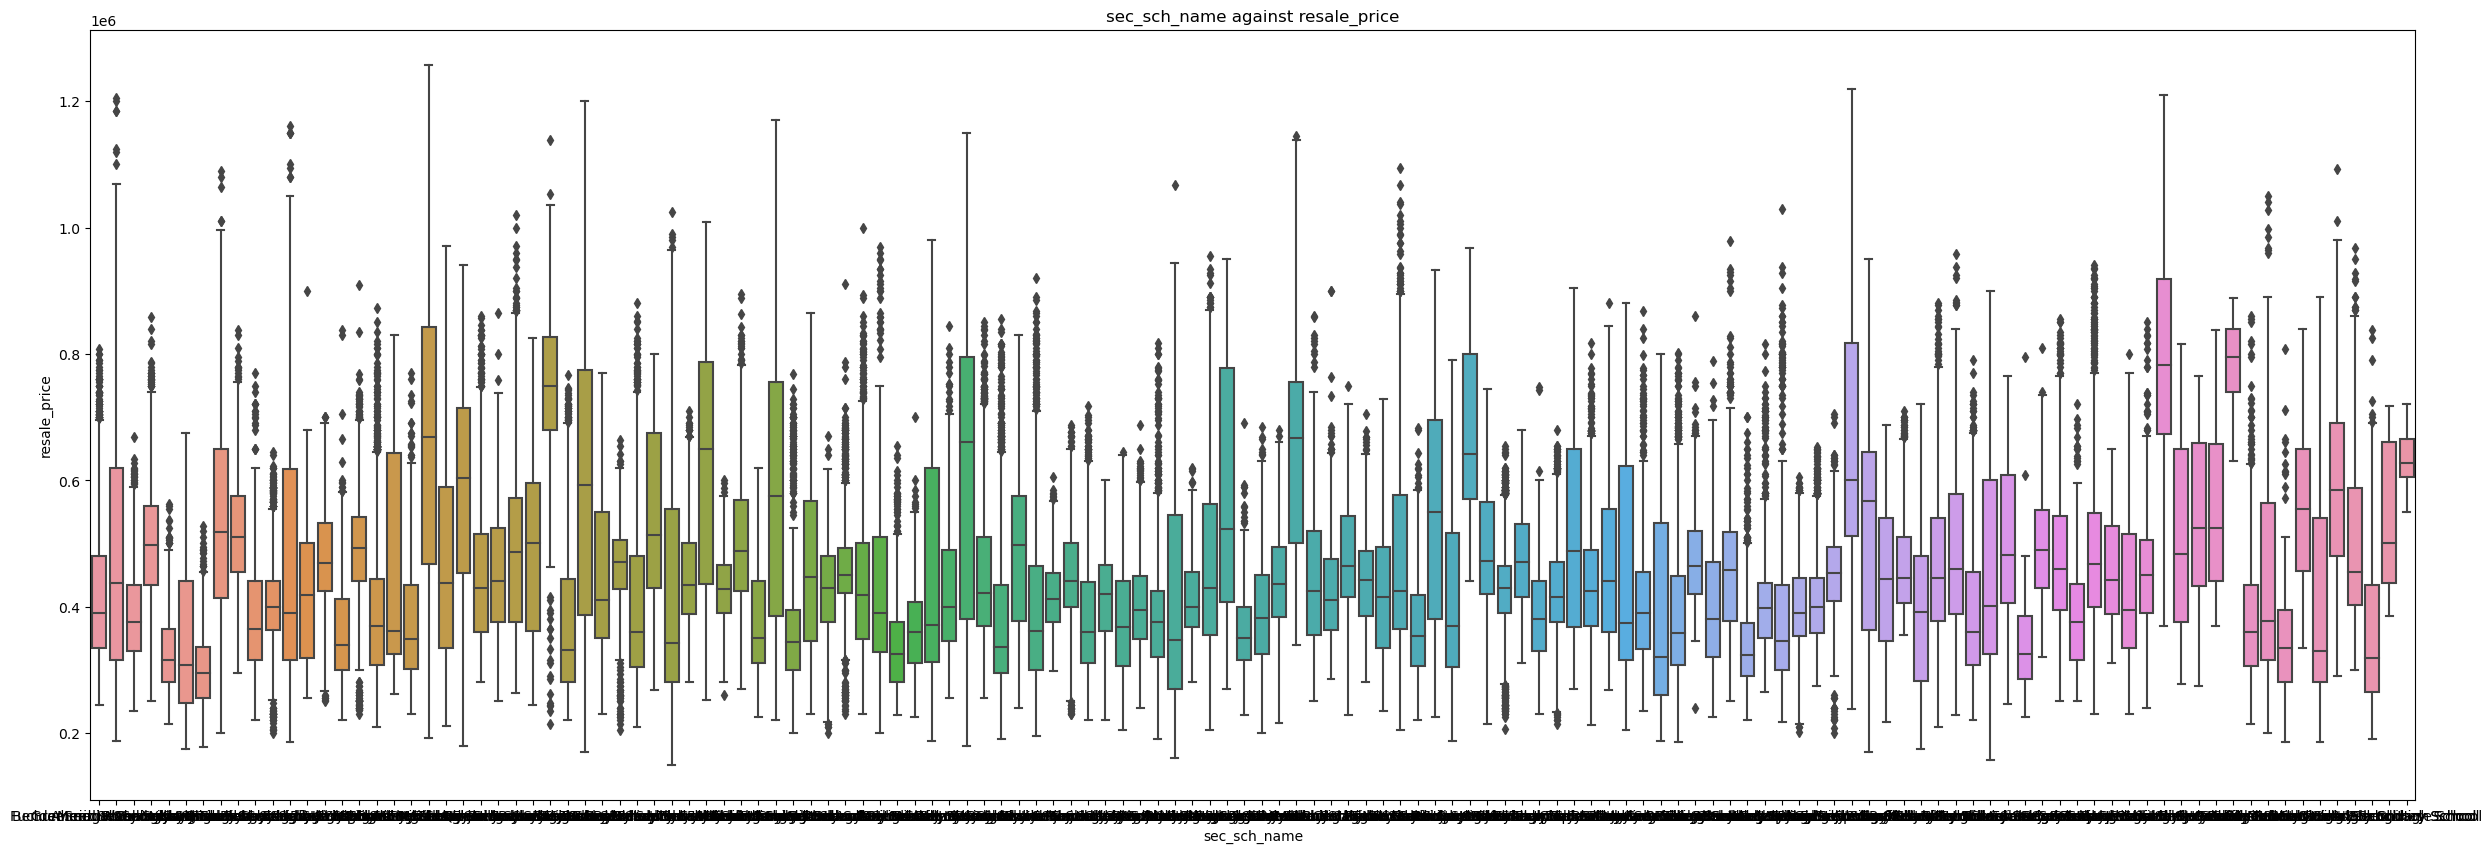

In [194]:
def box_plot_fun():
    for i in X_train_cat2.columns:
        plt.figure(figsize = (30,10))
        sns.boxplot(data=X_train_cat2,x=i, y=y_train)
        plt.title(f"{i} against resale_price")

box_plot_fun()

In [57]:
#as bus_stop_name is very large (1657 unique values)

In [ ]:
objects
#remove storey_range as already in numeric features.
#removed the following based on either logic of repeated dealing or data thats already dealt with in another feature.
#bus stop name was just too large adding almost 1700++ columns to the model. With computational limitation it is not realistic to include this feature.
#furthermore the assumption is that whatever is covered in bus stop name is somewhat covered by the street name and closeness to schools
l2 = ['bus_stop_name','flat_model','flat_type', 'flat_model', 'storey_range', 'Tranc_YearMonth', 'block','address','planning_area', 'postal']
objects_new = [x for x in objects if x not in l2]
objects_new


#### feature engineering ratio of 5/4 rooms to all rooms sold

We can see that in central area, the more expensive (1 million +) resales all have high 4/5 room to all rooms sold ratios.

In [24]:
train_data2.loc[train_data2['town'] == 'CENTRAL AREA', ['5room_sold', '4room_sold', '3room_sold', '2room_sold', 'resale_price', 'town']].sort_values('resale_price')

5room_sold  4room_sold  3room_sold  2room_sold  resale_price  \
39418            0           4          16          72      200000.0   
120319           0           2          48          59      205000.0   
143120           0           4          16          72      208000.0   
1902             0           4          16          72      208000.0   
103858           0           4          96           7      210000.0   
...            ...         ...         ...         ...           ...   
132588          88         176           0           0     1200000.0   
56607           88         176           0           0     1208000.0   
92443           88         176           0           0     1232000.0   
34072           88         176           0           0     1248000.0   
82860           88         176           0           0     1258000.0   

                town  
39418   CENTRAL AREA  
120319  CENTRAL AREA  
143120  CENTRAL AREA  
1902    CENTRAL AREA  
103858  CENTRAL AREA  
...              ...  
132588  CENTRAL AREA  
56607   CENTRAL AREA  
92443   CENTRAL AREA  
34072   CENTRAL AREA  
82860   CENTRAL AREA  

[1249 rows x 6 columns]

As max_floor_lvl and mid_storey both have high correlations to the resale_price, we feature engineer them together to hope to get an even stronger result.

Our 4_5_ratio feature is the sum of 5 and 4 rooms sold divided by 5,4,3,2,1 rooms sold.

As explained previously, we can observe a high correlation between resale_price and 5 rooms sold as well as 3 rooms sold so this feature hopes to combine these features for a stronger resulting model.

In [80]:
train_data2['storey_relative_max'] = train_data2['mid_storey'] / train_data2['max_floor_lvl']

train_data2['4_5_ratio'] = (train_data2['5room_sold'] + train_data2['4room_sold']) / (train_data2['5room_sold'] + train_data2['4room_sold'] + train_data2['3room_sold'] + train_data2['2room_sold'] + train_data2['1room_sold']) 

In [81]:
#dealing with nas
train_data2['4_5_ratio'].fillna(0,inplace=True)

In [82]:
test_data2['storey_relative_max'] = test_data2['mid_storey'] / test_data2['max_floor_lvl']
test_data2['4_5_ratio'] = (test_data2['5room_sold'] + test_data2['4room_sold']) / (test_data2['5room_sold'] + test_data2['4room_sold'] + test_data2['3room_sold'] + test_data2['2room_sold'] + test_data2['1room_sold']) 

In [83]:
#dealing with nas
test_data2['4_5_ratio'].fillna(0,inplace=True)

#### food and ammens, transport and school distance

We have seen a strong coeff in our ridge model for street_name and bus_stop_name. In terms of living condition its logical that food and amenities, transport availability and distance from schools would be key features in determining resale price.

To generalise the model, we will be comparing most of these features to the mean value and returning a value of 0,1,2 depending on how many criteria are met in the respective sections.

In [84]:
#if mall_nearest_distance > mean 1 or if hawker_Nearest_distance > mean 1. if both 2. if neither 0.  
def food_and_ammen(row):
    if (row['Hawker_Nearest_Distance'] > train_data2['Hawker_Nearest_Distance'].mean()) & (row['Mall_Nearest_Distance'] > train_data2['Mall_Nearest_Distance'].mean()):
        return 2
    elif (row['Hawker_Nearest_Distance'] > train_data2['Hawker_Nearest_Distance'].mean()) | (row['Mall_Nearest_Distance'] > train_data2['Mall_Nearest_Distance'].mean()):
        return 1
    else:
        return 0

In [85]:
train_data2['food_and_ammen'] = train_data2.apply(food_and_ammen, axis=1)
test_data2['food_and_ammen'] = test_data2.apply(food_and_ammen, axis=1)

In [86]:
#if mall_nearest_distance > mean 1 or if hawker_Nearest_distance > mean 1. if both 2. if neither 0.
def transport(row):
    if (row['mrt_nearest_distance'] > train_data2['mrt_nearest_distance'].mean()) & (row['bus_stop_nearest_distance'] > train_data2['bus_stop_nearest_distance'].mean()):
        return 2
    elif (row['mrt_nearest_distance'] > train_data2['mrt_nearest_distance'].mean()) | (row['bus_stop_nearest_distance'] > train_data2['bus_stop_nearest_distance'].mean()):
        return 1
    else:
        return 0




In [87]:
train_data2['transport'] = train_data2.apply(transport, axis=1)
test_data2['transport'] = test_data2.apply(transport, axis=1)

In [88]:
#if sec_sch_nearest_distance > mean 1 or if pri_sch_nearest_distance > mean 1. if both 2. if neither 0.
def school(row):
    if (row['sec_sch_nearest_dist'] > train_data2['sec_sch_nearest_dist'].mean()) & (row['pri_sch_nearest_distance'] > train_data2['pri_sch_nearest_distance'].mean()):
        return 2
    elif (row['sec_sch_nearest_dist'] > train_data2['sec_sch_nearest_dist'].mean()) | (row['pri_sch_nearest_distance'] > train_data2['pri_sch_nearest_distance'].mean()):
        return 1
    else:
        return 0




In [89]:
test_data2['sec_pri_distance'] = test_data2.apply(school, axis=1)

In [90]:
train_data2['sec_pri_distance'] = train_data2.apply(school, axis=1)

### Data Dictionary before feature engineering/selection
|Feature|Description|dtype|
|---|---|---|
resale_price| the property's sale price in Singapore dollars. This is the target variable that you're trying to predict for this challenge.|int64
town| HDB township where the flat is located, e.g. BUKIT MERAH| object
flat_type| type of the resale flat unit, e.g. 3 ROOM| object
street_name| street name where the resale flat resides, e.g. TAMPINES ST 42| object
storey_range| floor level (range) of the resale flat unit, e.g. 07 TO 09| object
floor_area_sqm| floor area of the resale flat unit in square metres| float64
flat_model| HDB model of the resale flat, e.g. Multi Generation| object
lease_commence_date| commencement year of the flat unit's 99-year lease| int64
Tranc_Year| year of resale transaction| int64
Tranc_Month| month of resale transaction| int64
mid_storey| median value of storey_range| int64
lower| lower value of storey_range| int64
upper| upper value of storey_range| int64
mid| middle value of storey_range| int64
full_flat_type| combination of flat_type and flat_model| object
floor_area_sqft| floor area of the resale flat unit in square feet| int64
hdb_age| number of years from lease_commence_date to present year| int64
max_floor_lvl| highest floor of the resale flat| int64
year_completed| year which construction was completed for resale flat| int64
residential| boolean value if resale flat has residential units in the same block| object
commercial| boolean value if resale flat has commercial units in the same block| object
market_hawker| boolean value if resale flat has a market or hawker centre in the same block| object
multistorey_carpark| boolean value if resale flat has a multistorey carpark in the same block| object
precinct_pavilion| boolean value if resale flat has a pavilion in the same block| object
total_dwelling_units| total number of residential dwelling units in the resale flat| int64
1room_sold| number of 1-room residential units in the resale flat| int64
2room_sold| number of 2-room residential units in the resale flat| int64
3room_sold| number of 3-room residential units in the resale flat| int64
4room_sold| number of 4-room residential units in the resale flat| int64
5room_sold| number of 5-room residential units in the resale flat| int64
exec_sold| number of executive type residential units in the resale flat block| int64
multigen_sold| number of multi-generational type residential units in the resale flat block| int64
studio_apartment_sold| number of studio apartment type residential units in the resale flat block| int64
1room_rental| number of 1-room rental residential units in the resale flat block| int64
2room_rental| number of 2-room rental residential units in the resale flat block| int64
3room_rental| number of 3-room rental residential units in the resale flat block| int64
other_room_rental| number of "other" type rental residential units in the resale flat block| int64
Latitude| Latitude based on postal code| float64
Longitude| Longitude based on postal code| float64
Hawker_Nearest_Distance| distance (in metres) to the nearest hawker centre| float64
hawker_food_stalls| number of hawker food stalls in the nearest hawker centre| int64
hawker_market_stalls| number of hawker and market stalls in the nearest hawker centre| int64
mrt_nearest_distance| distance (in metres) to the nearest MRT station| float64
mrt_name| name of the nearest MRT station| object
bus_interchange| boolean value if the nearest MRT station is also a bus interchange| object
mrt_interchange| boolean value if the nearest MRT station is a train interchange station| object
mrt_latitude| latitude (in decimal degrees) of the the nearest MRT station| float64
mrt_longitude| longitude (in decimal degrees) of the nearest MRT station| float64
bus_stop_nearest_distance| distance (in metres) to the nearest bus stop| float64
bus_stop_name| name of the nearest bus stop| int64
bus_stop_latitude| latitude (in decimal degrees) of the the nearest bus stop| float64
bus_stop_longitude| longitude (in decimal degrees) of the nearest bus stop| float64
pri_sch_nearest_distance| distance (in metres) to the nearest primary school| float64
pri_sch_name| name of the nearest primary school| object
vacancy| number of vacancies in the nearest primary school| int64
pri_sch_affiliation| boolean value if the nearest primary school has a secondary school affiliation| int64
pri_sch_latitude| latitude (in decimal degrees) of the the nearest primary school| float64
pri_sch_longitude| longitude (in decimal degrees) of the nearest primary school| float64
sec_sch_nearest_dist| distance (in metres) to the nearest secondary school| float64
sec_sch_name| name of the nearest secondary school| object
cutoff_point| PSLE cutoff point of the nearest secondary school| int64
affiliation| boolean value if the nearest secondary school has an primary school affiliation| int64
sec_sch_latitude| latitude (in decimal degrees) of the the nearest secondary school| float64
sec_sch_longitude| longitude (in decimal degrees) of the nearest secondary school| float64

### Data Dictionary after feature engineering/selection
|Feature|Description|dtype|
|---|---|---|
resale_price| the property's sale price in Singapore dollars. This is the target variable that you're trying to predict for this challenge.|int64
town| HDB township where the flat is located, e.g. BUKIT MERAH| object
flat_type| type of the resale flat unit, e.g. 3 ROOM| object
street_name| street name where the resale flat resides, e.g. TAMPINES ST 42| object
storey_range| floor level (range) of the resale flat unit, e.g. 07 TO 09| object
floor_area_sqm| floor area of the resale flat unit in square metres| float64
flat_model| HDB model of the resale flat, e.g. Multi Generation| object
lease_commence_date| commencement year of the flat unit's 99-year lease| int64
Tranc_Year| year of resale transaction| int64
Tranc_Month| month of resale transaction| int64
mid_storey| median value of storey_range| int64
lower| lower value of storey_range| int64
upper| upper value of storey_range| int64
mid| middle value of storey_range| int64
full_flat_type| combination of flat_type and flat_model| object
floor_area_sqft| floor area of the resale flat unit in square feet| int64
hdb_age| number of years from lease_commence_date to present year| int64
max_floor_lvl| highest floor of the resale flat| int64
year_completed| year which construction was completed for resale flat| int64
residential| boolean value if resale flat has residential units in the same block| object
commercial| boolean value if resale flat has commercial units in the same block| object
market_hawker| boolean value if resale flat has a market or hawker centre in the same block| object
multistorey_carpark| boolean value if resale flat has a multistorey carpark in the same block| object
precinct_pavilion| boolean value if resale flat has a pavilion in the same block| object
total_dwelling_units| total number of residential dwelling units in the resale flat| int64
1room_sold| number of 1-room residential units in the resale flat| int64
2room_sold| number of 2-room residential units in the resale flat| int64
3room_sold| number of 3-room residential units in the resale flat| int64
4room_sold| number of 4-room residential units in the resale flat| int64
5room_sold| number of 5-room residential units in the resale flat| int64
exec_sold| number of executive type residential units in the resale flat block| int64
multigen_sold| number of multi-generational type residential units in the resale flat block| int64
studio_apartment_sold| number of studio apartment type residential units in the resale flat block| int64
1room_rental| number of 1-room rental residential units in the resale flat block| int64
2room_rental| number of 2-room rental residential units in the resale flat block| int64
3room_rental| number of 3-room rental residential units in the resale flat block| int64
other_room_rental| number of "other" type rental residential units in the resale flat block| int64
Latitude| Latitude based on postal code| float64
Longitude| Longitude based on postal code| float64
Hawker_Nearest_Distance| distance (in metres) to the nearest hawker centre| float64
hawker_food_stalls| number of hawker food stalls in the nearest hawker centre| int64
hawker_market_stalls| number of hawker and market stalls in the nearest hawker centre| int64
mrt_nearest_distance| distance (in metres) to the nearest MRT station| float64
mrt_name| name of the nearest MRT station| object
bus_interchange| boolean value if the nearest MRT station is also a bus interchange| object
mrt_interchange| boolean value if the nearest MRT station is a train interchange station| object
mrt_latitude| latitude (in decimal degrees) of the the nearest MRT station| float64
mrt_longitude| longitude (in decimal degrees) of the nearest MRT station| float64
bus_stop_nearest_distance| distance (in metres) to the nearest bus stop| float64
bus_stop_name| name of the nearest bus stop| int64
bus_stop_latitude| latitude (in decimal degrees) of the the nearest bus stop| float64
bus_stop_longitude| longitude (in decimal degrees) of the nearest bus stop| float64
pri_sch_nearest_distance| distance (in metres) to the nearest primary school| float64
pri_sch_name| name of the nearest primary school| object
vacancy| number of vacancies in the nearest primary school| int64
pri_sch_affiliation| boolean value if the nearest primary school has a secondary school affiliation| int64
pri_sch_latitude| latitude (in decimal degrees) of the the nearest primary school| float64
pri_sch_longitude| longitude (in decimal degrees) of the nearest primary school| float64
sec_sch_nearest_dist| distance (in metres) to the nearest secondary school| float64
sec_sch_name| name of the nearest secondary school| object
cutoff_point| PSLE cutoff point of the nearest secondary school| int64
affiliation| boolean value if the nearest secondary school has an primary school affiliation| int64
sec_sch_latitude| latitude (in decimal degrees) of the the nearest secondary school| float64
sec_sch_longitude| longitude (in decimal degrees) of the nearest secondary school| float64
Mall_Nearest_Distance| Mall_Nearest_Distance with imputed median in na values| float64
postal_number| first two digits of postal number| int64
storey_relative_max| median storey in storey_range divided by max_floor_lvl| float64
4_5_ratio| sum of 4 and 5 room flats sold divided by 5,4,3,2,1 room flats sold| float 64
food_and_ammen| value of 0,1,2 corresponding to if the resale flat has a greater distance to the nearest hawker centre and/or mall as compared to the mean hawker centre distance and mall distance in the dataset| float64
transport| value of 0,1,2 corresponding to if the resale flat has a greater distance to the nearest bus stop/mrt station as compared to the mean bus stop distance and mrt distance in the dataset| float64
sec_pri_distance | value of 0,1,2 corresponding to if the resale flat has a greater distance to the nearest primary/secondary school as compared to the mean secondary school and primary school distance in the dataset| float64

#### preparing for Ridge_CV and Lasso_CV regression

As mentioned in the colinearity and OLS section, we will be removing the below features.

In [91]:
train_data2.drop(['id',
 'multigen_sold',
 'Latitude',
 'bus_stop_latitude',
 'bus_stop_longitude',
 'pri_sch_longitude',
 'sec_sch_latitude',
 #from colinearity
 'floor_area_sqft', 'lease_commence_date', 'mid','upper','lower'] + l2, axis=1,inplace=True)

In [92]:
test_data2.drop(['id',
 'multigen_sold',
 'Latitude',
 'bus_stop_latitude',
 'bus_stop_longitude',
 'pri_sch_longitude',
 'sec_sch_latitude',
 #from colinearity
 'floor_area_sqft', 'lease_commence_date', 'mid','upper','lower'] + l2, axis=1,inplace=True)


Similarly to train_data and test_data, we removed these features due to the missing values.

In [93]:
train_data2.drop(columns=['Hawker_Within_500m', 'Mall_Within_500m', 'Hawker_Within_1km', 'Hawker_Within_2km','Mall_Within_1km', 'Mall_Within_2km'],
                         inplace=True)

In [94]:
test_data2.drop(columns=['Hawker_Within_500m', 'Mall_Within_500m', 'Hawker_Within_1km', 'Hawker_Within_2km','Mall_Within_1km', 'Mall_Within_2km'],
                         inplace=True)

In [95]:
train_data2

town         street_name  floor_area_sqm  resale_price  \
0       KALLANG/WHAMPOA    UPP BOON KENG RD            90.0      680000.0   
1                BISHAN        BISHAN ST 13           130.0      665000.0   
2           BUKIT BATOK      BT BATOK ST 25           144.0      838000.0   
3                BISHAN        BISHAN ST 22           103.0      550000.0   
4                YISHUN        YISHUN ST 81            83.0      298000.0   
...                 ...                 ...             ...           ...   
150629        WOODLANDS     WOODLANDS ST 82           161.0      625000.0   
150630      JURONG WEST   JURONG WEST ST 61           110.0      455000.0   
150631            BEDOK  BEDOK RESERVOIR RD           144.0      733000.0   
150632       QUEENSTOWN          HOLLAND CL            59.0      338000.0   
150633           YISHUN        YISHUN AVE 4           164.0      765000.0   

        Tranc_Year  Tranc_Month  mid_storey  \
0             2016            5          11   
1             2012            7           8   
2             2013            7          14   
3             2012            4           3   
4             2017           12           2   
...            ...          ...         ...   
150629        2020            9           5   
150630        2017            6           5   
150631        2020           12          11   
150632        2016            5           8   
150633        2018            6           8   

                           full_flat_type  hdb_age  max_floor_lvl  ...  \
0                          4 ROOM Model A       15             25  ...   
1                         5 ROOM Improved       34              9  ...   
2                     EXECUTIVE Apartment       24             16  ...   
3                          4 ROOM Model A       29             11  ...   
4                       4 ROOM Simplified       34              4  ...   
...                                   ...      ...            ...  ...   
150629                EXECUTIVE Apartment       26             12  ...   
150630                    5 ROOM Improved       20             16  ...   
150631                EXECUTIVE Apartment       28             15  ...   
150632                    3 ROOM Improved       47             10  ...   
150633  MULTI-GENERATION Multi Generation       34             12  ...   

                                   sec_sch_name cutoff_point affiliation  \
0                      Geylang Methodist School          224           0   
1       Kuo Chuan Presbyterian Secondary School          232           0   
2                  Yusof Ishak Secondary School          188           0   
3                          Catholic High School          253           1   
4                  Orchid Park Secondary School          208           0   
...                                         ...          ...         ...   
150629               Evergreen Secondary School          224           0   
150630                Boon Lay Secondary School          188           0   
150631                Manjusri Secondary School          188           0   
150632               Queensway Secondary School          214           0   
150633             Orchid Park Secondary School          208           0   

       sec_sch_longitude postal_number storey_relative_max  4_5_ratio  \
0             103.882504            38            0.440000   1.000000   
1             103.854892            57            0.888889   1.000000   
2             103.760013            65            0.875000   1.000000   
3             103.844934            57            0.272727   1.000000   
4             103.838335            76            0.500000   1.000000   
...                  ...           ...                 ...        ...   
150629        103.793772            73            0.416667   0.700000   
150630        103.701703            64            0.312500   1.000000   
150631        103.901811            41            0.733333   0.000000 

In [96]:
y = train_data2['resale_price']
X = train_data2.drop(columns='resale_price')

In [97]:
#train test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, random_state=1337)

In [98]:
#reinstatiate standardscaler
ss2 = StandardScaler()

In [99]:
#these are the categorical features being used
objects_new

['town',
 'street_name',
 'full_flat_type',
 'residential',
 'commercial',
 'market_hawker',
 'multistorey_carpark',
 'precinct_pavilion',
 'mrt_name',
 'pri_sch_name',
 'sec_sch_name']

In [100]:
X_train_cat_2 = X_train_2.loc[:, objects_new].copy().astype(str)
X_test_cat_2 = X_test_2.loc[:, objects_new].copy().astype(str)

In [101]:
X_test_cat_2.shape

(37659, 11)

In [102]:
X_train_cat_2.head()

town      street_name   full_flat_type residential  \
144489        WOODLANDS  WOODLANDS ST 32  5 ROOM Improved           Y   
60653   KALLANG/WHAMPOA     BENDEMEER RD  3 ROOM Improved           Y   
62866     BUKIT PANJANG         FAJAR RD   4 ROOM Model A           Y   
29615         PASIR RIS         ELIAS RD  5 ROOM Improved           Y   
47879            YISHUN     YISHUN AVE 7   4 ROOM Model A           Y   

       commercial market_hawker multistorey_carpark precinct_pavilion  \
144489          Y             N                   N                 N   
60653           Y             N                   N                 N   
62866           N             N                   N                 N   
29615           Y             N                   N                 N   
47879           Y             N                   N                 N   

             mrt_name                  pri_sch_name  \
144489      Marsiling         Fuchun Primary School   
60653   Geylang Bahru      Bendemeer Primary School   
62866   Bukit Panjang       Zhenghua Primary School   
29615       Pasir Ris      Park View Primary School   
47879        Canberra  Ahmad Ibrahim Primary School   

                          sec_sch_name  
144489         Fuchun Secondary School  
60653       Bendemeer Secondary School  
62866      Greenridge Secondary School  
29615        Meridian Secondary School  
47879   Ahmad Ibrahim Secondary School

In [103]:
#ensuring no object dtype and no null values
train_data2.loc[:, ~train_data2.columns.isin(objects_new)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   floor_area_sqm             150634 non-null  float64
 1   resale_price               150634 non-null  float64
 2   Tranc_Year                 150634 non-null  int64  
 3   Tranc_Month                150634 non-null  int64  
 4   mid_storey                 150634 non-null  int64  
 5   hdb_age                    150634 non-null  int64  
 6   max_floor_lvl              150634 non-null  int64  
 7   year_completed             150634 non-null  int64  
 8   total_dwelling_units       150634 non-null  int64  
 9   1room_sold                 150634 non-null  int64  
 10  2room_sold                 150634 non-null  int64  
 11  3room_sold                 150634 non-null  int64  
 12  4room_sold                 150634 non-null  int64  
 13  5room_sold                 15

In [104]:
#ensuring no object dtype and no null values
test_data2.loc[:, ~test_data2.columns.isin(objects_new)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   floor_area_sqm             16737 non-null  float64
 1   Tranc_Year                 16737 non-null  int64  
 2   Tranc_Month                16737 non-null  int64  
 3   mid_storey                 16737 non-null  int64  
 4   hdb_age                    16737 non-null  int64  
 5   max_floor_lvl              16737 non-null  int64  
 6   year_completed             16737 non-null  int64  
 7   total_dwelling_units       16737 non-null  int64  
 8   1room_sold                 16737 non-null  int64  
 9   2room_sold                 16737 non-null  int64  
 10  3room_sold                 16737 non-null  int64  
 11  4room_sold                 16737 non-null  int64  
 12  5room_sold                 16737 non-null  int64  
 13  exec_sold                  16737 non-null  int

In [105]:
#reinstatiating onehotencoder
ohe2 = OneHotEncoder(handle_unknown='ignore',drop='first')
#return dataframe on X_train_cat_2 data
X_train_cat_2 = pd.DataFrame((ohe2.fit_transform(X_train_cat_2).toarray()), columns = ohe2.get_feature_names_out())
X_test_cat_2 = pd.DataFrame(ohe2.transform(X_test_cat_2).toarray(), columns = ohe2.get_feature_names_out())

In [106]:
#fit transforming with standardscaler
X_num_train_2 = X_train_2.loc[:, ~X_train_2.columns.isin(objects_new)]
X_train_num_2_2 = pd.DataFrame(ss2.fit_transform(X_num_train_2), columns = ss2.get_feature_names_out())


In [107]:
#filtering to only objects which are non-numeric features
test_data_obj_2 = test_data2.loc[:, objects_new].copy().astype(str)
#one hot encoding the features in the test_data2 dataset
test_dataset_cat_2 = pd.DataFrame((ohe2.transform(test_data_obj_2).toarray()), columns= ohe2.get_feature_names_out())
#filtering to only numeric features
train_dataset_num_2 = test_data2.loc [:, ~test_data2.columns.isin(objects_new)]
#transforming using standardscaler the test_data2 dataset
train_dataset_num2_2 = pd.DataFrame(ss2.transform(train_dataset_num_2), columns = ss2.get_feature_names_out())
#recombining test_data2 as train_dataset_final_2
train_dataset_final_2 = test_dataset_cat_2.join(train_dataset_num2_2)

In [108]:
train_dataset_num2_2.isna().sum()

floor_area_sqm               0
Tranc_Year                   0
Tranc_Month                  0
mid_storey                   0
hdb_age                      0
max_floor_lvl                0
year_completed               0
total_dwelling_units         0
1room_sold                   0
2room_sold                   0
3room_sold                   0
4room_sold                   0
5room_sold                   0
exec_sold                    0
studio_apartment_sold        0
1room_rental                 0
2room_rental                 0
3room_rental                 0
other_room_rental            0
Longitude                    0
Mall_Nearest_Distance        0
Hawker_Nearest_Distance      0
hawker_food_stalls           0
hawker_market_stalls         0
mrt_nearest_distance         0
bus_interchange              0
mrt_interchange              0
mrt_latitude                 0
mrt_longitude                0
bus_stop_nearest_distance    0
pri_sch_nearest_distance     0
vacancy                      0
pri_sch_

In [109]:
#X_num_test data that is not object
X_num_test_2 = X_test_2.loc [:, ~X_test_2.columns.isin(objects_new)]
#convert using standard scaler
X_test_num_2 = pd.DataFrame(ss2.transform(X_num_test_2), columns = ss2.get_feature_names_out())


In [110]:
X_test_cat_2.shape

(37659, 1025)

In [111]:
#Combine X_train_cat to X_train_num2
X_train_final_2 = X_train_cat_2.join(X_train_num_2_2)
#Combine X_test_cat to X_test_num
X_test_final_2 = X_test_cat_2.join(X_test_num_2)

In [112]:
X_train_final_2.shape

(112975, 1069)

In [113]:
X_test_final_2.shape

(37659, 1069)

In [114]:
X_train_final_2.isna().sum().sort_values()

town_BEDOK                     0
mrt_name_Telok Blangah         0
mrt_name_Tiong Bahru           0
mrt_name_Toa Payoh             0
mrt_name_Ubi                   0
                              ..
street_name_PASIR RIS ST 53    0
street_name_PASIR RIS ST 71    0
street_name_PASIR RIS ST 72    0
street_name_PASIR RIS DR 1     0
sec_pri_distance               0
Length: 1069, dtype: int64

### ridge_cv 

In [115]:
ridge_cv = RidgeCV(alphas=np.logspace(0, 5, 100), scoring='r2', cv=5).fit(X_train_final_2,y_train_2)

In [116]:
ridge_cv.score(X_train_final_2,y_train_2)

0.9275783189933805

In [117]:
ridge_cv.score(X_test_final_2,y_test_2)

0.9273417746949457

In [286]:
ridge_cv.alpha_

1.0

In [118]:
X_test_final_2

town_BEDOK  town_BISHAN  town_BUKIT BATOK  town_BUKIT MERAH  \
0             0.0          0.0               0.0               0.0   
1             0.0          0.0               0.0               0.0   
2             0.0          0.0               0.0               1.0   
3             0.0          0.0               0.0               0.0   
4             0.0          0.0               0.0               0.0   
...           ...          ...               ...               ...   
37654         0.0          0.0               0.0               0.0   
37655         0.0          0.0               0.0               0.0   
37656         0.0          0.0               0.0               0.0   
37657         0.0          0.0               0.0               0.0   
37658         0.0          0.0               0.0               0.0   

       town_BUKIT PANJANG  town_BUKIT TIMAH  town_CENTRAL AREA  \
0                     0.0               0.0                0.0   
1                     0.0               0.0                0.0   
2                     0.0               0.0                0.0   
3                     0.0               0.0                0.0   
4                     0.0               0.0                0.0   
...                   ...               ...                ...   
37654                 0.0               0.0                0.0   
37655                 0.0               0.0                0.0   
37656                 0.0               0.0                0.0   
37657                 0.0               0.0                0.0   
37658                 0.0               0.0                0.0   

       town_CHOA CHU KANG  town_CLEMENTI  town_GEYLANG  ...  \
0                     0.0            0.0           0.0  ...   
1                     0.0            0.0           0.0  ...   
2                     0.0            0.0           0.0  ...   
3                     0.0            0.0           0.0  ...   
4                     0.0            0.0           0.0  ...   
...                   ...            ...           ...  ...   
37654                 0.0            0.0           0.0  ...   
37655                 0.0            0.0           0.0  ...   
37656                 0.0            0.0           0.0  ...   
37657                 0.0            0.0           0.0  ...   
37658                 0.0            0.0           0.0  ...   

       sec_sch_nearest_dist  cutoff_point  affiliation  sec_sch_longitude  \
0                 -0.388053     -1.054619    -0.180902           1.561008   
1                 -0.738479      0.443060    -0.180902           0.540542   
2                  1.308624      1.241823    -0.180902          -0.233767   
3                 -0.020258      0.043679    -0.180902           0.175360   
4                 -0.076590     -0.505470    -0.180902          -0.144692   
...                     ...           ...          ...                ...   
37654             -0.234771     -0.355702    -0.180902           0.994563   
37655             -1.083649     -1.104542    -0.180902          -1.894463   
37656             -0.350362      1.641204    -0.180902           0.046714   
37657             -0.412641     -1.104542    -0.180902          -0.342147   
37658             -0.291322     -0.355702    -0.180902           1.440752   

       postal_number  storey_relative_max  4_5_ratio  food_and_ammen  \
0          -0.235456            -0.362539   0.798245       -1.253687   
1           1.247630            -1.261002  -0.012760        0.328388   
2          -2.212905            -1.378658  -1.612448        0.328388   
3          -1.388968            -0.496239  -1.634770        0.328388   
4           1.082843            -1.378658  -0.661564       -1.253687   
...              ...                  ...        ...             ...   
37654       1.412417             1.366645   0.798245        0.328388   
37655       0.423693            -0.863914  -1.634770       -1.253687   
37656      -1.388968            -1.261002  

For submission to kaggle

In [132]:
kaggle_ridge_cv_pred = ridge_cv.predict(train_dataset_final_2)

In [133]:
kaggle_ridge_cv_pred.shape

(16737,)

In [134]:
ridge_cv_pred = ridge_cv.predict(X_test_final_2)

In [123]:
s1 = test_data3['id']
s2 = pd.Series(ridge_cv_pred)
sub3 = pd.concat([s1, s2], axis=1)
sub3.rename(columns={'id':'Id',0:'Predicted'},inplace=True)

if not os.path.exists('../data/output'):
    os.makedirs('../data/output')
sub3.to_csv('ridge_cv.csv',index=False)

In [135]:
np.sqrt(metrics.mean_squared_error(y_test_2, ridge_cv_pred))

38628.5710725679

In [290]:
ridge_cv_coeffs = ridge_cv.coef_

In [292]:
coeffs_df_ridge_cv = pd.DataFrame( {'columns': list(X_train_final_2.columns), 'coeffs' : ridge_cv_coeffs})
coeffs_df_ridge_cv.sort_values('coeffs', ascending=False).head(20)


columns         coeffs
590              full_flat_type_3 ROOM Terrace  329747.282304
601              full_flat_type_4 ROOM Terrace  309123.848771
301                   street_name_KIM CHENG ST  211021.912113
37                street_name_ANG MO KIO AVE 2  199973.701816
340                   street_name_MOH GUAN TER  197660.374993
312                    street_name_LIM LIAK ST  193663.943116
304                    street_name_KIM PONG RD  180187.294841
491                 street_name_TIONG BAHRU RD  179183.707537
404                    street_name_SENG POH RD  143436.938028
132              street_name_CHANGI VILLAGE RD  138626.779011
647                    mrt_name_Changi Airport  138626.779011
311                  street_name_LENGKONG TIGA  129032.267675
82                     street_name_BOON LAY PL  128346.235304
154                  street_name_CLARENCE LANE  121057.533583
606  full_flat_type_5 ROOM Improved-Maisonette  118171.114038
177                    street_name_DAKOTA CRES  109103.750680
182                  street_name_DOVER CL EAST  102903.132055
279              street_name_JURONG WEST ST 52  102041.998740
478                   street_name_TAO CHING RD  101607.891055
163                 street_name_CLEMENTI ST 13  101547.428338

In [293]:
coeffs_df_ridge_cv.sort_values('coeffs', ascending=False).tail(20)

columns         coeffs
292            street_name_JURONG WEST ST 93  -68849.752410
108                street_name_BT MERAH VIEW  -69402.592633
588         full_flat_type_3 ROOM Simplified  -69524.481799
498                    street_name_UBI AVE 1  -69678.642658
424                    street_name_SILAT AVE  -69724.430986
574                 street_name_YUNG PING RD  -70539.041091
246                 street_name_JLN BT MERAH  -71142.147263
257                street_name_JLN TECK WHYE  -71608.812135
508                street_name_WEST COAST DR  -72068.060254
586     full_flat_type_3 ROOM New Generation  -72728.294165
581  full_flat_type_2 ROOM Premium Apartment  -73294.231835
484             street_name_TELOK BLANGAH DR  -76892.085465
585            full_flat_type_3 ROOM Model A  -77954.949421
180                     street_name_DEPOT RD  -80525.087393
584           full_flat_type_3 ROOM Improved  -86200.461162
589           full_flat_type_3 ROOM Standard  -96314.533458
580            full_flat_type_2 ROOM Model A  -98128.442048
587  full_flat_type_3 ROOM Premium Apartment  -99358.468678
579           full_flat_type_2 ROOM Improved -100820.736171
582           full_flat_type_2 ROOM Standard -114830.351347

#### lasso_cv

In [136]:
lasso_cv = LassoCV(alphas=np.logspace(-3,0,20), cv=5).fit(X_train_final_2, y_train_2)

C:\Users\siaza\.conda\envs\dsi-sg\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58997404161409.68, tolerance: 185445999787.64432
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\siaza\.conda\envs\dsi-sg\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53563002712749.51, tolerance: 185445999787.64432
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\siaza\.conda\envs\dsi-sg\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51208156280967.63, tolerance: 185445999787.64432
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\siaza\.conda\envs\dsi-sg\lib\site-packages\sklearn\line

In [137]:
lasso_cv.score(X_train_final_2,y_train_2)

0.9276360506438114

In [138]:
lasso_cv.score(X_test_final_2,y_test_2)

0.9274178422099526

In [285]:
lasso_cv.alpha_

0.23357214690901212

In [294]:
lasso_cv_coeffs = lasso_cv.coef_

In [295]:
coeffs_df_lasso_cv = pd.DataFrame( {'columns': list(X_train_final_2.columns), 'coeffs' : lasso_cv_coeffs})
coeffs_df_lasso_cv.sort_values('coeffs', ascending=False).head(20)


columns         coeffs
601                     full_flat_type_4 ROOM Terrace  452705.474199
590                     full_flat_type_3 ROOM Terrace  368758.965081
301                          street_name_KIM CHENG ST  284352.189853
132                     street_name_CHANGI VILLAGE RD  271083.824550
340                          street_name_MOH GUAN TER  267254.665170
404                           street_name_SENG POH RD  263862.820046
312                           street_name_LIM LIAK ST  262704.154567
304                           street_name_KIM PONG RD  259037.639492
37                       street_name_ANG MO KIO AVE 2  252437.415298
491                        street_name_TIONG BAHRU RD  247287.588329
5                                    town_BUKIT TIMAH  193808.699254
14                                 town_MARINE PARADE  179049.161507
606         full_flat_type_5 ROOM Improved-Maisonette  155353.308802
82                            street_name_BOON LAY PL  144508.095155
311                         street_name_LENGKONG TIGA  144008.304600
618  full_flat_type_MULTI-GENERATION Multi Generation  136891.440314
279                     street_name_JURONG WEST ST 52  133426.308789
182                         street_name_DOVER CL EAST  133106.009469
343                           street_name_MOULMEIN RD  132654.902733
478                          street_name_TAO CHING RD  131891.860784

In [296]:
coeffs_df_lasso_cv = pd.DataFrame( {'columns': list(X_train_final_2.columns), 'coeffs' : lasso_cv_coeffs})
coeffs_df_lasso_cv.sort_values('coeffs', ascending=False).tail(20)


columns         coeffs
370            street_name_POTONG PASIR AVE 1  -63187.315566
7                          town_CHOA CHU KANG  -63228.936305
292             street_name_JURONG WEST ST 93  -63699.299171
284             street_name_JURONG WEST ST 71  -64028.972289
1024   sec_sch_name_Zhonghua Secondary School  -66328.141556
508                 street_name_WEST COAST DR  -66791.501420
578                full_flat_type_2 ROOM DBSS  -67850.858444
978      sec_sch_name_Peicai Secondary School  -70650.267769
589            full_flat_type_3 ROOM Standard  -71398.661552
257                 street_name_JLN TECK WHYE  -71464.922706
23                             town_WOODLANDS  -71919.851791
580             full_flat_type_2 ROOM Model A  -73433.876860
587   full_flat_type_3 ROOM Premium Apartment  -73732.677279
104           street_name_BT BATOK WEST AVE 7  -74334.922420
579            full_flat_type_2 ROOM Improved  -76414.344035
440                   street_name_STIRLING RD  -79154.840427
227                 street_name_HOUGANG ST 11  -80652.109562
385                     street_name_QUEENSWAY  -83671.581010
582            full_flat_type_2 ROOM Standard  -90592.267296
498                     street_name_UBI AVE 1 -111295.533733

For kaggle submission

In [139]:
kaggle_lasso_cv_pred = lasso_cv.predict(train_dataset_final_2)

In [141]:
s1 = test_data3['id']
s2 = pd.Series(kaggle_lasso_cv_pred)
sub4 = pd.concat([s1, s2], axis=1)
sub4.rename(columns={'id':'Id',0:'Predicted'},inplace=True)

if not os.path.exists('../data/output'):
    os.makedirs('../data/output')
sub4.to_csv('lasso_cv.csv',index=False)

In [142]:
lasso_cv_pred = lasso_cv.predict(X_test_final_2)

In [143]:
np.sqrt(metrics.mean_squared_error(y_test_2, lasso_cv_pred))

38608.34522157874

### Conclusions and reccomendations

#### Results
|Regression name|Xtrain.score|Xtest.score|rmse|alpha
|---|---|---|---|---|
Linear Regression| 0.936498267702631|-531356238013872.8|3303384616829.148| NA
**Ridge(default)**| **0.9362975025749736**| **0.9343861104913228**| **36708.28896446506**| **1.0(default)**
Lasso(default)| 0.9355590385519732| 0.9339754061175116| 36822.9958990134| 1.0(default)
Ridge_CV| 0.9275783189933805| 0.9273417746949457| 38628.5710725679| 1.0
Lasso_CV| 0.9276360506438114| 0.9274178422099526| 38608.34522157874| 0.23357214690901212
 

Overall, the strongest model in terms of kaggle score was the default Ridge() model with minimal feature engineering. With a final score of 36744.05395 public and 36772.46954 

#### Observing the coefficent differences
For our strongest model, bus_stop_name had a suprising impact appearing several times in the top 40 coefficents. Terrace houses have higher coefficent values as compared to other factors for our ridge_model.

With the removal of bus stop name and the running of ridge_cv,full_flat_type and street_name made up the top 40 coefficents.

Lasso cv had suprising entries such as the closest secondary school having a high coefficent and the presence of town in the top 40 highest coefficents.

The only consistencies that can be found throughout all models is that certain street names such as "street_name_LENGKONG TIGA", "street_name_KIM PONG RD" "street_name_MOH GUAN TER", "street_name_SENG POH RD" and "street_name_LIM LIAK ST" occur throughout all models as high coefficents. Four of these five streets are in the tiong bahru area an interesting trend.

If we observe only the strongest model there are inconsistencies in the conclusion of higher value areas such as jurong west st 52 and 72 both being bottom 20 lowest and top 20 highest coefficents. This could probably be due to other factors such as hdb age.

In [314]:
df_ridge_model_1 = coeffs_df_ridge_model.sort_values('coeffs')[0:19]
df_ridge_model_2 = coeffs_df_ridge_model.sort_values('coeffs',ascending=False)[0:19]
pd.concat([df_ridge_model_1, df_ridge_model_2], ignore_index=True, axis=0).sort_values('columns')

columns         coeffs
28    bus_stop_name_AFT Ang mo kio avenue 2  126557.122177
5            bus_stop_name_Aft Hasanah Mque  -84455.848652
37                  bus_stop_name_BISHAN PK   96207.277808
14                    bus_stop_name_Blk 212  -68110.356450
13                    bus_stop_name_Blk 263  -68933.696980
9                      bus_stop_name_Blk 67  -72961.410999
7             bus_stop_name_Opp Blk 263A CP  -82089.919654
34         bus_stop_name_Opp Parkland Green   99602.631505
0   bus_stop_name_Opp River Valley High Sch -102023.282951
36               bus_stop_name_Teban Gdn PO   97441.231846
19                       flat_model_Terrace  224392.050044
25            full_flat_type_3 ROOM Terrace  129283.285243
3                        mrt_name_Marsiling  -90392.819709
32       pri_sch_name_Fuchun Primary School  104302.683238
35    pri_sch_name_Marsiling Primary School   97838.968553
18                    storey_range_36 TO 40  -66392.536157
27             street_name_ANG MO KIO AVE 2  126557.122177
17                     street_name_BEO CRES  -66501.635351
33                  street_name_BOON LAY PL  103026.202488
11          street_name_BT BATOK WEST AVE 7  -71790.344248
8                 street_name_BT MERAH VIEW  -77297.822738
2                      street_name_DEPOT RD  -91780.441712
4                      street_name_INDUS RD  -90139.379048
10                   street_name_JLN KLINIK  -72116.277170
15                street_name_JLN TECK WHYE  -67840.200353
31            street_name_JURONG WEST ST 52  110807.666464
12            street_name_JURONG WEST ST 74  -70768.453388
20                 street_name_KIM CHENG ST  188230.805236
22                  street_name_KIM PONG RD  170549.485256
30                street_name_LENGKONG TIGA  113202.605969
23                  street_name_LIM LIAK ST  170303.697047
21                 street_name_MOH GUAN TER  185692.088623
26                  street_name_SENG POH RD  126752.224534
6                   street_name_SIN MING RD  -82863.696545
1                 street_name_TAMAN HO SWEE  -97220.498677
29                 street_name_TAO CHING RD  116194.972219
24               street_name_TIONG BAHRU RD  155020.775550
16                street_name_YUNG SHENG RD  -67498.402401

In [315]:
coeffs_df_ridge_cv_1 = coeffs_df_ridge_cv.sort_values('coeffs')[0:19]
coeffs_df_ridge_cv_2 = coeffs_df_ridge_cv.sort_values('coeffs',ascending=False)[0:19]
pd.concat([coeffs_df_ridge_cv_1, coeffs_df_ridge_cv_2], ignore_index=True, axis=0).sort_values('columns')

columns         coeffs
1              full_flat_type_2 ROOM Improved -100820.736171
3               full_flat_type_2 ROOM Model A  -98128.442048
9     full_flat_type_2 ROOM Premium Apartment  -73294.231835
0              full_flat_type_2 ROOM Standard -114830.351347
5              full_flat_type_3 ROOM Improved  -86200.461162
7               full_flat_type_3 ROOM Model A  -77954.949421
10       full_flat_type_3 ROOM New Generation  -72728.294165
2     full_flat_type_3 ROOM Premium Apartment  -99358.468678
17           full_flat_type_3 ROOM Simplified  -69524.481799
4              full_flat_type_3 ROOM Standard  -96314.533458
19              full_flat_type_3 ROOM Terrace  329747.282304
20              full_flat_type_4 ROOM Terrace  309123.848771
33  full_flat_type_5 ROOM Improved-Maisonette  118171.114038
29                    mrt_name_Changi Airport  138626.779011
22               street_name_ANG MO KIO AVE 2  199973.701816
31                    street_name_BOON LAY PL  128346.235304
18                  street_name_BT MERAH VIEW  -69402.592633
28              street_name_CHANGI VILLAGE RD  138626.779011
32                  street_name_CLARENCE LANE  121057.533583
34                    street_name_DAKOTA CRES  109103.750680
6                        street_name_DEPOT RD  -80525.087393
35                  street_name_DOVER CL EAST  102903.132055
13                   street_name_JLN BT MERAH  -71142.147263
12                  street_name_JLN TECK WHYE  -71608.812135
36              street_name_JURONG WEST ST 52  102041.998740
21                   street_name_KIM CHENG ST  211021.912113
25                    street_name_KIM PONG RD  180187.294841
30                  street_name_LENGKONG TIGA  129032.267675
24                    street_name_LIM LIAK ST  193663.943116
23                   street_name_MOH GUAN TER  197660.374993
27                    street_name_SENG POH RD  143436.938028
15                      street_name_SILAT AVE  -69724.430986
37                   street_name_TAO CHING RD  101607.891055
8                street_name_TELOK BLANGAH DR  -76892.085465
26                 street_name_TIONG BAHRU RD  179183.707537
16                      street_name_UBI AVE 1  -69678.642658
11                  street_name_WEST COAST DR  -72068.060254
14                   street_name_YUNG PING RD  -70539.041091

In [ ]:
coeffs_df_lasso_cv_1 = coeffs_df_lasso_cv.sort_values('coeffs')[0:19]
coeffs_df_lasso_cv_2 = coeffs_df_lasso_cv.sort_values('coeffs',ascending=False)[0:19]
pd.concat([coeffs_df_lasso_cv_1, coeffs_df_lasso_cv_2], ignore_index=True, axis=0).sort_values('columns')

columns         coeffs
13                        full_flat_type_2 ROOM DBSS  -67850.858444
5                     full_flat_type_2 ROOM Improved  -76414.344035
8                      full_flat_type_2 ROOM Model A  -73433.876860
1                     full_flat_type_2 ROOM Standard  -90592.267296
7            full_flat_type_3 ROOM Premium Apartment  -73732.677279
11                    full_flat_type_3 ROOM Standard  -71398.661552
20                     full_flat_type_3 ROOM Terrace  368758.965081
19                     full_flat_type_4 ROOM Terrace  452705.474199
31         full_flat_type_5 ROOM Improved-Maisonette  155353.308802
34  full_flat_type_MULTI-GENERATION Multi Generation  136891.440314
12              sec_sch_name_Peicai Secondary School  -70650.267769
15            sec_sch_name_Zhonghua Secondary School  -66328.141556
27                      street_name_ANG MO KIO AVE 2  252437.415298
32                           street_name_BOON LAY PL  144508.095155
6                    street_name_BT BATOK WEST AVE 7  -74334.922420
22                     street_name_CHANGI VILLAGE RD  271083.824550
36                         street_name_DOVER CL EAST  133106.009469
3                          street_name_HOUGANG ST 11  -80652.109562
10                         street_name_JLN TECK WHYE  -71464.922706
35                     street_name_JURONG WEST ST 52  133426.308789
16                     street_name_JURONG WEST ST 71  -64028.972289
17                     street_name_JURONG WEST ST 93  -63699.299171
21                          street_name_KIM CHENG ST  284352.189853
26                           street_name_KIM PONG RD  259037.639492
33                         street_name_LENGKONG TIGA  144008.304600
25                           street_name_LIM LIAK ST  262704.154567
23                          street_name_MOH GUAN TER  267254.665170
37                           street_name_MOULMEIN RD  132654.902733
2                              street_name_QUEENSWAY  -83671.581010
24                           street_name_SENG POH RD  263862.820046
4                            street_name_STIRLING RD  -79154.840427
28                        street_name_TIONG BAHRU RD  247287.588329
0                              street_name_UBI AVE 1 -111295.533733
14                         street_name_WEST COAST DR  -66791.501420
29                                  town_BUKIT TIMAH  193808.699254
18                                town_CHOA CHU KANG  -63228.936305
30                                town_MARINE PARADE  179049.161507
9                                     town_WOODLANDS  -71919.851791

## Conclusions, further observations and improvements
### Tiong bahru observation
The strongest conclusion that can be made from our study is that if the resale flat is in the tiong bahru area, it is likely to be costly. We can conclude that proximity to certain bus stops makes a difference in the resale price, perhaps due to missing factors such as the availability of bus routes to the central business district, where the majority of office workers commute.

### Woodlands observation
If we focus only on schooling, we can see that (flats close to Fuchun and Marsling primary school) have quite a strong coefficent in our ridge_model. These are both schools in the woodlands area.

### Speculation, inference and further study
Another potential explanation is perhaps there is an optimal radius around the central business district/office buildings wherein housing would tend to be more expensive, not exactly where the cbd/offices are, but is in commutable proximity. This observation is mainly on two permises:
* 1. Spaces such as Tiong bahru, Changi Village and jurong west (including tao ching rd) which are known to be commutable to major office spaces for certain sectors such as supply chain management and financial instiutions e.g. PSA, DBS (both offices in changi and in the CBD) etc.
* 2. Hawker centres and mall distance seemed to have a negliable impact in all models meaning other factors not recorded on this dataset might be at play.

An interesting future datapoint is perhaps number of office clusters along bus routes.

## Tying back to problem statement
Tiong bahru is one of the strongest contenders in terms of potential investment when acquiring resale flats to put to market. Factors such as availability of hawkers and mrts are not as strong a pull factor and we should therefore be looking out more for bus related trends. The type of house and number of rooms play a great factor in the decision to refurbish and sell as terrace houses have a strong impact on our strongest linear model for resale prices. Schooling seems to be a priority more towards the "Woodlands" area (Fuchun and Marsling primary have high coefficents to resale price).

## Limitations

Our study was very much hindered by computational limits. Further study into bus stop names might have yielded more interesting results as they seemed to be the strongest indicators for our ridge_model.

More human factors such as job sector or frequency of commute would have benifited the study due to the potential importance of commute to potential buyers . 